#### Heart Attack Prediction

### Dataset Description:

- **age:** Age of the patient
  - 0 = Female
  - 1 = Male
- **sex:** Sex of the patient
- **cp:** Chest pain type
  - 0 = Typical Angina
  - 1 = Atypical Angina
  - 2 = Non-anginal Pain
  - 3 = Asymptomatic
- **trtbps:** Resting blood pressure (in mm Hg)
- **chol:** Cholesterol level in mg/dl fetched via BMI sensor
- **fbs:** Fasting blood sugar
  - 1 = (fasting blood sugar > 120 mg/dl)
  - 0 = (fasting blood sugar <= 120 mg/dl)
- **restecg:** Resting electrocardiographic results
  - 0 = Normal
  - 1 = ST-T wave abnormality
  - 2 = Left ventricular hypertrophy
- **thalachh:** Maximum heart rate achieved
- **oldpeak:** Previous peak
- **slp:** Slope
- **caa:** Number of major vessels
- **thall:** Thallium Stress Test result
  - (0,3)
- **exng:** Exercise induced angina
  - 1 = Yes
  - 0 = No
- **output:** Target variable
  - 0 = No Attack
  - 1 = Attack


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, TFSMLayer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.losses import BinaryCrossentropy, Hinge, SquaredHinge, CategoricalCrossentropy, KLDivergence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Layer, InputSpec
from keras.layers import Attention
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras import regularizers
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
import logging
import os
import time
from IPython.display import display

In [2]:
# Suppress TensorFlow warnings
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# Set TensorFlow Autograph verbosity level to 0
tf.autograph.set_verbosity(0)

# Set default Seaborn plot size
sns.set(rc={'figure.figsize': (11.7, 8.27)})

Reading the data

In [3]:
# Read the cleaned dataset
df = pd.read_csv('heartdisease_cleaned_data.csv')

# Display the first few rows of the dataset
display(df.head())

age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0   63    1   3     145   233    1        0       150     0      2.3    0   
1   37    1   2     130   250    0        1       187     0      3.5    0   
2   41    0   1     130   204    0        0       172     0      1.4    2   
3   56    1   1     120   236    0        1       178     0      0.8    2   
4   57    0   0     120   354    0        1       163     1      0.6    2   

   caa  thall  output  
0    0      1       1  
1    0      2       1  
2    0      2       1  
3    0      2       1  
4    0      2       1

In [4]:
# Display concise summary of the dataset
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


None

In [5]:
# Generate descriptive statistics of the dataset
display(df.describe())

age         sex          cp      trtbps        chol         fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean    54.366337    0.683168    0.966997  131.623762  246.264026    0.148515   
std      9.082101    0.466011    1.032052   17.538143   51.830751    0.356198   
min     29.000000    0.000000    0.000000   94.000000  126.000000    0.000000   
25%     47.500000    0.000000    0.000000  120.000000  211.000000    0.000000   
50%     55.000000    1.000000    1.000000  130.000000  240.000000    0.000000   
75%     61.000000    1.000000    2.000000  140.000000  274.500000    0.000000   
max     77.000000    1.000000    3.000000  200.000000  564.000000    1.000000   

          restecg    thalachh        exng     oldpeak         slp         caa  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean     0.528053  149.646865    0.326733    1.039604    1.399340    0.729373   
std      0.525860   22.905161    0.469794    1.161075    0.616226    1.022606   
min      0.000000   71.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000  133.500000    0.000000    0.000000    1.000000    0.000000   
50%      1.000000  153.000000    0.000000    0.800000    1.000000    0.000000   
75%      1.000000  166.000000    1.000000    1.600000    2.000000    1.000000   
max      2.000000  202.000000    1.000000    6.200000    2.000000    4.000000   

            thall      output  
count  303.000000  303.000000  
mean     2.313531    0.544554  
std      0.612277    0.498835  
min      0.000000    0.000000  
25%      2.000000    0.000000  
50%      2.000000    1.000000  
75%      3.000000    1.000000  
max      3.000000    1.000000

In [6]:
# Get the number of rows and columns in the DataFrame
display(df.shape[0], df.shape[1])

303

14

Checking NULL values

In [7]:
# Calculate the percentage of missing values in each column
display(df.isnull().sum() / len(df) * 100)

age         0.0
sex         0.0
cp          0.0
trtbps      0.0
chol        0.0
fbs         0.0
restecg     0.0
thalachh    0.0
exng        0.0
oldpeak     0.0
slp         0.0
caa         0.0
thall       0.0
output      0.0
dtype: float64

Computing the Correlation Matrix

In [8]:
# Calculate the correlation matrix of the DataFrame
display(df.corr())

age       sex        cp    trtbps      chol       fbs  \
age       1.000000 -0.098447 -0.068653  0.279351  0.213678  0.121308   
sex      -0.098447  1.000000 -0.049353 -0.056769 -0.197912  0.045032   
cp       -0.068653 -0.049353  1.000000  0.047608 -0.076904  0.094444   
trtbps    0.279351 -0.056769  0.047608  1.000000  0.123174  0.177531   
chol      0.213678 -0.197912 -0.076904  0.123174  1.000000  0.013294   
fbs       0.121308  0.045032  0.094444  0.177531  0.013294  1.000000   
restecg  -0.116211 -0.058196  0.044421 -0.114103 -0.151040 -0.084189   
thalachh -0.398522 -0.044020  0.295762 -0.046698 -0.009940 -0.008567   
exng      0.096801  0.141664 -0.394280  0.067616  0.067023  0.025665   
oldpeak   0.210013  0.096093 -0.149230  0.193216  0.053952  0.005747   
slp      -0.168814 -0.030711  0.119717 -0.121475 -0.004038 -0.059894   
caa       0.276326  0.118261 -0.181053  0.101389  0.070511  0.137979   
thall     0.068001  0.210041 -0.161736  0.062210  0.098803 -0.032019   
output   -0.225439 -0.280937  0.433798 -0.144931 -0.085239 -0.028046   

           restecg  thalachh      exng   oldpeak       slp       caa  \
age      -0.116211 -0.398522  0.096801  0.210013 -0.168814  0.276326   
sex      -0.058196 -0.044020  0.141664  0.096093 -0.030711  0.118261   
cp        0.044421  0.295762 -0.394280 -0.149230  0.119717 -0.181053   
trtbps   -0.114103 -0.046698  0.067616  0.193216 -0.121475  0.101389   
chol     -0.151040 -0.009940  0.067023  0.053952 -0.004038  0.070511   
fbs      -0.084189 -0.008567  0.025665  0.005747 -0.059894  0.137979   
restecg   1.000000  0.044123 -0.070733 -0.058770  0.093045 -0.072042   
thalachh  0.044123  1.000000 -0.378812 -0.344187  0.386784 -0.213177   
exng     -0.070733 -0.378812  1.000000  0.288223 -0.257748  0.115739   
oldpeak  -0.058770 -0.344187  0.288223  1.000000 -0.577537  0.222682   
slp       0.093045  0.386784 -0.257748 -0.577537  1.000000 -0.080155   
caa      -0.072042 -0.213177  0.115739  0.222682 -0.080155  1.000000   
thall    -0.011981 -0.096439  0.206754  0.210244 -0.104764  0.151832   
output    0.137230  0.421741 -0.436757 -0.430696  0.345877 -0.391724   

             thall    output  
age       0.068001 -0.225439  
sex       0.210041 -0.280937  
cp       -0.161736  0.433798  
trtbps    0.062210 -0.144931  
chol      0.098803 -0.085239  
fbs      -0.032019 -0.028046  
restecg  -0.011981  0.137230  
thalachh -0.096439  0.421741  
exng      0.206754 -0.436757  
oldpeak   0.210244 -0.430696  
slp      -0.104764  0.345877  
caa       0.151832 -0.391724  
thall     1.000000 -0.344029  
output   -0.344029  1.000000

DATA VISUALIZATION

<Axes: >

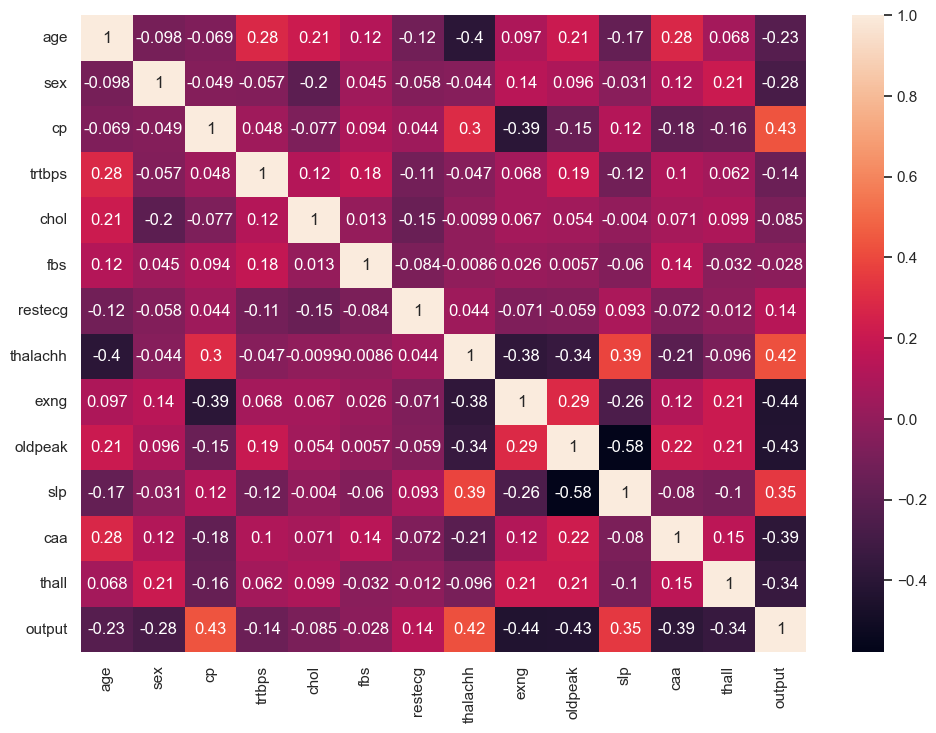

In [9]:
# Create a heatmap of the correlation matrix for the DataFrame df
# annot=True displays the correlation values on the heatmap
sns.heatmap(df.corr(), annot=True)

Number of people with sex as Male: 96
Number of people with sex Female: 207


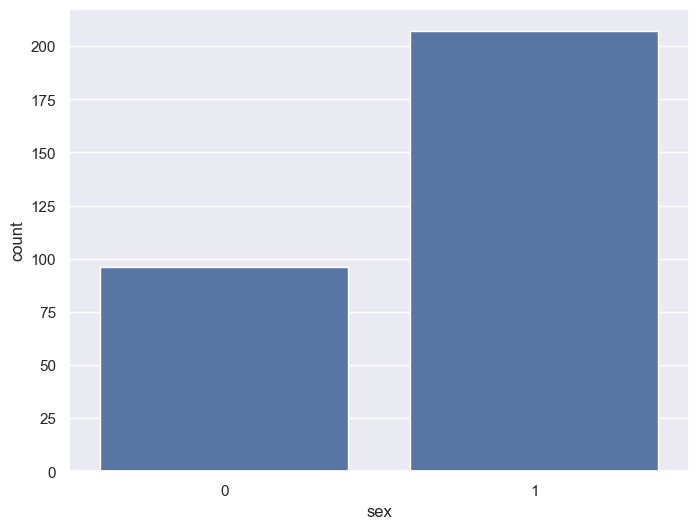

In [10]:
# Count the number of people by sex
sex_counts = df['sex'].value_counts()

# Print the counts
print(f'Number of people with sex as Male: {sex_counts[0]}')
print(f'Number of people with sex Female: {sex_counts[1]}')

# Plot the counts using seaborn
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x="sex")
plt.show()

Counts of each chest pain type:
cp
0    143
2     87
1     50
3     23
Name: count, dtype: int64


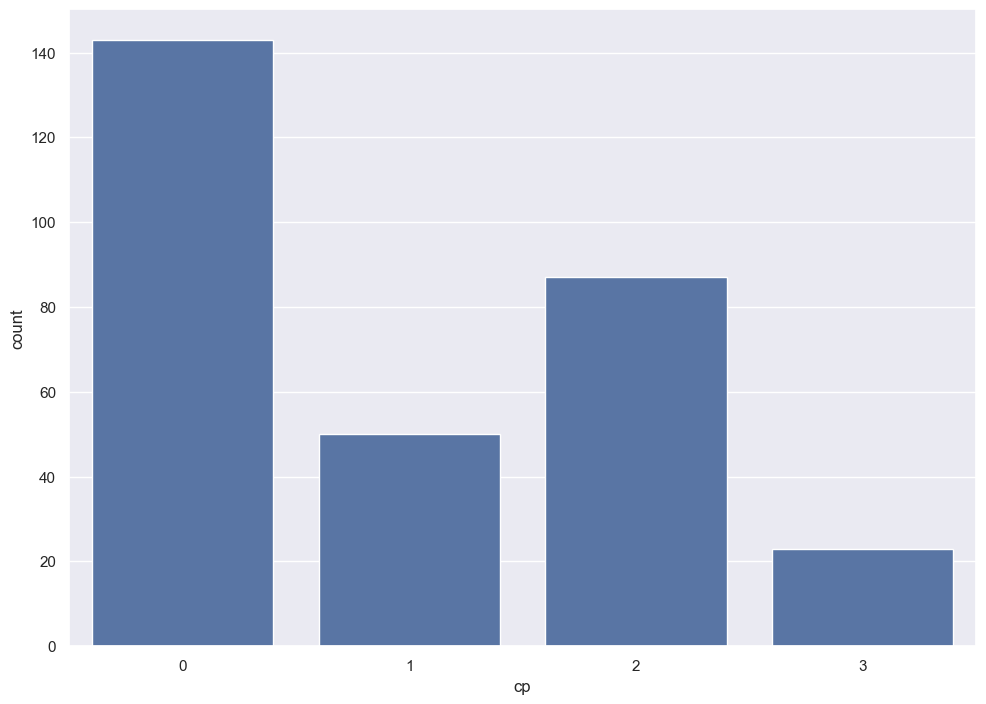

In [11]:
# Count the number of occurrences of each chest pain type
cp_counts = df['cp'].value_counts()

# Print the counts of each chest pain type
print("Counts of each chest pain type:")
print(cp_counts)

# Visualize the distribution of chest pain types
sns.countplot(data=df, x="cp")
plt.show()

Counts of each value in the 'chol' column:
chol
204    6
197    6
234    6
269    5
254    5
      ..
284    1
224    1
167    1
276    1
131    1
Name: count, Length: 152, dtype: int64


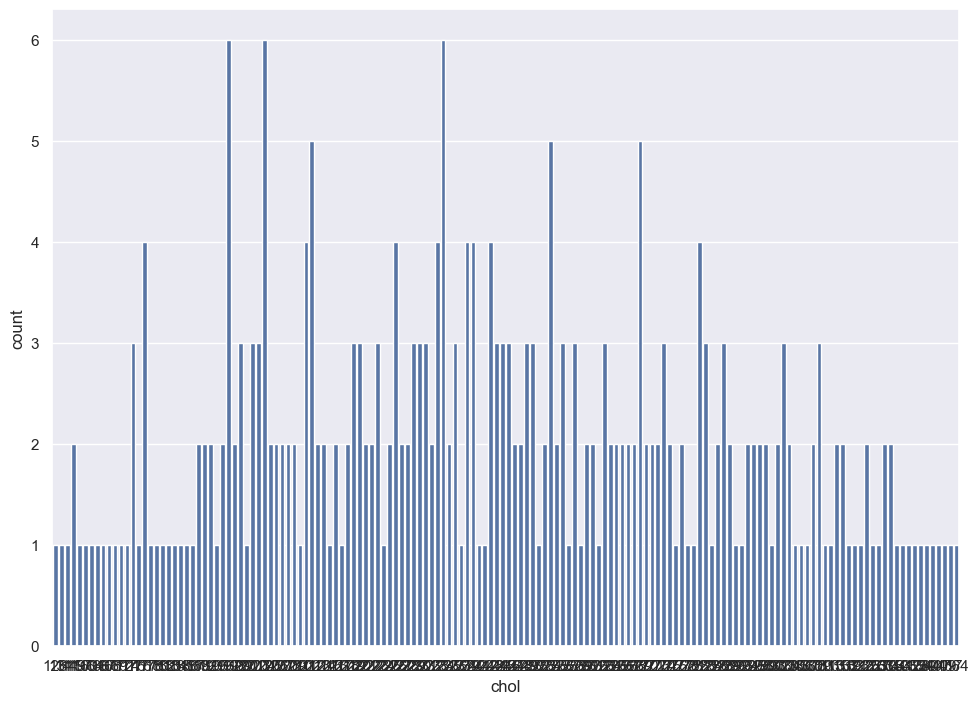

In [12]:
# Count the number of occurrences of each value in the "chol" column
chol_counts = df['chol'].value_counts()

# Print the counts of each value in the "chol" column
print("Counts of each value in the 'chol' column:")
print(chol_counts)

# Visualize the distribution of values in the "chol" column
sns.countplot(data=df, x="chol")
plt.show()

Counts of each value in the 'fbs' column:
fbs
0    258
1     45
Name: count, dtype: int64


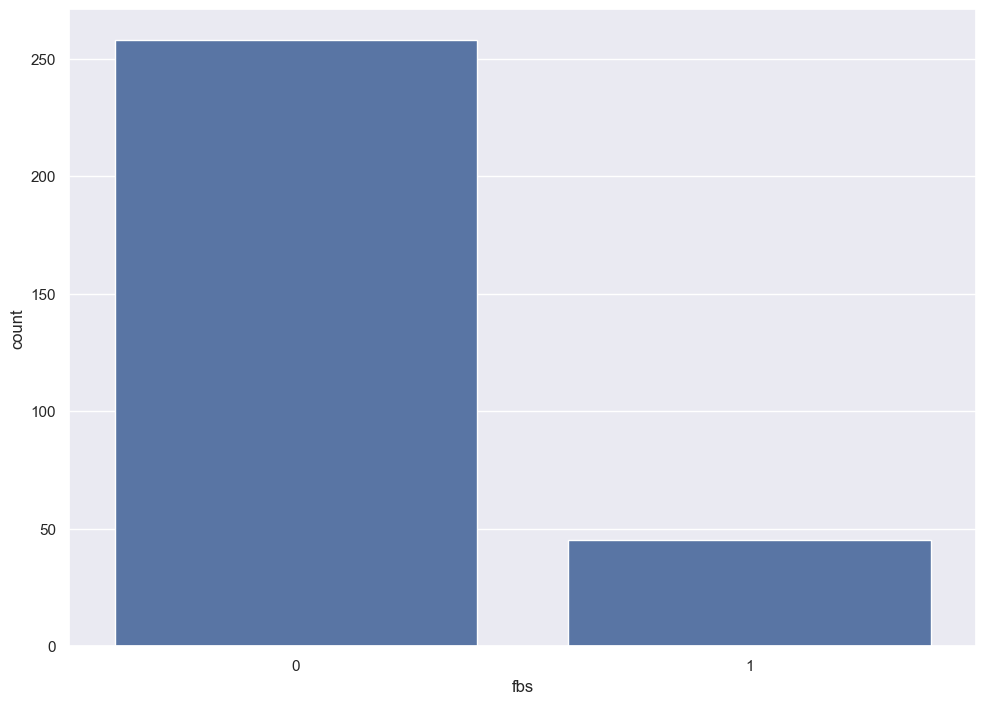

In [13]:
# Count the number of occurrences of each value in the "fbs" column
fbs_counts = df['fbs'].value_counts()

# Print the counts of each value in the "fbs" column
print("Counts of each value in the 'fbs' column:")
print(fbs_counts)

# Visualize the distribution of values in the "fbs" column
sns.countplot(data=df, x="fbs")
plt.show()

Counts of each value in the 'restecg' column:
restecg
1    152
0    147
2      4
Name: count, dtype: int64


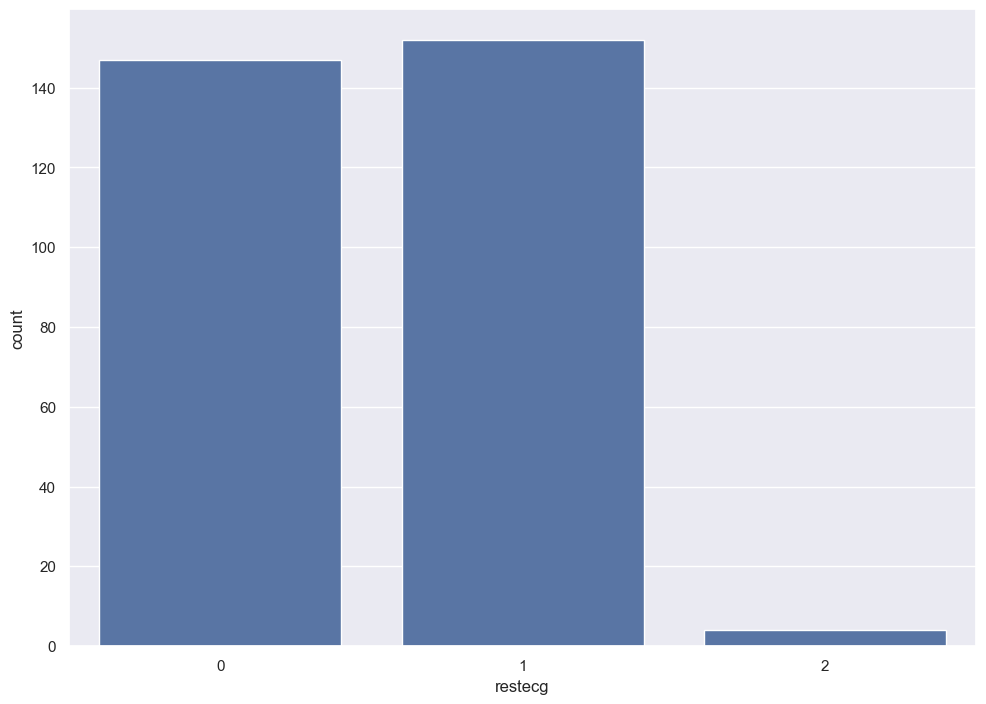

In [14]:
# Count the number of occurrences of each value in the "restecg" column
restecg_counts = df['restecg'].value_counts()

# Print the counts of each value in the "restecg" column
print("Counts of each value in the 'restecg' column:")
print(restecg_counts)

# Visualize the distribution of values in the "restecg" column
sns.countplot(data=df, x="restecg")
plt.show()

Counts of each value in the 'exng' column:
exng
0    204
1     99
Name: count, dtype: int64


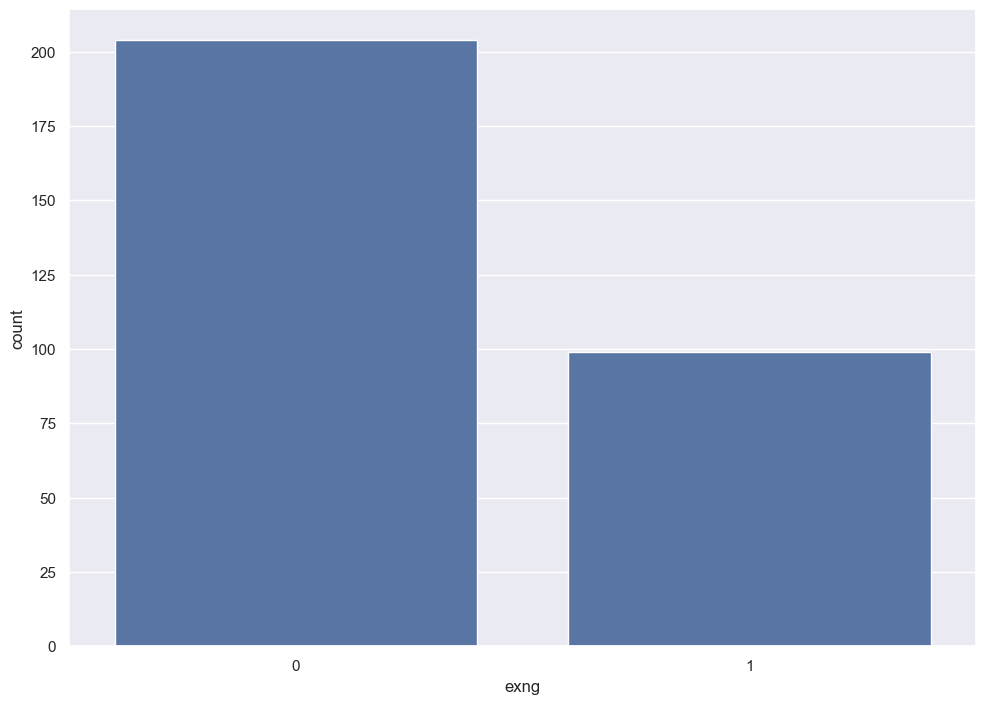

In [15]:
# Count the number of occurrences of each value in the "exng" column
exng_counts = df['exng'].value_counts()

# Print the counts of each value in the "exng" column
print("Counts of each value in the 'exng' column:")
print(exng_counts)

# Visualize the distribution of values in the "exng" column using a countplot
sns.countplot(data=df, x="exng")
plt.show()

Counts of each value in the 'oldpeak' column:
oldpeak
0.0    99
1.2    17
1.0    14
0.6    14
1.4    13
0.8    13
0.2    12
1.6    11
1.8    10
0.4     9
2.0     9
0.1     7
2.8     6
2.6     6
1.5     5
3.0     5
1.9     5
0.5     5
3.6     4
2.2     4
2.4     3
0.9     3
3.4     3
4.0     3
0.3     3
2.3     2
3.2     2
2.5     2
4.2     2
1.1     2
3.1     1
0.7     1
3.5     1
6.2     1
1.3     1
5.6     1
2.9     1
2.1     1
3.8     1
4.4     1
Name: count, dtype: int64


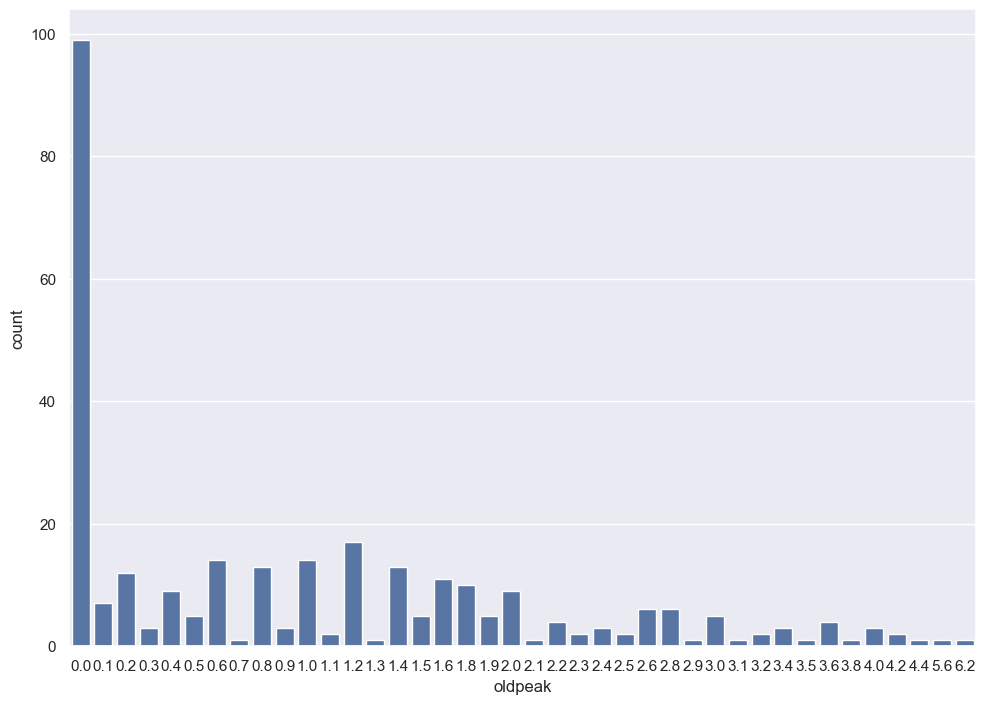

In [16]:
# Count the number of occurrences of each value in the "oldpeak" column
oldpeak_counts = df['oldpeak'].value_counts()

# Print the counts of each value in the "oldpeak" column
print("Counts of each value in the 'oldpeak' column:")
print(oldpeak_counts)

# Visualize the distribution of values in the "oldpeak" column using a countplot
sns.countplot(data=df, x="oldpeak")
plt.show()

Counts of each value in the 'slp' column:
slp
2    142
1    140
0     21
Name: count, dtype: int64


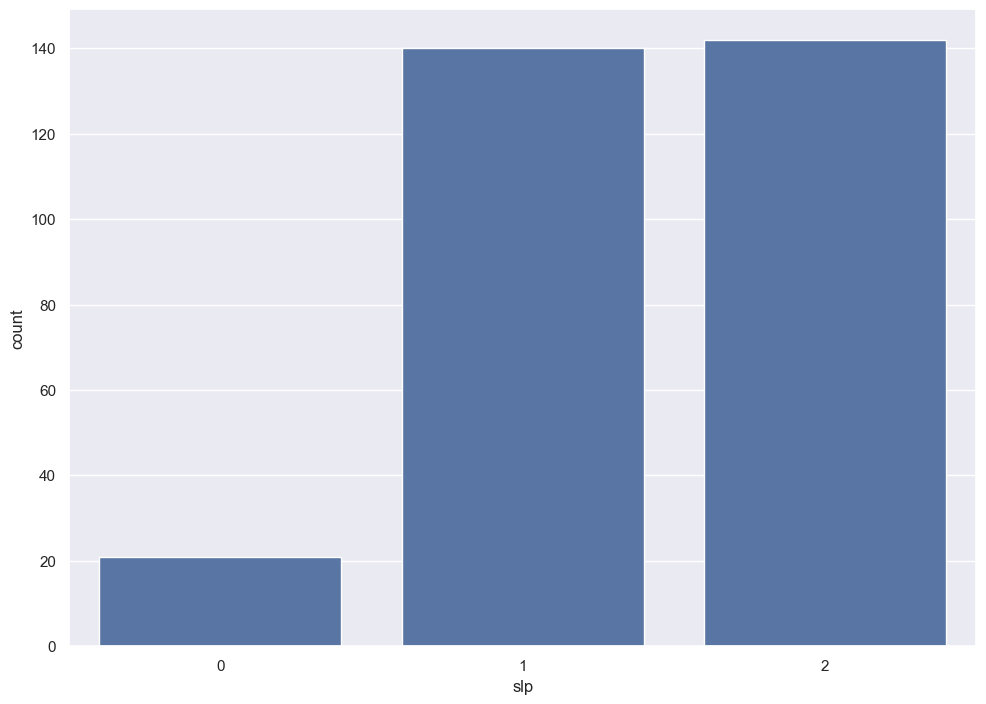

In [17]:
# Count the number of occurrences of each value in the "slp" column
slp_counts = df['slp'].value_counts()

# Print the counts of each value in the "slp" column
print("Counts of each value in the 'slp' column:")
print(slp_counts)

# Visualize the distribution of values in the "slp" column using a countplot
sns.countplot(data=df, x="slp")
plt.show()

Counts of each value in the 'caa' column:
caa
0    175
1     65
2     38
3     20
4      5
Name: count, dtype: int64


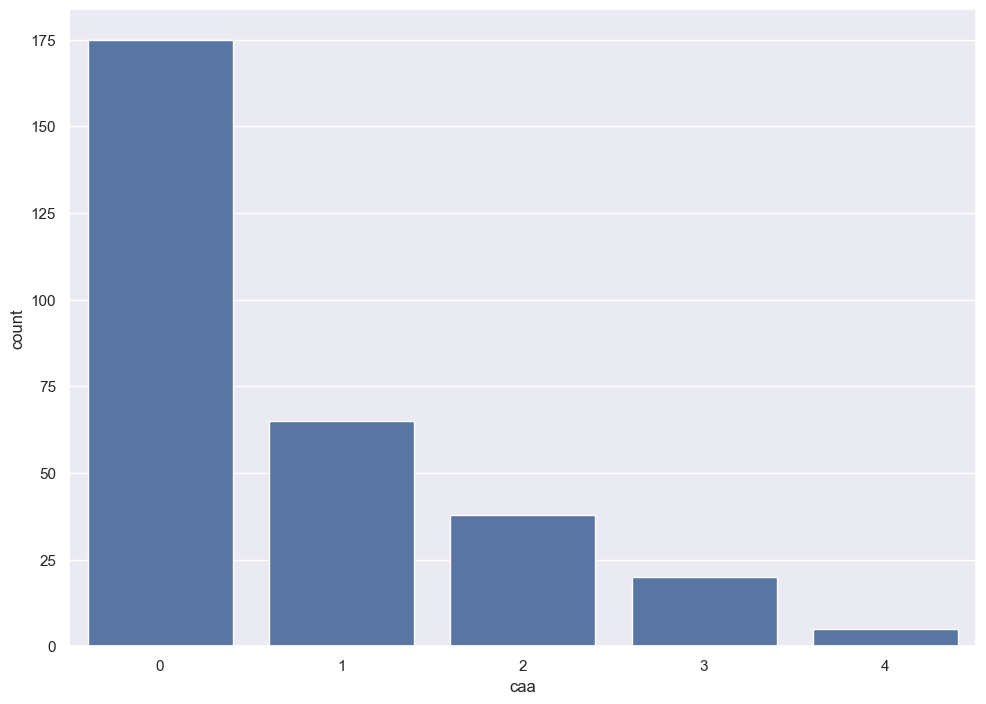

In [18]:
# Count the number of occurrences of each value in the "caa" column
caa_counts = df['caa'].value_counts()

# Print the counts of each value in the "caa" column
print("Counts of each value in the 'caa' column:")
print(caa_counts)

# Visualize the distribution of values in the "caa" column using a countplot
sns.countplot(data=df, x="caa")
plt.show()

Counts of each value in the 'thall' column:
thall
2    166
3    117
1     18
0      2
Name: count, dtype: int64


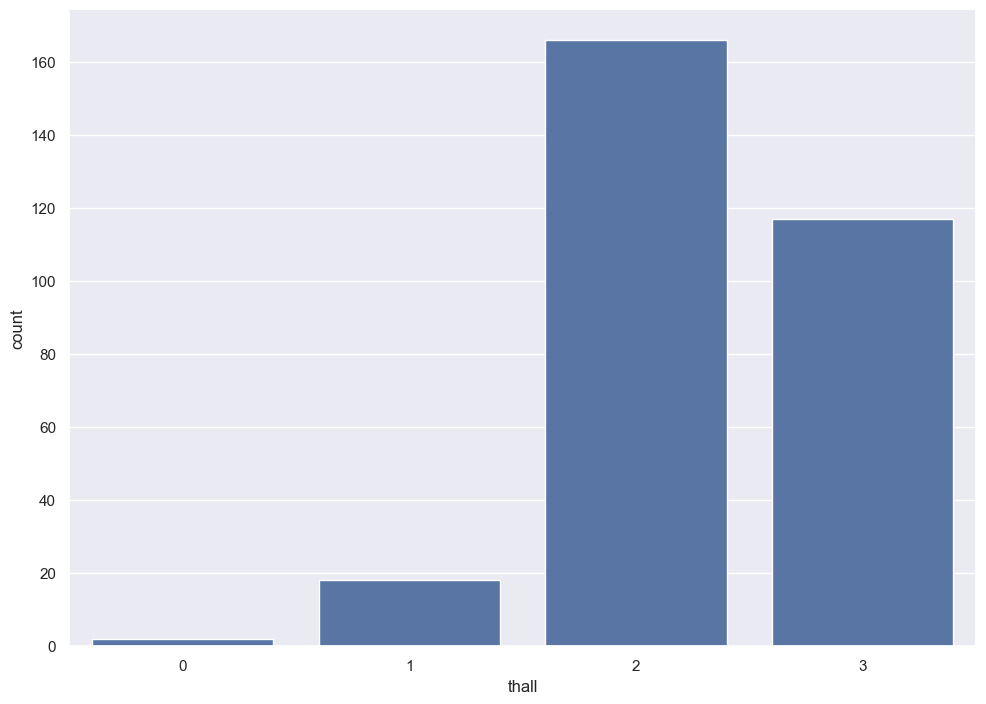

In [19]:
# Count the number of occurrences of each value in the "thall" column
thall_counts = df['thall'].value_counts()

# Print the counts of each value in the "thall" column
print("Counts of each value in the 'thall' column:")
print(thall_counts)

# Visualize the distribution of values in the "thall" column using a countplot
sns.countplot(data=df, x="thall")
plt.show()

Counts of each value in the 'output' column:
output
1    165
0    138
Name: count, dtype: int64


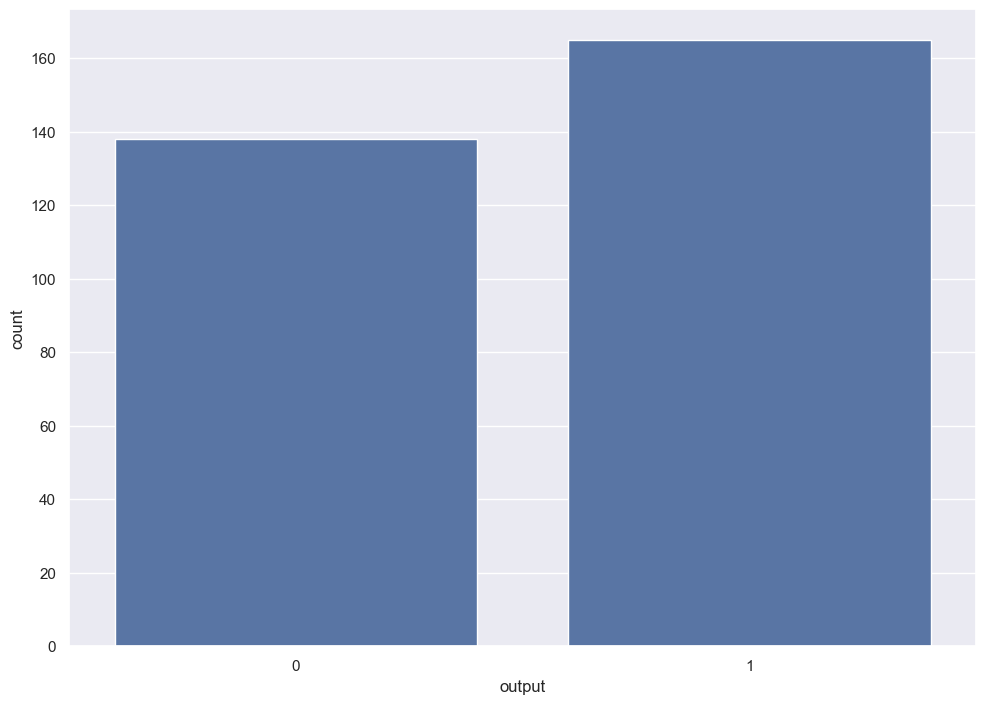

In [20]:
# Count the number of occurrences of each value in the "output" column
output_counts = df['output'].value_counts()

# Print the counts of each value in the "output" column
print("Counts of each value in the 'output' column:")
print(output_counts)

# Visualize the distribution of values in the "output" column using a countplot
sns.countplot(data=df, x="output")
plt.show()

<Figure size 1000x1000 with 0 Axes>

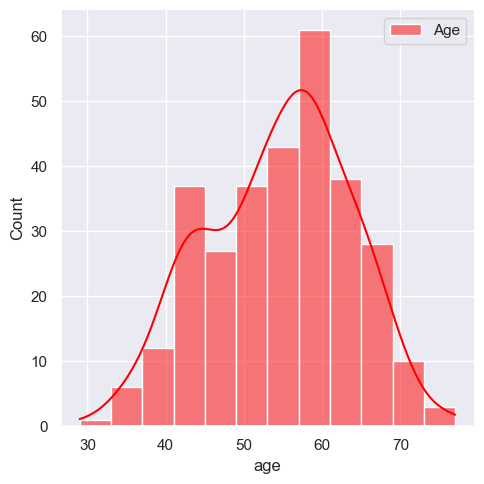

In [21]:
# Set the size of the figure
plt.figure(figsize=(10, 10))

# Create a distribution plot for the "age" column
sns.displot(df.age, color="red", label="Age", kde=True)

# Add a legend
plt.legend()

# Display the plot
plt.show()

<Figure size 2000x2000 with 0 Axes>

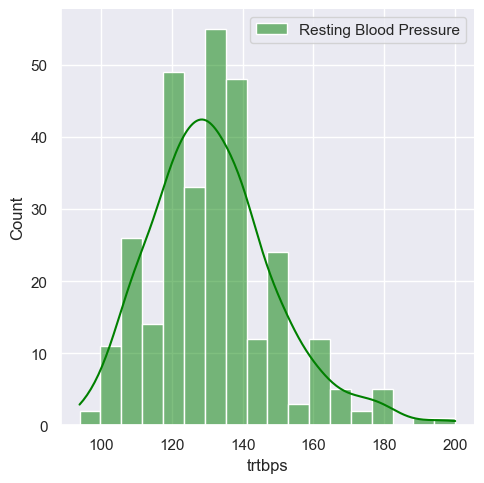

In [22]:
# Set the size of the figure
plt.figure(figsize=(20, 20))

# Create a distribution plot for the "trtbps" (Resting Blood Pressure) column
sns.displot(df.trtbps, color="green", label="Resting Blood Pressure", kde=True)

# Add a legend
plt.legend()

Heart Attack Vs Age

C:\Users\piyus\AppData\Local\Temp\ipykernel_21480\3403143332.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['output'] == 0]["age"], color='green', label='No attack')
C:\Users\piyus\AppData\Local\Temp\ipykernel_21480\3403143332.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df[

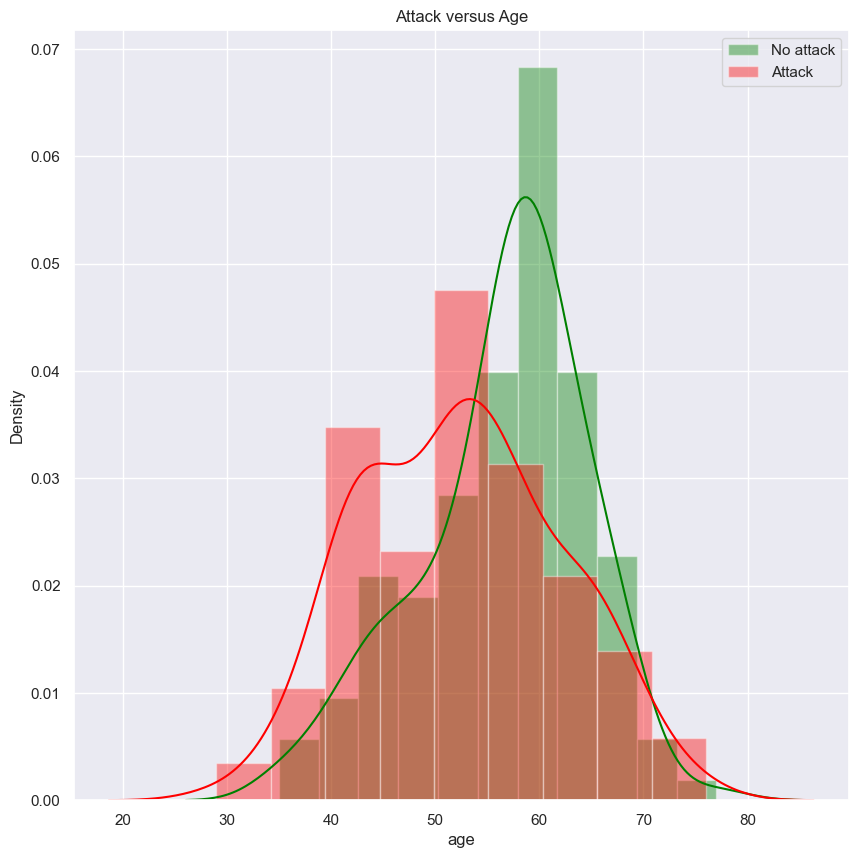

In [23]:
# Set the size of the figure
plt.figure(figsize=(10, 10))

# Plot the distribution of age for patients with output 0 (No attack) in green
sns.distplot(df[df['output'] == 0]["age"], color='green', label='No attack')

# Plot the distribution of age for patients with output 1 (Attack) in red
sns.distplot(df[df['output'] == 1]["age"], color='red', label='Attack')

# Add a title to the plot
plt.title('Attack versus Age')

# Add a legend
plt.legend()

# Show the plot
plt.show()

Cholrestrol versus age

C:\Users\piyus\AppData\Local\Temp\ipykernel_21480\4059806457.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['output'] == 0]["chol"], color='green', label='No attack')
C:\Users\piyus\AppData\Local\Temp\ipykernel_21480\4059806457.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df

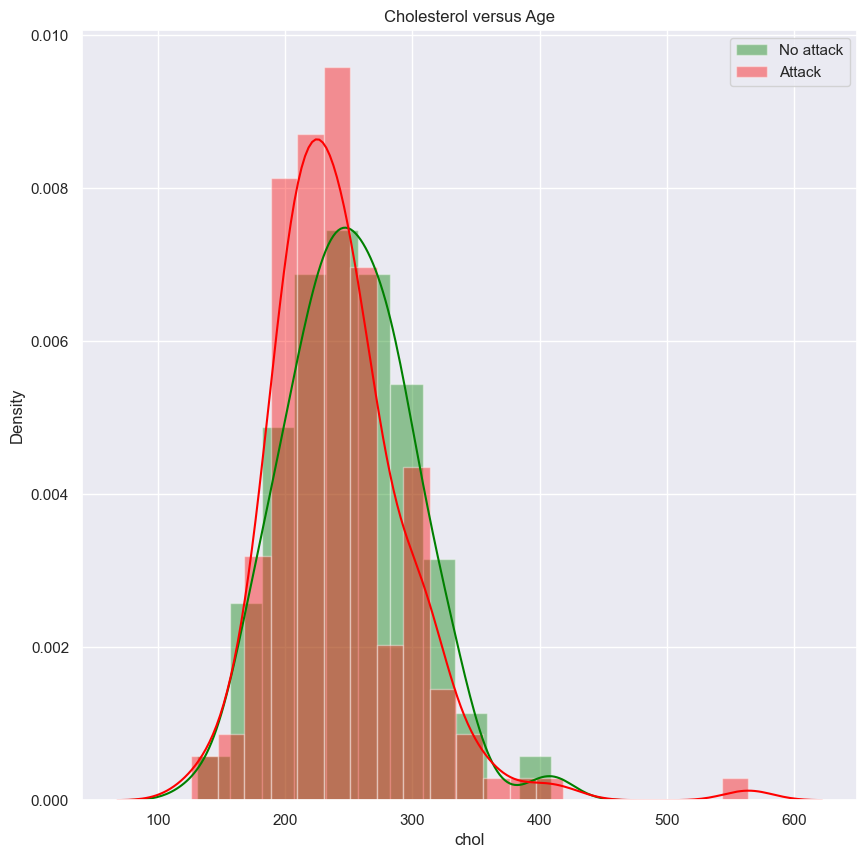

In [24]:
# Set the size of the figure
plt.figure(figsize=(10, 10))

# Plot the distribution of cholesterol for patients with output 0 (No attack) in green
sns.distplot(df[df['output'] == 0]["chol"], color='green', label='No attack')

# Plot the distribution of cholesterol for patients with output 1 (Attack) in red
sns.distplot(df[df['output'] == 1]["chol"], color='red', label='Attack')

# Add a title to the plot
plt.title('Cholesterol versus Age')

# Add a legend
plt.legend()

# Show the plot
plt.show()

trtbps versus age 

C:\Users\piyus\AppData\Local\Temp\ipykernel_21480\2693460542.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['output'] == 0]["trtbps"], color='green', label='No attack')
C:\Users\piyus\AppData\Local\Temp\ipykernel_21480\2693460542.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[

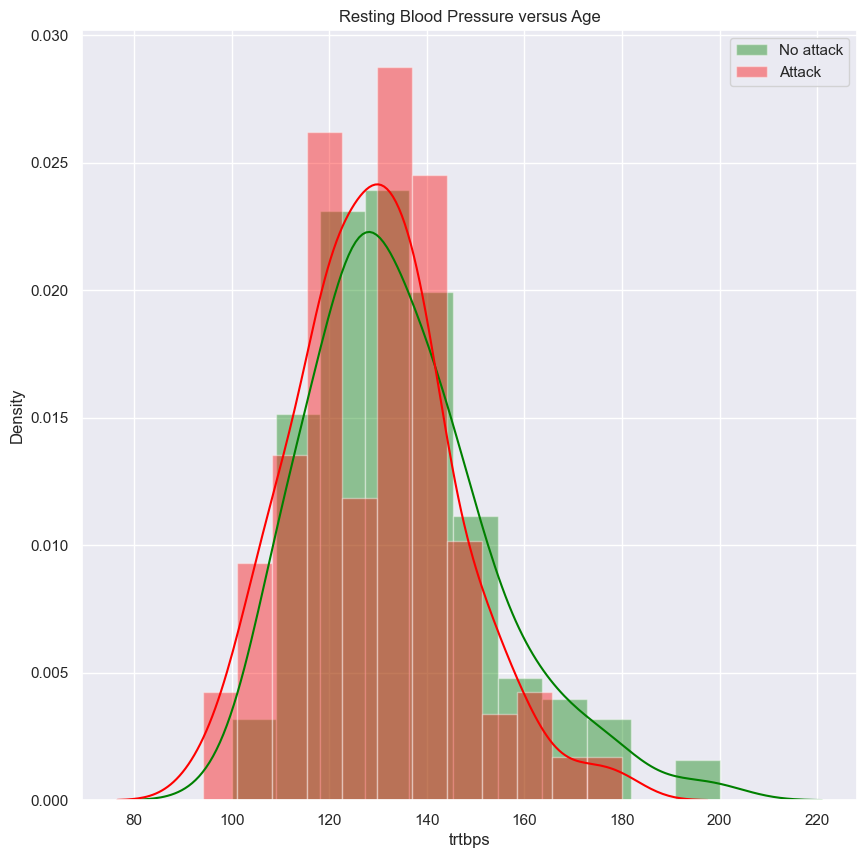

In [25]:
# Set the size of the figure
plt.figure(figsize=(10, 10))

# Plot the distribution of resting blood pressure for patients with output 0 (No attack) in green
sns.distplot(df[df['output'] == 0]["trtbps"], color='green', label='No attack')

# Plot the distribution of resting blood pressure for patients with output 1 (Attack) in red
sns.distplot(df[df['output'] == 1]["trtbps"], color='red', label='Attack')

# Add a title to the plot
plt.title('Resting Blood Pressure versus Age')

# Add a legend
plt.legend()

# Show the plot
plt.show()

thalachh versus age

C:\Users\piyus\AppData\Local\Temp\ipykernel_21480\3117581427.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['output'] == 0]["thalachh"], color='green', label='No attack')
C:\Users\piyus\AppData\Local\Temp\ipykernel_21480\3117581427.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(d

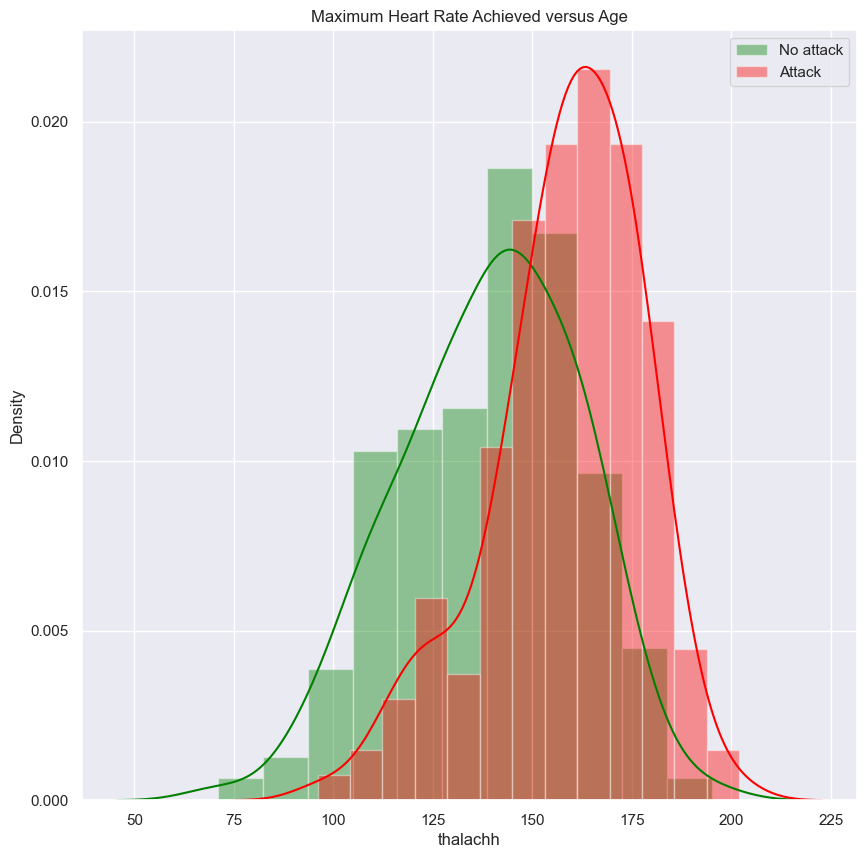

In [26]:
# Set the size of the figure
plt.figure(figsize=(10, 10))

# Plot the distribution of maximum heart rate achieved for patients with output 0 (No attack) in green
sns.distplot(df[df['output'] == 0]["thalachh"], color='green', label='No attack')

# Plot the distribution of maximum heart rate achieved for patients with output 1 (Attack) in red
sns.distplot(df[df['output'] == 1]["thalachh"], color='red', label='Attack')

# Add a title to the plot
plt.title('Maximum Heart Rate Achieved versus Age')

# Add a legend
plt.legend()

# Show the plot
plt.show()

Pair Plot

<Figure size 2000x2000 with 0 Axes>

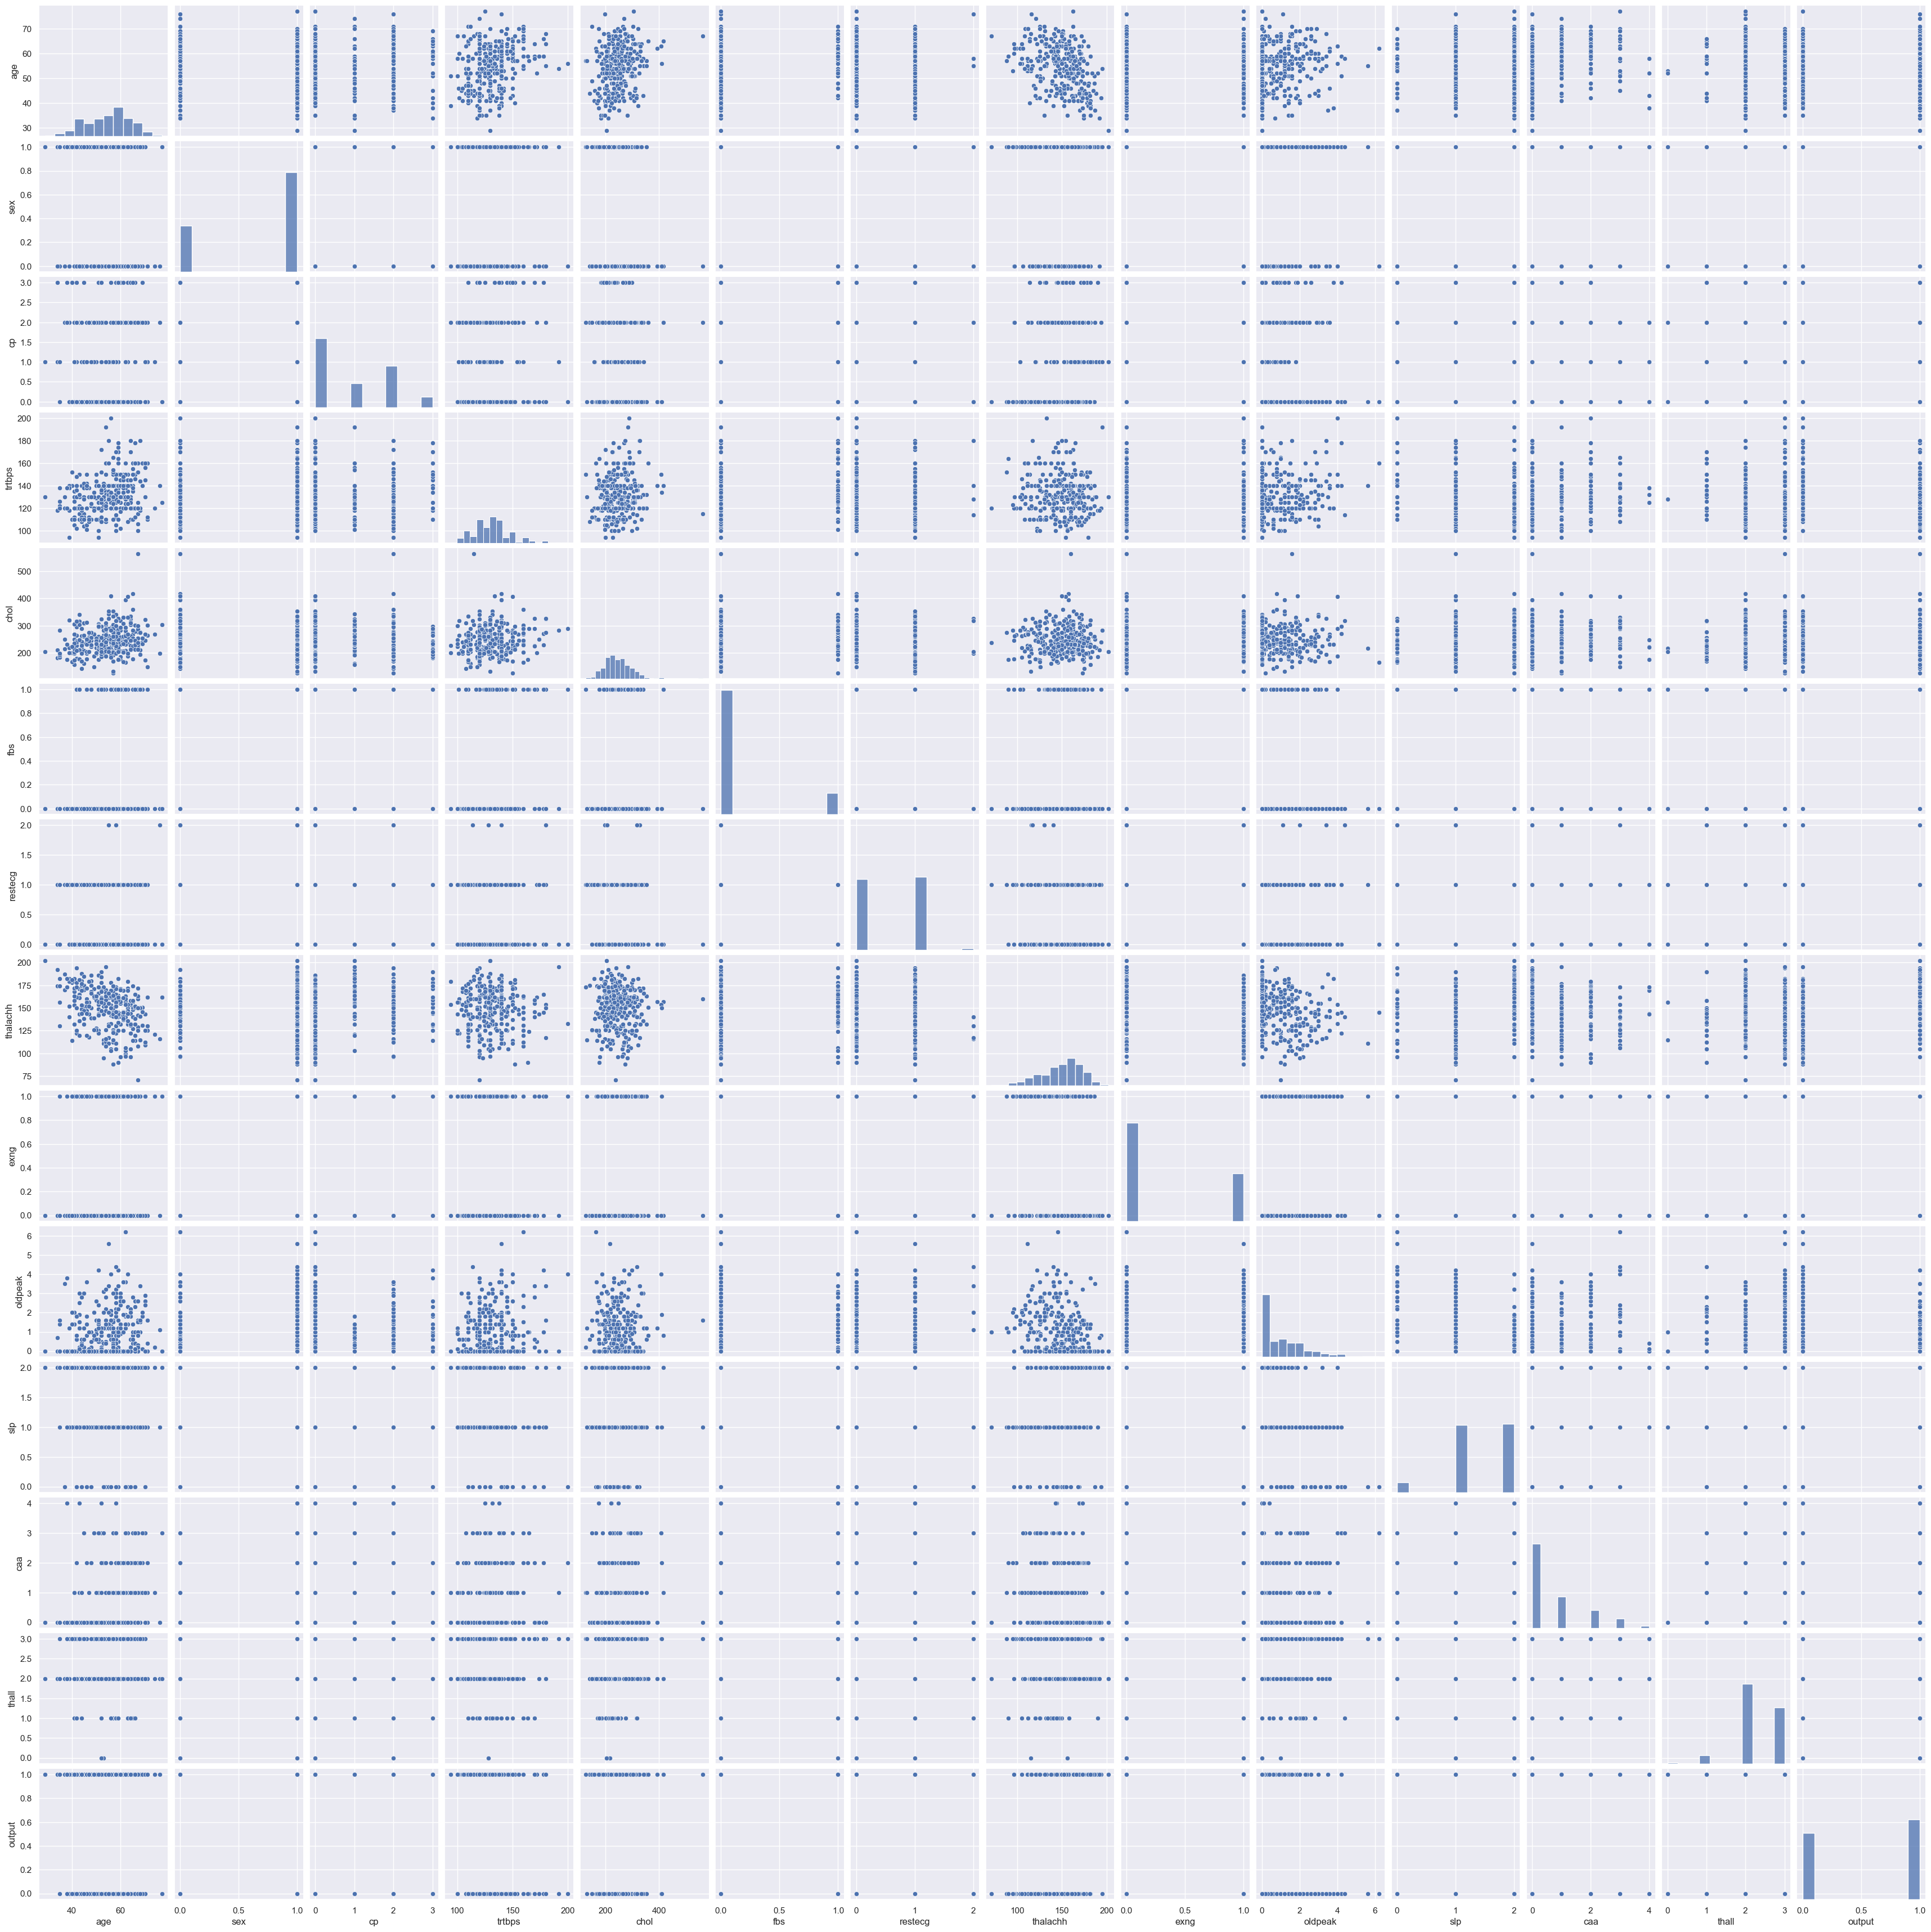

In [27]:
# Set the size of the figure
plt.figure(figsize=(20, 20))

# Create a pairwise plot of all numerical variables in the DataFrame
sns.pairplot(df)

# Show the plot
plt.show()

DATA PROCESSING

In [28]:
# Extract feature variables (all columns except the first and last) and target variable (last column)
x = df.iloc[:, 1:-1].values
y = df.iloc[:, -1].values

# Print the feature variables (x) and target variable (y)
x, y

(array([[  1.,   3., 145., ...,   0.,   0.,   1.],
        [  1.,   2., 130., ...,   0.,   0.,   2.],
        [  0.,   1., 130., ...,   2.,   0.,   2.],
        ...,
        [  1.,   0., 144., ...,   1.,   2.,   3.],
        [  1.,   0., 130., ...,   1.,   1.,   3.],
        [  0.,   1., 130., ...,   1.,   1.,   2.]]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0,

Splitting the Dataset

In [29]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [30]:
# Initialize StandardScaler
scaler = StandardScaler()

# Standardize the training data (x_train)
x_train = scaler.fit_transform(x_train)

# Standardize the testing data (x_test) using the same scaler as training data
x_test = scaler.transform(x_test)

Model Initializations

In [31]:
# Define the parameter grid for early stopping
early_stopping_params = [(5, True), (10, False)]

In [32]:
# Define k-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

1.  multi-layer perceptron Model

In [33]:
# Initialize necessary variables
best_accuracy_MLP = 0.0
best_model_MLP = None
fold_histories = {}
accuracy_list = []
loss_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []
confusion_matrices = [] 
training_time_list = []
results_df_mlp = pd.DataFrame(columns=['Fold', 'Early_Stopping', 'Accuracy', 'Loss', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC', 'Training_Time'])

In [34]:
# Perform grid search
for fold_index, (train_index, val_index) in enumerate(kfold.split(x_train, y_train), 1):
    print(f"\nFold {fold_index}:")

    x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Apply SMOTE for data augmentation
    smote = SMOTE(random_state=42)
    x_train_fold, y_train_fold = smote.fit_resample(x_train_fold, y_train_fold)

    accuracies_MLP = []
    losses_MLP = []
    precisions_MLP = []
    recalls_MLP = []
    f1_scores_MLP = []
    auc_rocs_MLP = []
    training_times_MLP = []

    for early_stopping_param in early_stopping_params:
        # Define your model architecture as a Multi-Layer Perceptron with L2 regularization and batch normalization
        model_MLP = Sequential([
            Dense(64, activation='relu', input_shape=(x_train.shape[1],), kernel_regularizer=regularizers.l2(0.01)),
            BatchNormalization(),
            Dropout(0.5),  # Add dropout layer
            Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
            BatchNormalization(),
            Dropout(0.3),
            Dense(1, activation='sigmoid')  # Output layer
        ])

        # Compile the model with binary cross-entropy loss
        model_MLP.compile(optimizer='RMSProp', loss='binary_crossentropy', metrics=['accuracy'])

        # Define early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_param[0], restore_best_weights=early_stopping_param[1])

        # Train the model and measure training time
        start_time = time.time()
        history = model_MLP.fit(x_train_fold, y_train_fold, epochs=75, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)
        training_time = time.time() - start_time
        training_times_MLP.append(training_time)

        # Evaluate the model on validation data
        eval_loss, accuracy_MLP = model_MLP.evaluate(x_val_fold, y_val_fold)
        accuracies_MLP.append(accuracy_MLP)
        losses_MLP.append(eval_loss)

        # Get predictions for calculating additional metrics
        y_pred = (model_MLP.predict(x_val_fold) > 0.5).astype("int32")

        # Calculate additional metrics
        precision = precision_score(y_val_fold, y_pred)
        recall = recall_score(y_val_fold, y_pred)
        f1 = f1_score(y_val_fold, y_pred)
        auc = roc_auc_score(y_val_fold, y_pred)

        precisions_MLP.append(precision)
        recalls_MLP.append(recall)
        f1_scores_MLP.append(f1)
        auc_rocs_MLP.append(auc)

        # Append results to the DataFrame
        results_df_mlp = pd.concat([results_df_mlp, pd.DataFrame({
            'Fold': [fold_index],
            'Early_Stopping': [early_stopping_param],
            'Accuracy': [accuracy_MLP],
            'Loss': [eval_loss],
            'Precision': [precision],
            'Recall': [recall],
            'F1-Score': [f1],
            'AUC-ROC': [auc],
            'Training_Time': [training_time]
        })], ignore_index=True)

        print(f"Early Stopping: {early_stopping_param}, Accuracy = {accuracy_MLP:.4f}, Loss = {eval_loss:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1-Score = {f1:.4f}, AUC-ROC = {auc:.4f}, Training Time = {training_time:.2f} seconds")

        # Update lists for histograms
        accuracy_list.extend(accuracies_MLP)
        loss_list.extend(losses_MLP)
        precision_list.extend(precisions_MLP)
        recall_list.extend(recalls_MLP)
        f1_list.extend(f1_scores_MLP)
        auc_list.extend(auc_rocs_MLP)
        training_time_list.extend(training_times_MLP)

        # Calculate mean accuracy and loss
        mean_accuracy_MLP = np.mean(accuracies_MLP)
        mean_loss_MLP = np.mean(losses_MLP)

        # Store training history
        fold_histories[fold_index] = history

        # Update best parameters if the mean accuracy is higher
        if mean_accuracy_MLP > best_accuracy_MLP:
            # Compute confusion matrix
            cm = confusion_matrix(y_val_fold, y_pred)
            confusion_matrices.append(cm)
            best_accuracy_MLP = mean_accuracy_MLP
            best_model_MLP = model_MLP

# Print best parameters and mean accuracy
print("Best Mean Accuracy:", best_accuracy_MLP)

# Save the best trained model to disk
if best_model_MLP is not None:
    best_model_MLP.save('saved_model/MLP_Model.h5')

# Find the best model based on validation accuracy
best_fold_index_MLP = results_df_mlp.loc[results_df_mlp['Accuracy'].idxmax()]['Fold']
best_model_history_MLP = fold_histories[best_fold_index_MLP]


Fold 1:


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7294 - loss: 0.8167 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Early Stopping: (5, True), Accuracy = 0.7347, Loss = 0.7904, Precision = 0.7500, Recall = 0.7778, F1-Score = 0.7636, AUC-ROC = 0.7298, Training Time = 6.04 seconds


C:\Users\piyus\AppData\Local\Temp\ipykernel_21480\2807117482.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df_mlp = pd.concat([results_df_mlp, pd.DataFrame({
C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6949 - loss: 0.9088 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Early Stopping: (10, False), Accuracy = 0.7143, Loss = 0.8764, Precision = 0.7407, Recall = 0.7407, F1-Score = 0.7407, AUC-ROC = 0.7113, Training Time = 5.76 seconds

Fold 2:


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8151 - loss: 0.7607 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Early Stopping: (5, True), Accuracy = 0.8163, Loss = 0.7298, Precision = 0.8148, Recall = 0.8462, F1-Score = 0.8302, AUC-ROC = 0.8144, Training Time = 5.60 seconds


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8151 - loss: 0.6931 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Early Stopping: (10, False), Accuracy = 0.8163, Loss = 0.6827, Precision = 0.8400, Recall = 0.8077, F1-Score = 0.8235, AUC-ROC = 0.8169, Training Time = 6.25 seconds

Fold 3:


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8854 - loss: 0.6523 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Early Stopping: (5, True), Accuracy = 0.8750, Loss = 0.6578, Precision = 0.8571, Recall = 0.9231, F1-Score = 0.8889, AUC-ROC = 0.8706, Training Time = 6.56 seconds


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7882 - loss: 0.6790 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Early Stopping: (10, False), Accuracy = 0.7917, Loss = 0.6818, Precision = 0.7500, Recall = 0.9231, F1-Score = 0.8276, AUC-ROC = 0.7797, Training Time = 5.58 seconds

Fold 4:


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7917 - loss: 0.9304 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Early Stopping: (5, True), Accuracy = 0.8125, Loss = 0.8770, Precision = 0.7931, Recall = 0.8846, F1-Score = 0.8364, AUC-ROC = 0.8059, Training Time = 5.72 seconds


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7778 - loss: 0.8946 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Early Stopping: (10, False), Accuracy = 0.7917, Loss = 0.8537, Precision = 0.7500, Recall = 0.9231, F1-Score = 0.8276, AUC-ROC = 0.7797, Training Time = 5.39 seconds

Fold 5:


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8472 - loss: 0.6357 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Early Stopping: (5, True), Accuracy = 0.8333, Loss = 0.6524, Precision = 0.8000, Recall = 0.9231, F1-Score = 0.8571, AUC-ROC = 0.8252, Training Time = 5.51 seconds


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8611 - loss: 0.6500 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Early Stopping: (10, False), Accuracy = 0.8542, Loss = 0.6694, Precision = 0.8065, Recall = 0.9615, F1-Score = 0.8772, AUC-ROC = 0.8444, Training Time = 5.42 seconds
Best Mean Accuracy: 0.875


In [35]:
print(confusion_matrices)

[array([[15,  7],
       [ 6, 21]], dtype=int64), array([[18,  5],
       [ 4, 22]], dtype=int64), array([[18,  4],
       [ 2, 24]], dtype=int64)]


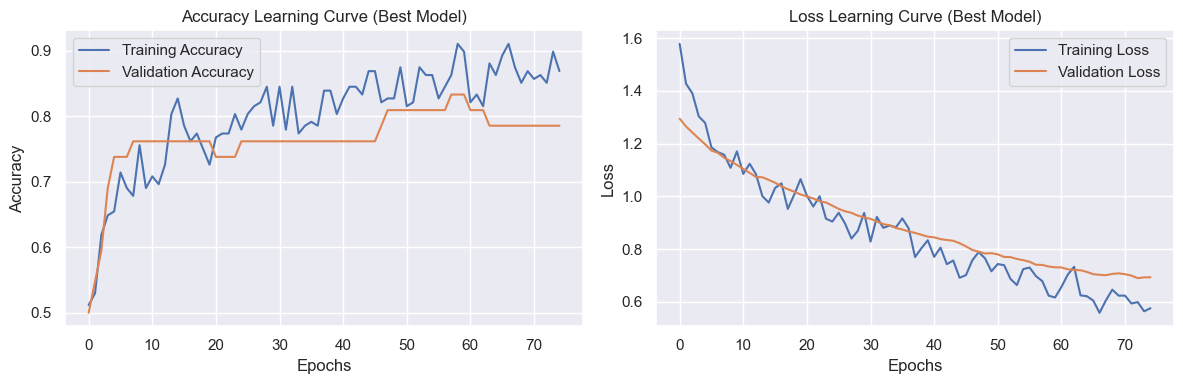

In [36]:
# Plot learning curves for the best model
plt.figure(figsize=(12, 4))

# Accuracy curve
plt.subplot(1, 2, 1)
plt.plot(best_model_history_MLP.history['accuracy'], label='Training Accuracy')
plt.plot(best_model_history_MLP.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Learning Curve (Best Model)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss curve
plt.subplot(1, 2, 2)
plt.plot(best_model_history_MLP.history['loss'], label='Training Loss')
plt.plot(best_model_history_MLP.history['val_loss'], label='Validation Loss')
plt.title('Loss Learning Curve (Best Model)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

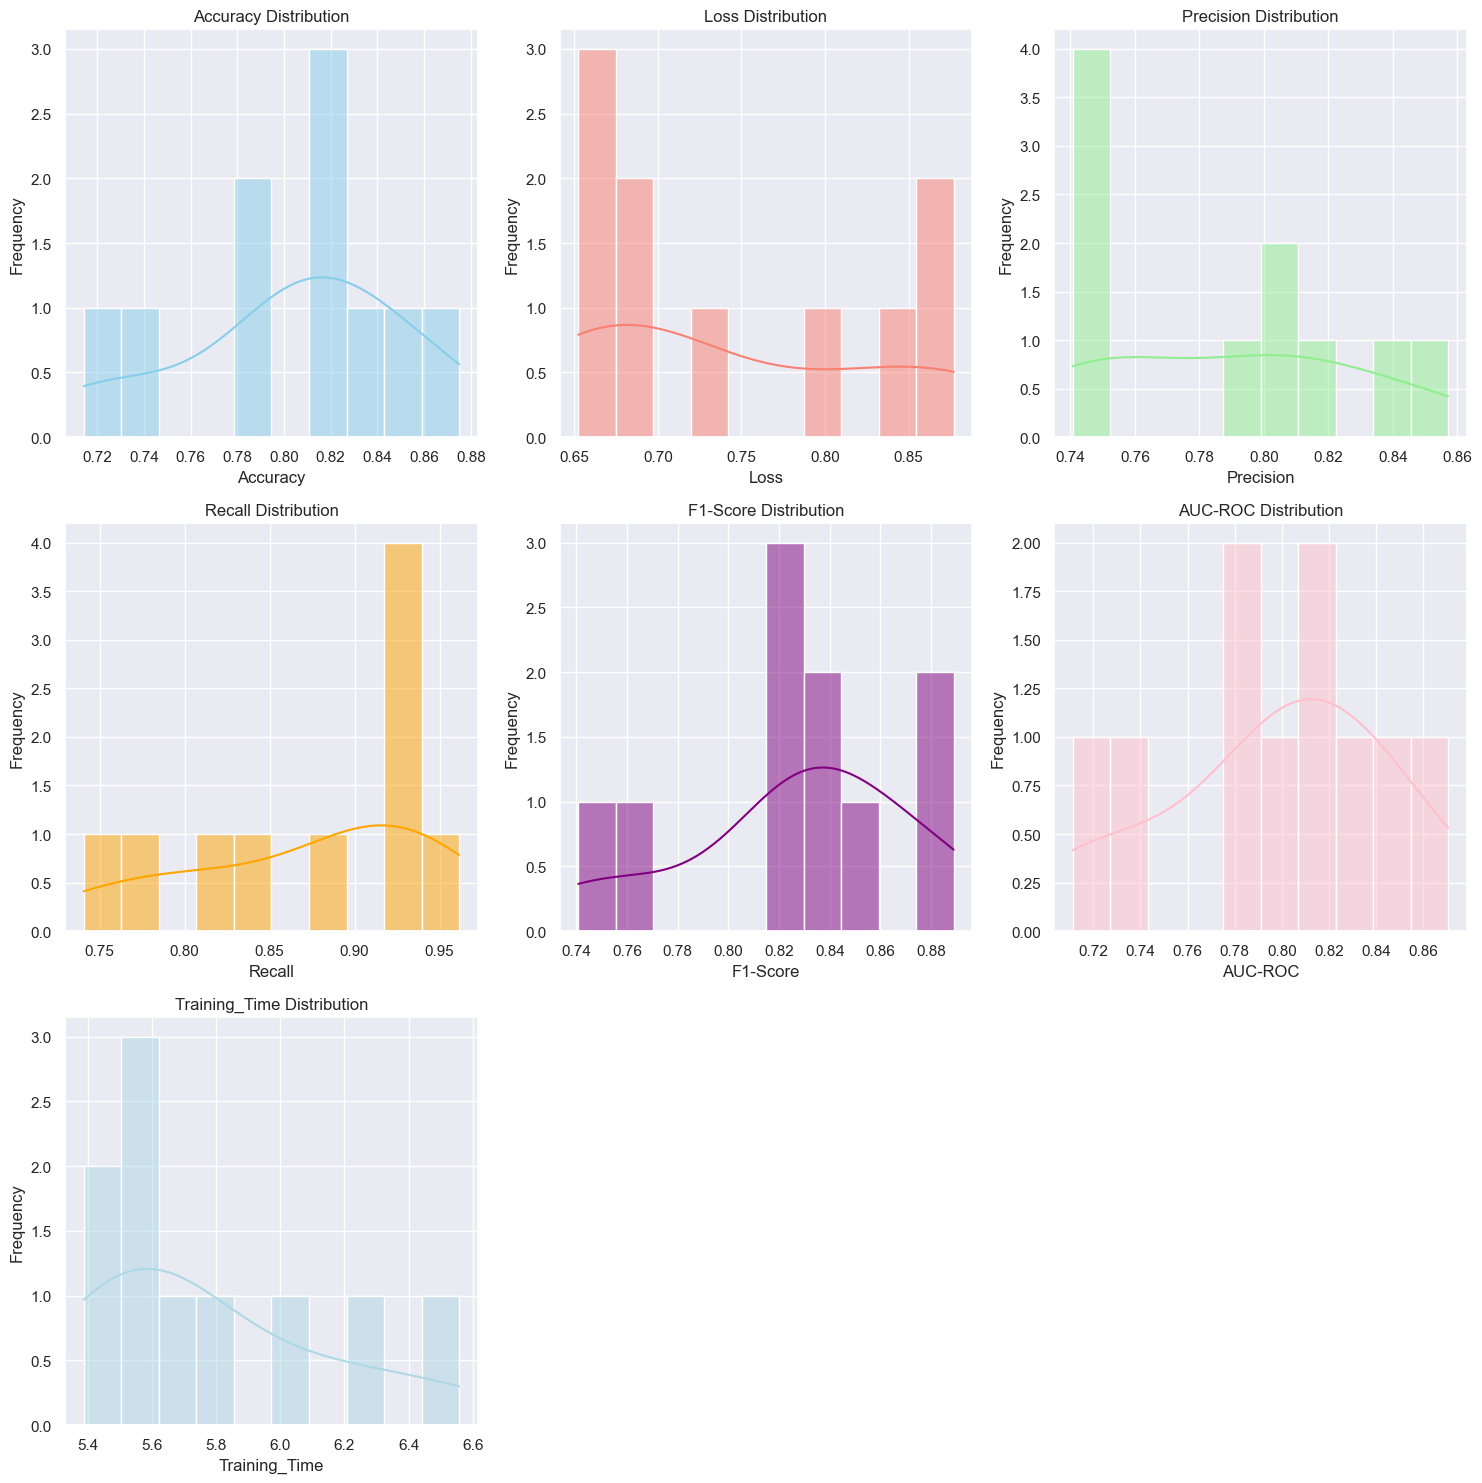

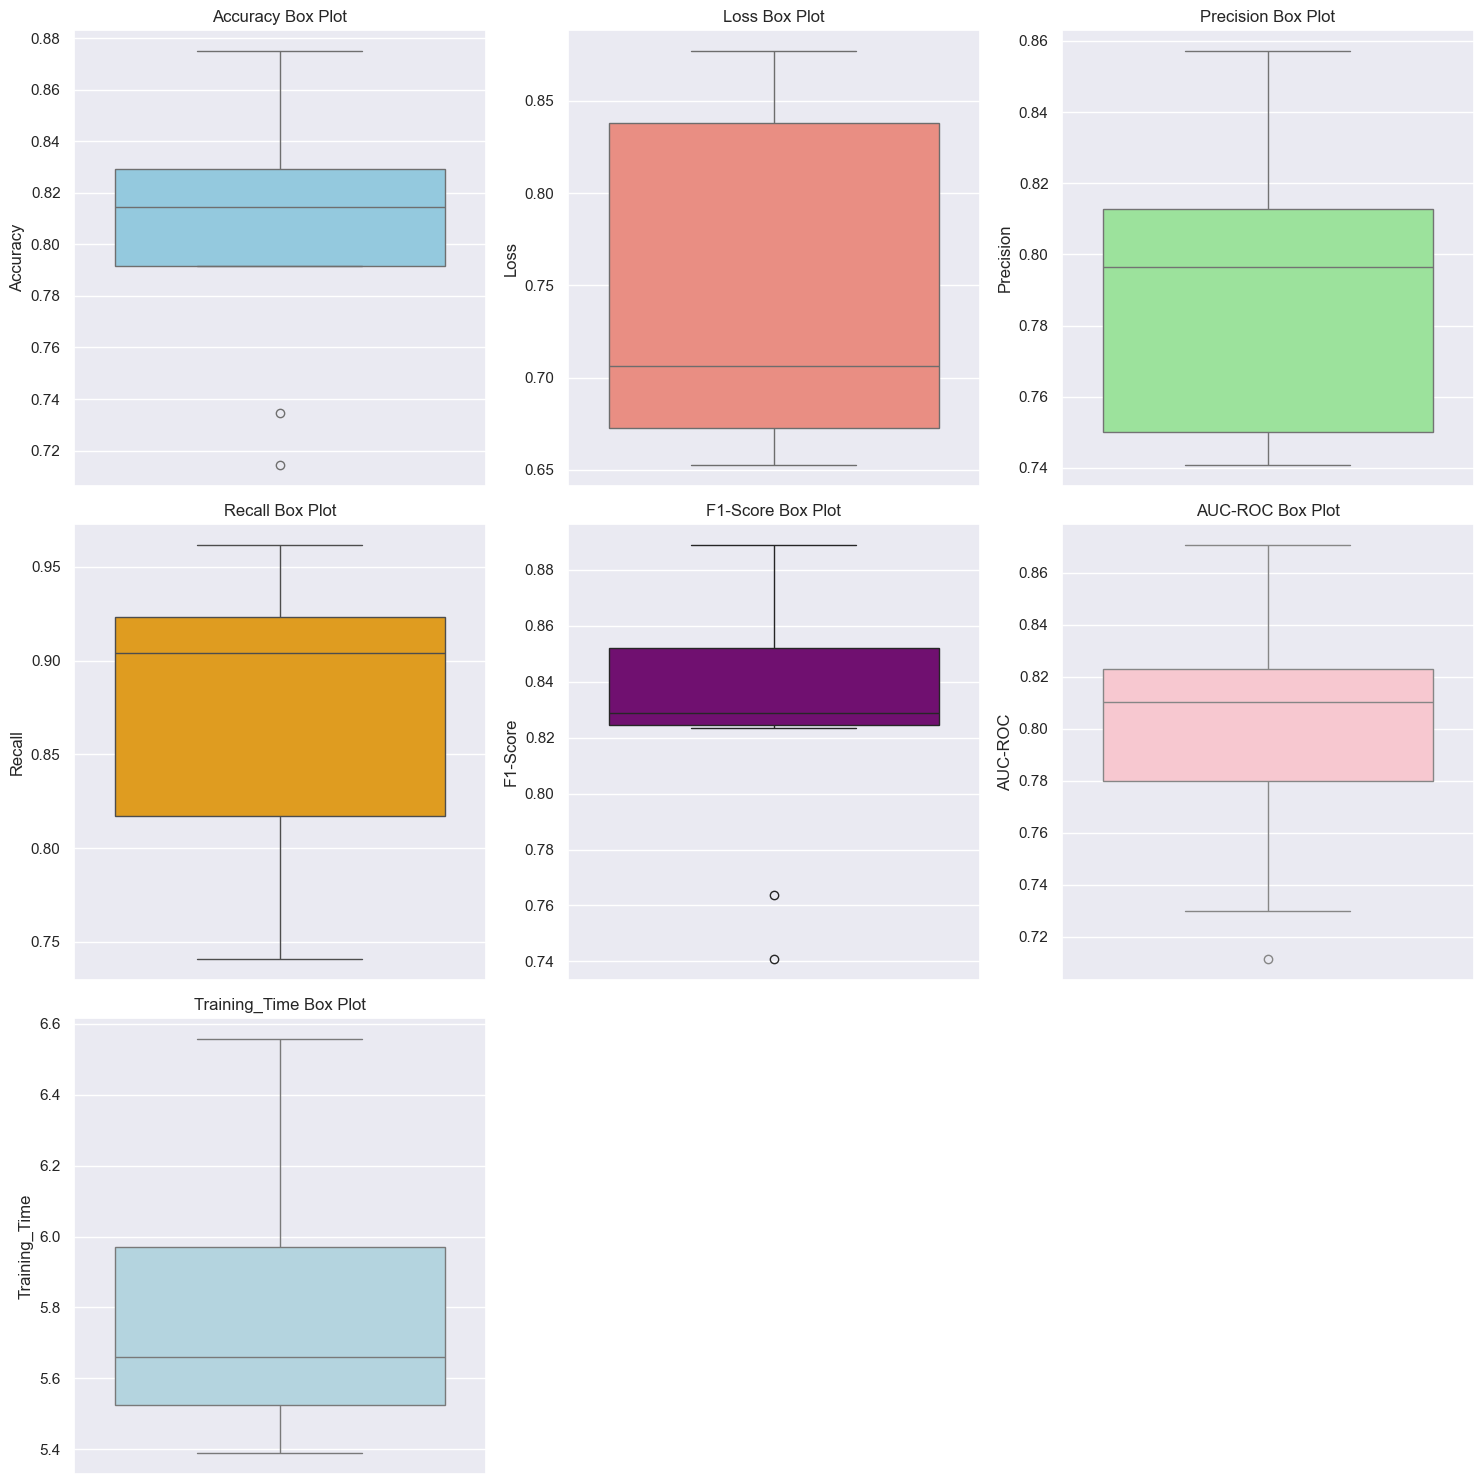

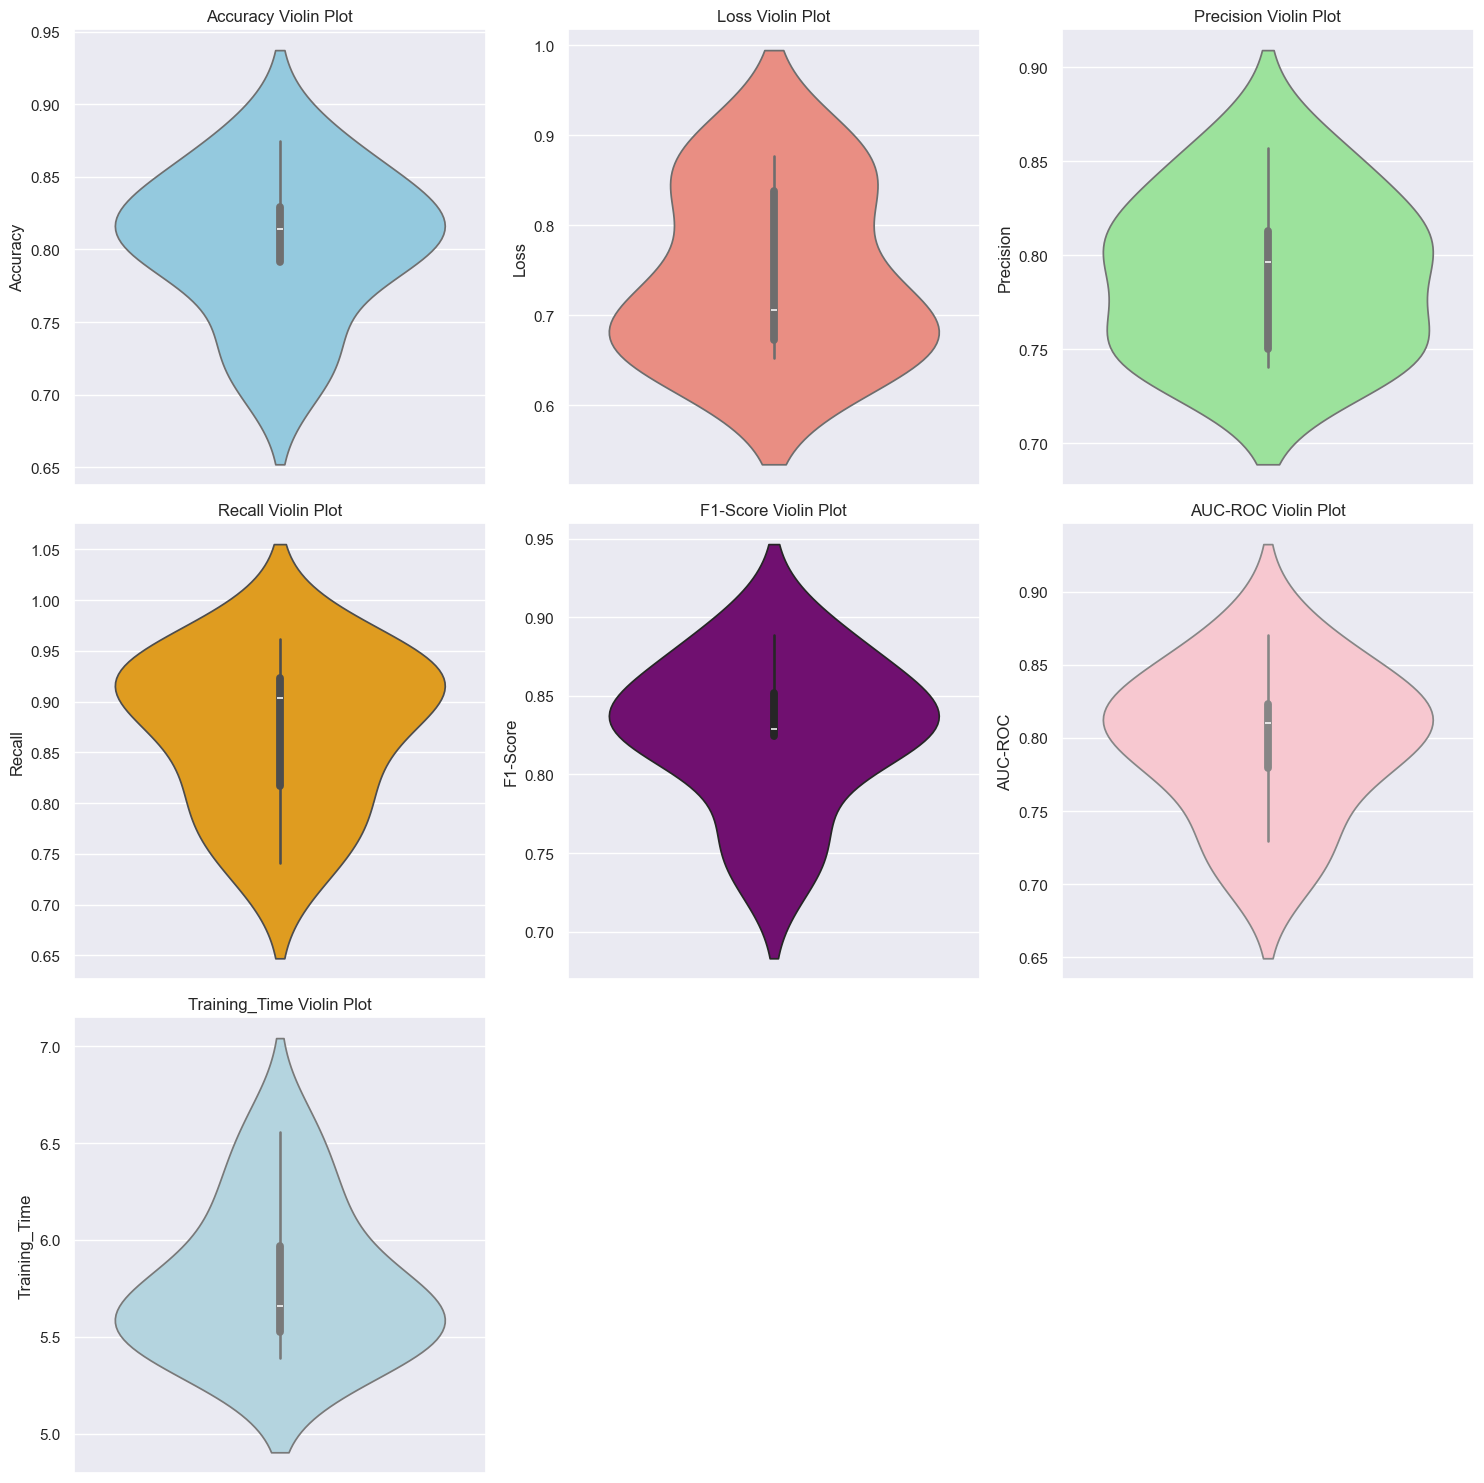

In [37]:
# Plot histograms for each metric with different colors
metrics = ['Accuracy', 'Loss', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC', 'Training_Time']
colors = ['skyblue', 'salmon', 'lightgreen', 'orange', 'purple', 'pink', 'lightblue']

plt.figure(figsize=(15, 15))
for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 3, i)
    sns.histplot(results_df_mlp[metric], bins=10, kde=True, color=colors[i-1])
    plt.title(f'{metric} Distribution')
    plt.xlabel(metric)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Plot box plots for each metric with different colors
plt.figure(figsize=(15, 15))
for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(data=results_df_mlp, y=metric, color=colors[i-1])
    plt.title(f'{metric} Box Plot')

plt.tight_layout()
plt.show()

# Plot violin plots for each metric with different colors
plt.figure(figsize=(15, 15))
for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 3, i)
    sns.violinplot(data=results_df_mlp, y=metric, color=colors[i-1])
    plt.title(f'{metric} Violin Plot')

plt.tight_layout()
plt.show()

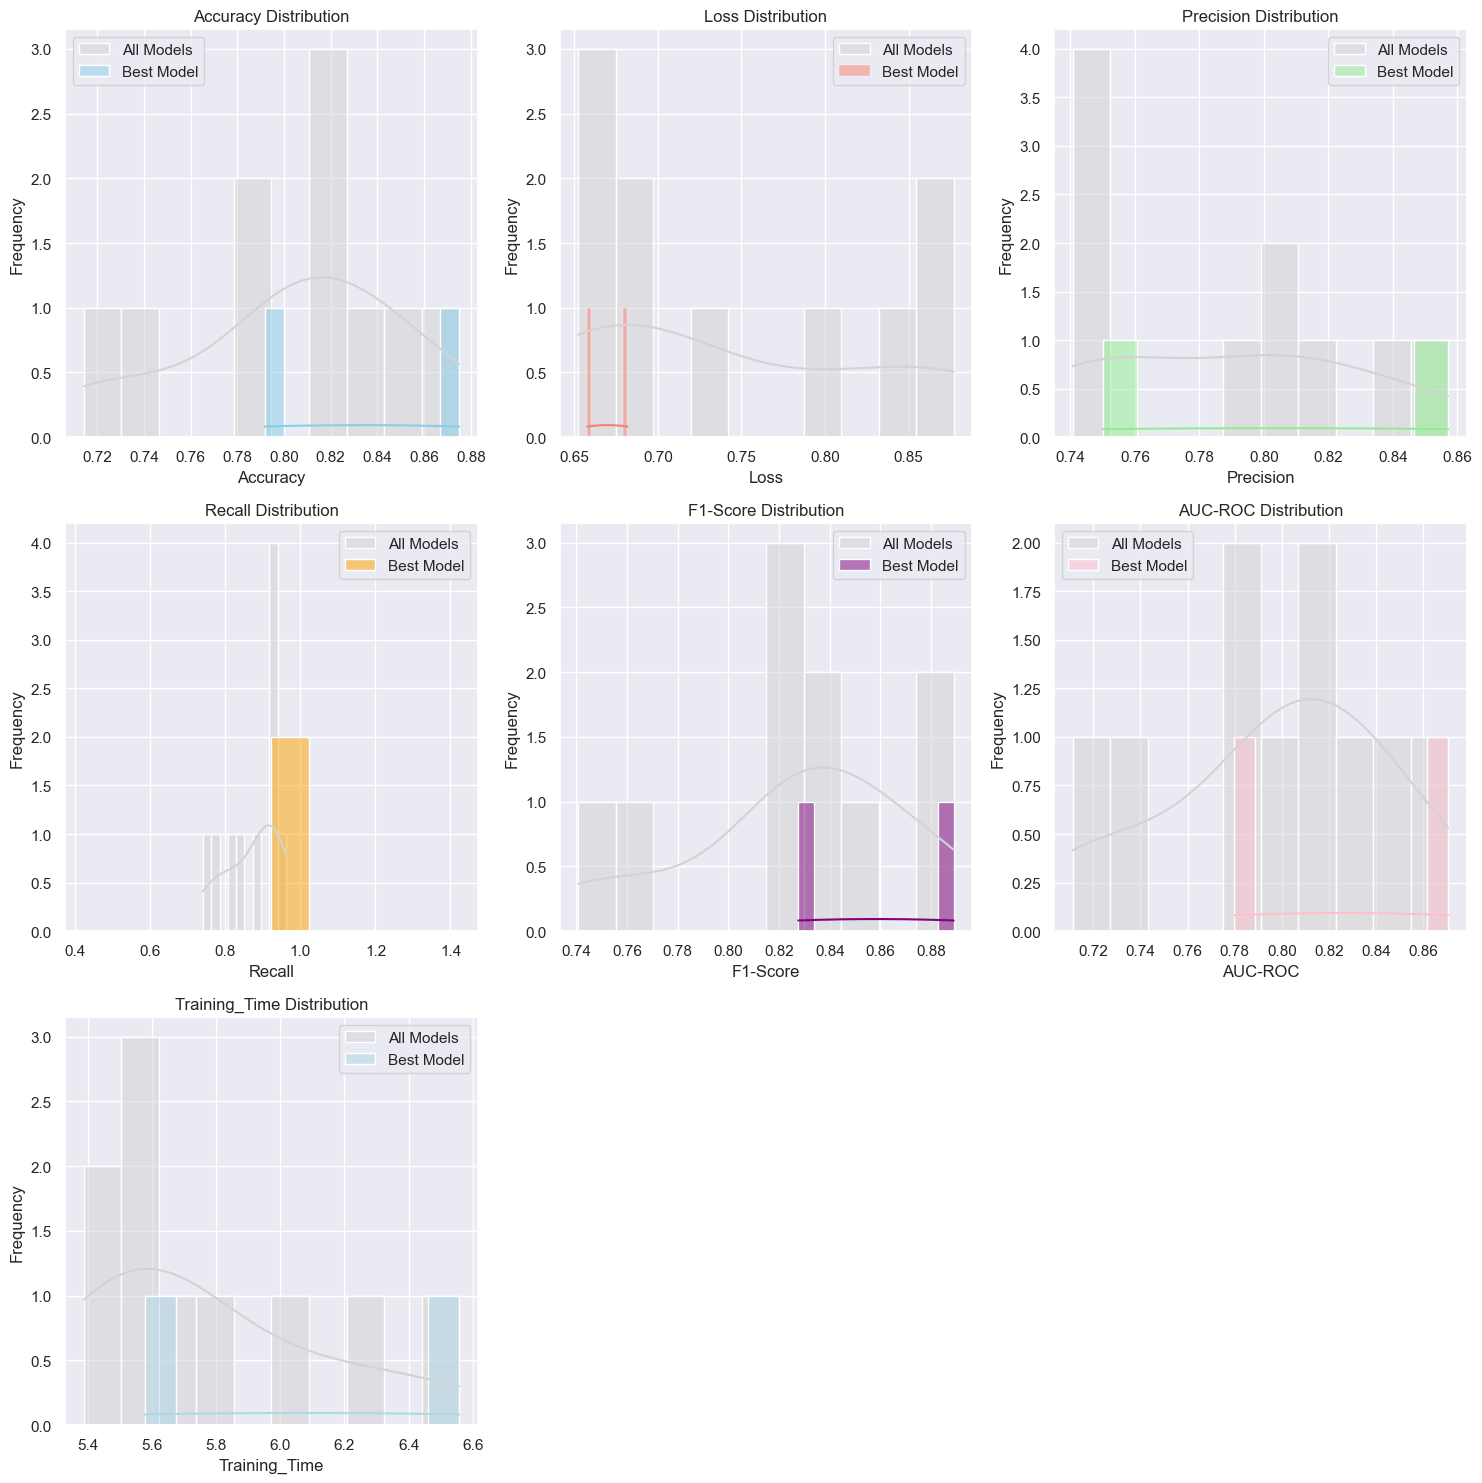

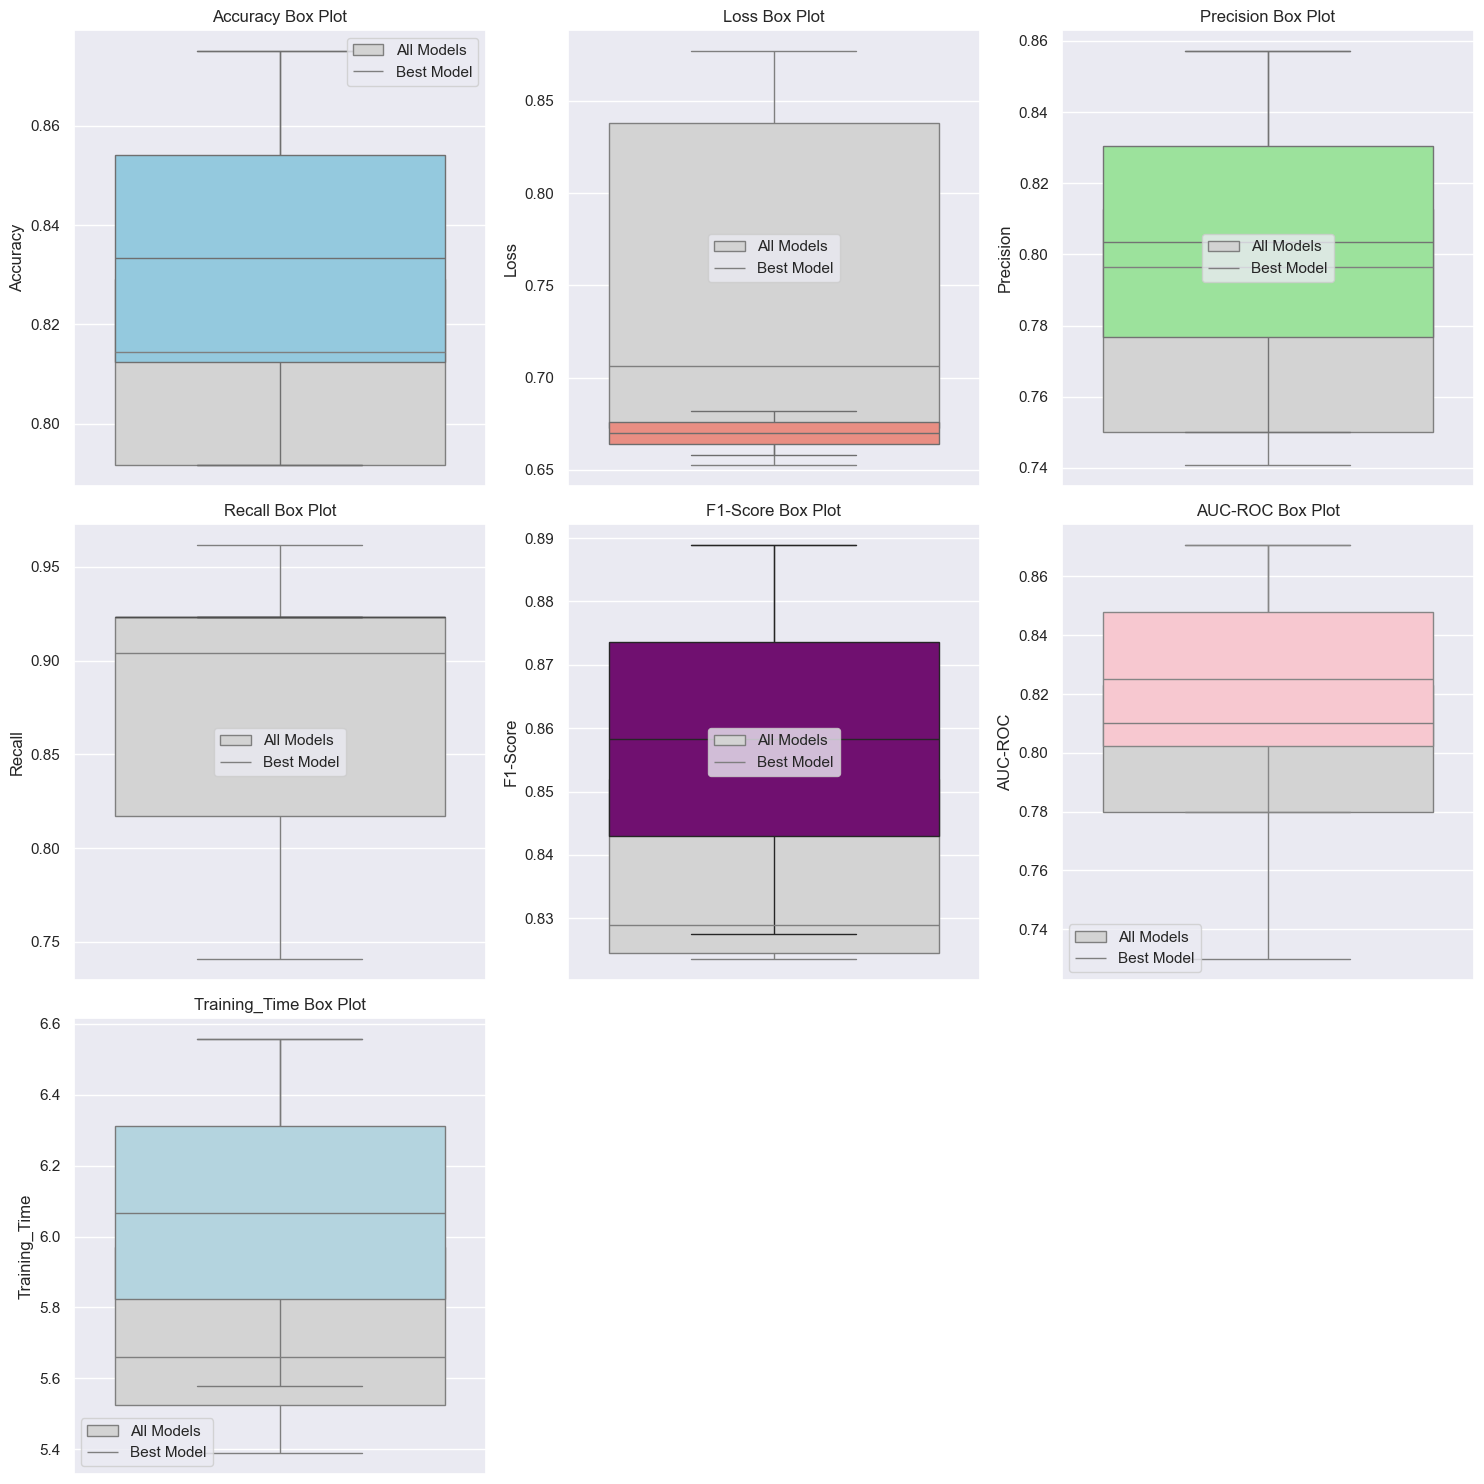

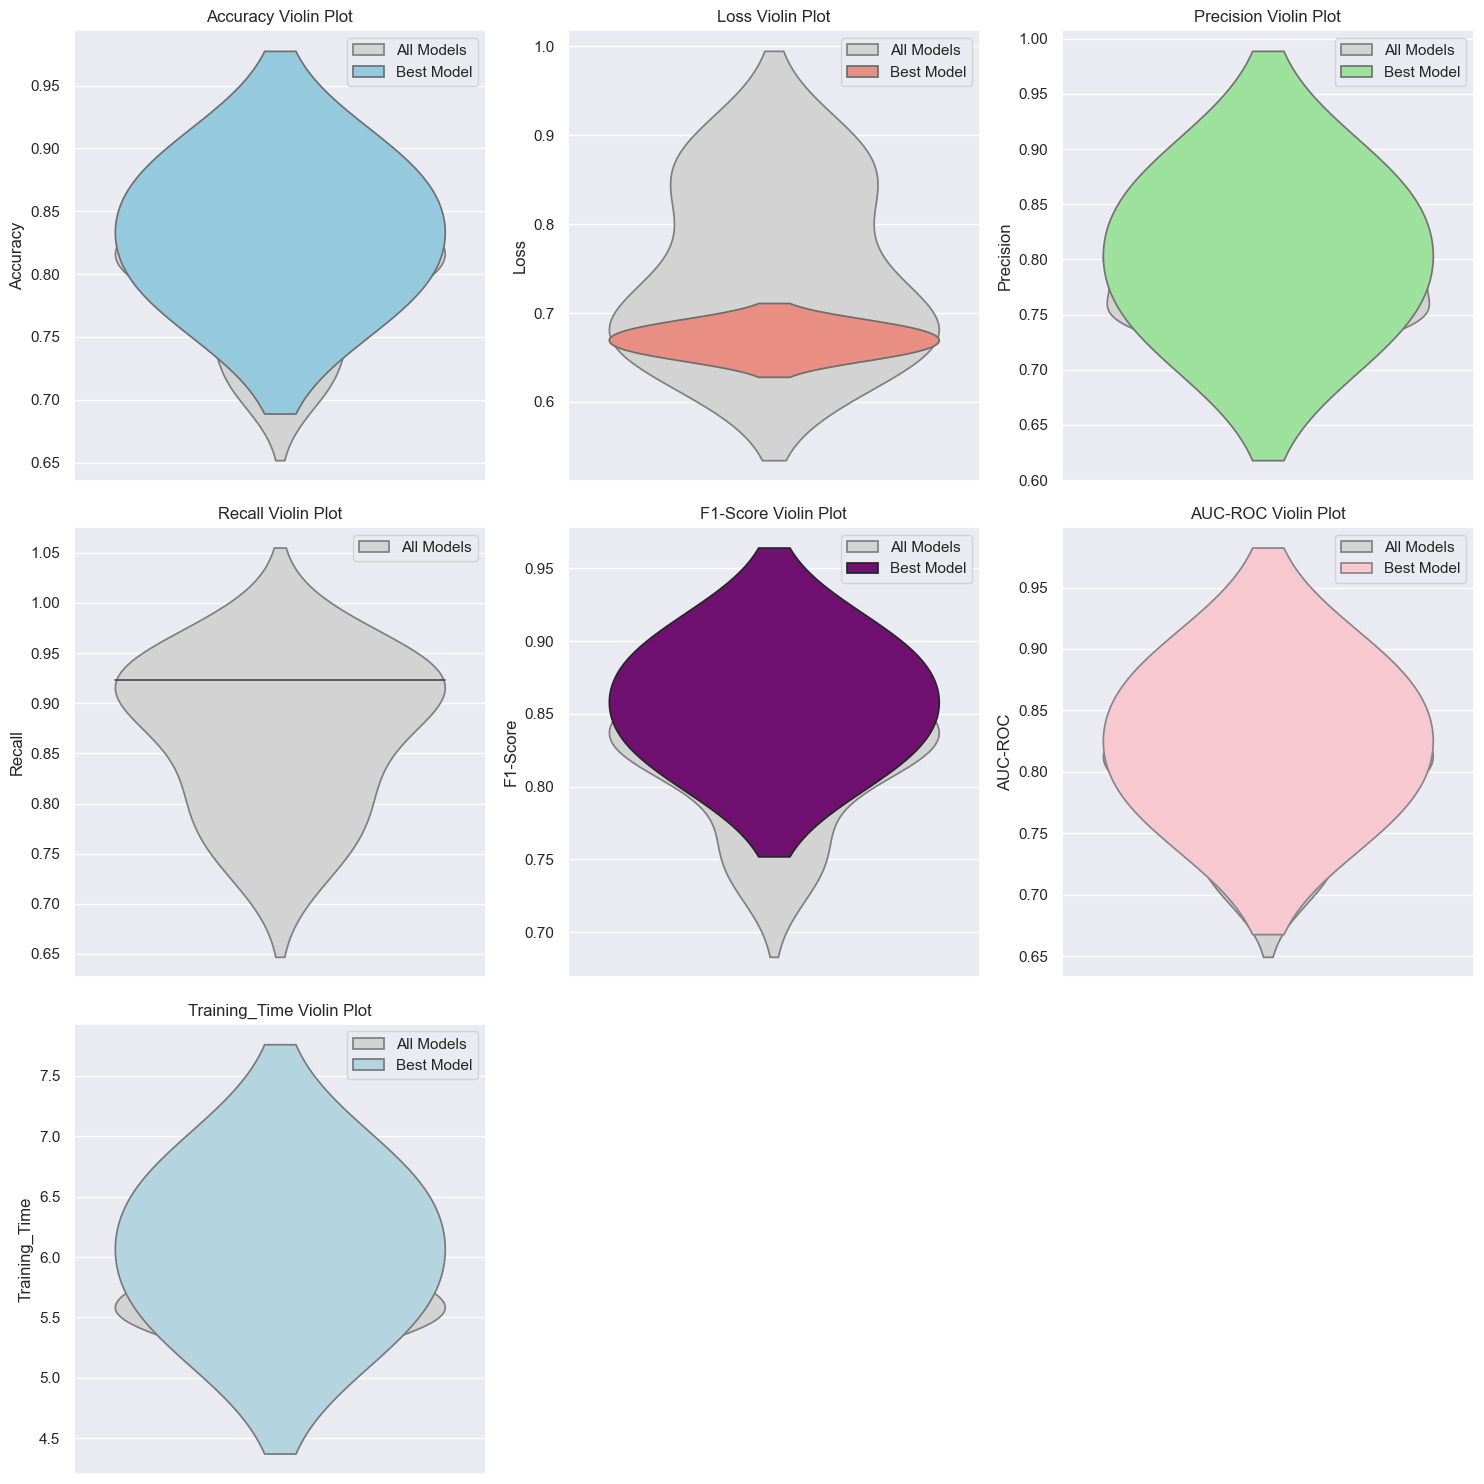

In [38]:
# Filter results_df_mlp for the best model
best_model_results_MLP = results_df_mlp[results_df_mlp['Fold'] == best_fold_index_MLP]

# Plot histograms for each metric with different colors for all models
plt.figure(figsize=(15, 15))
for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 3, i)
    sns.histplot(results_df_mlp[metric], bins=10, kde=True, color='lightgrey', label='All Models')
    sns.histplot(best_model_results_MLP[metric], bins=10, kde=True, color=colors[i-1], label='Best Model')
    plt.title(f'{metric} Distribution')
    plt.xlabel(metric)
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()

# Plot box plots for each metric with different colors for all models
plt.figure(figsize=(15, 15))
for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(data=results_df_mlp, y=metric, color='lightgrey', showfliers=False)
    sns.boxplot(data=best_model_results_MLP, y=metric, color=colors[i-1], showfliers=False)
    plt.title(f'{metric} Box Plot')
    plt.ylabel(metric)
    plt.legend(['All Models', 'Best Model'])

plt.tight_layout()
plt.show()

# Plot violin plots for each metric with different colors for all models
plt.figure(figsize=(15, 15))
for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 3, i)
    sns.violinplot(data=results_df_mlp, y=metric, color='lightgrey', inner=None, label='All Models')
    sns.violinplot(data=best_model_results_MLP, y=metric, color=colors[i-1], inner=None, label='Best Model')
    plt.title(f'{metric} Violin Plot')
    plt.ylabel(metric)
    plt.legend()

plt.tight_layout()
plt.show()


In [39]:
# Summary statistics
print("\nSummary Statistics:")
display(results_df_mlp.describe())


Summary Statistics:


Accuracy       Loss  Precision     Recall   F1-Score    AUC-ROC  \
count  10.000000  10.000000  10.000000  10.000000  10.000000  10.000000   
mean    0.803997   0.747123   0.790225   0.871083   0.827286   0.797794   
std     0.049386   0.093406   0.041137   0.074172   0.045733   0.049098   
min     0.714286   0.652400   0.740741   0.740741   0.740741   0.711279   
25%     0.791667   0.672492   0.750000   0.817308   0.824544   0.779720   
50%     0.814413   0.706209   0.796552   0.903846   0.828887   0.810163   
75%     0.829082   0.837862   0.812724   0.923077   0.851948   0.823104   
max     0.875000   0.876962   0.857143   0.961538   0.888889   0.870629   

       Training_Time  
count      10.000000  
mean        5.781218  
std         0.384081  
min         5.388199  
25%         5.525815  
50%         5.659444  
75%         5.970001  
max         6.557275

In [40]:
display(results_df_mlp)

Fold Early_Stopping  Accuracy      Loss  Precision    Recall  F1-Score  \
0    1      (5, True)  0.734694  0.790409   0.750000  0.777778  0.763636   
1    1    (10, False)  0.714286  0.876406   0.740741  0.740741  0.740741   
2    2      (5, True)  0.816327  0.729758   0.814815  0.846154  0.830189   
3    2    (10, False)  0.816327  0.682660   0.840000  0.807692  0.823529   
4    3      (5, True)  0.875000  0.657790   0.857143  0.923077  0.888889   
5    3    (10, False)  0.791667  0.681766   0.750000  0.923077  0.827586   
6    4      (5, True)  0.812500  0.876962   0.793103  0.884615  0.836364   
7    4    (10, False)  0.791667  0.853680   0.750000  0.923077  0.827586   
8    5      (5, True)  0.833333  0.652400   0.800000  0.923077  0.857143   
9    5    (10, False)  0.854167  0.669401   0.806452  0.961538  0.877193   

    AUC-ROC  Training_Time  
0  0.729798       6.040070  
1  0.711279       5.759793  
2  0.814381       5.595933  
3  0.816890       6.246135  
4  0.870629       6.557275  
5  0.779720       5.578233  
6  0.805944       5.722955  
7  0.779720       5.388199  
8  0.825175       5.508342  
9  0.844406       5.415242

2.  SVM Architecture Model

In [41]:
# Initialize necessary variables
best_accuracy_SVM = 0.0
best_model_SVM = None
best_confusion_matrix = None
best_precision = 0.0
best_recall = 0.0
best_f1_score = 0.0
best_auc_roc = 0.0
fold_histories_SVM = {}

# Initialize DataFrame to store results
results_df_svm = pd.DataFrame(columns=['Fold', 'Early_Stopping', 'Accuracy', 'Loss', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC', 'Training_Time'])

In [42]:
# Perform grid search
for fold_index, (train_index, val_index) in enumerate(kfold.split(x_train, y_train), 1):
    print(f"\nFold {fold_index}:")

    x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Apply SMOTE for data augmentation
    smote = SMOTE(random_state=42)
    x_train_fold_smote, y_train_fold_smote = smote.fit_resample(x_train_fold, y_train_fold)

    accuracies_SVM = []
    losses_SVM = []
    precisions_SVM = []
    recalls_SVM = []
    f1_scores_SVM = []
    auc_rocs_SVM = []
    training_times_SVM = []

    for early_stopping_param in early_stopping_params:
        # Define your model architecture as a logistic Support Vector Machine
        model_SVM = Sequential([
            Dense(1, activation='linear', input_shape=(x_train.shape[1],)),
            Dense(1, activation='sigmoid')
        ])

        # Compile the model with binary cross-entropy loss
        model_SVM.compile(optimizer='Adam', loss=tf.keras.losses.Hinge(), metrics=['accuracy'])

        # Define early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_param[0], restore_best_weights=early_stopping_param[1])

        # Train the model and measure training time
        start_time = time.time()
        history = model_SVM.fit(x_train_fold_smote, y_train_fold_smote, epochs=75, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)
        training_time = time.time() - start_time
        training_times_SVM.append(training_time)

        # Evaluate the model on validation data
        eval_loss, accuracy_SVM = model_SVM.evaluate(x_val_fold, y_val_fold)
        accuracies_SVM.append(accuracy_SVM)
        losses_SVM.append(eval_loss)

        # Append results to the DataFrame
        results_df_svm = pd.concat([results_df_svm, pd.DataFrame({
            'Fold': [fold_index],
            'Early_Stopping': [early_stopping_param],
            'Accuracy': [accuracy_SVM],
            'Loss': [eval_loss],
            'Precision': [precision],
            'Recall': [recall],
            'F1-Score': [f1],
            'AUC-ROC': [auc],
            'Training_Time': [training_time]
        })], ignore_index=True)

        print(f"Early Stopping: {early_stopping_param}, Accuracy = {accuracy_MLP:.4f}, Loss = {eval_loss:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1-Score = {f1:.4f}, AUC-ROC = {auc:.4f}, Training Time = {training_time:.2f} seconds")

        # Update lists for histograms
        accuracy_list.extend(accuracies_SVM)
        loss_list.extend(losses_SVM)
        precision_list.extend(precisions_SVM)
        recall_list.extend(recalls_SVM)
        f1_list.extend(f1_scores_SVM)
        auc_list.extend(auc_rocs_SVM)
        training_time_list.extend(training_times_SVM)

        # Calculate mean accuracy and loss
        mean_accuracy_SVM = np.mean(accuracies_SVM)
        mean_loss_SVM = np.mean(losses_SVM)

        # Store training history
        fold_histories_SVM[fold_index] = history

        # Update best parameters if the mean accuracy is higher
        if mean_accuracy_SVM > best_accuracy_SVM:
            best_accuracy_SVM = mean_accuracy_SVM
            best_model_SVM = model_SVM

# Print best parameters and mean accuracy
print("Best Mean Accuracy:", best_accuracy_SVM)

# Save the best trained model to disk
if best_model_SVM is not None:
    best_model_SVM.save('saved_model/SVM_Model.h5')

# Find the best model based on validation accuracy
best_fold_index_SVM = results_df_svm.loc[results_df_svm['Accuracy'].idxmax()]['Fold']
best_model_history_SVM = fold_histories_SVM[best_fold_index_SVM]


Fold 1:


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5789 - loss: 0.7037 
Early Stopping: (5, True), Accuracy = 0.8542, Loss = 0.7172, Precision = 0.8065, Recall = 0.9615, F1-Score = 0.8772, AUC-ROC = 0.8444, Training Time = 4.83 seconds


C:\Users\piyus\AppData\Local\Temp\ipykernel_21480\1871083679.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df_svm = pd.concat([results_df_svm, pd.DataFrame({


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7366 - loss: 0.5595 
Early Stopping: (10, False), Accuracy = 0.8542, Loss = 0.5835, Precision = 0.8065, Recall = 0.9615, F1-Score = 0.8772, AUC-ROC = 0.8444, Training Time = 4.66 seconds

Fold 2:


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6509 - loss: 0.6615 
Early Stopping: (5, True), Accuracy = 0.8542, Loss = 0.6642, Precision = 0.8065, Recall = 0.9615, F1-Score = 0.8772, AUC-ROC = 0.8444, Training Time = 4.70 seconds
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7294 - loss: 0.6146 
Early Stopping: (10, False), Accuracy = 0.8542, Loss = 0.5969, Precision = 0.8065, Recall = 0.9615, F1-Score = 0.8772, AUC-ROC = 0.8444, Training Time = 4.68 seconds

Fold 3:


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8715 - loss: 0.4312 
Early Stopping: (5, True), Accuracy = 0.8542, Loss = 0.4395, Precision = 0.8065, Recall = 0.9615, F1-Score = 0.8772, AUC-ROC = 0.8444, Training Time = 5.12 seconds
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6632 - loss: 0.6780 
Early Stopping: (10, False), Accuracy = 0.8542, Loss = 0.6678, Precision = 0.8065, Recall = 0.9615, F1-Score = 0.8772, AUC-ROC = 0.8444, Training Time = 4.82 seconds

Fold 4:


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6528 - loss: 0.5878 
Early Stopping: (5, True), Accuracy = 0.8542, Loss = 0.5743, Precision = 0.8065, Recall = 0.9615, F1-Score = 0.8772, AUC-ROC = 0.8444, Training Time = 4.91 seconds
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7014 - loss: 0.6401 
Early Stopping: (10, False), Accuracy = 0.8542, Loss = 0.6232, Precision = 0.8065, Recall = 0.9615, F1-Score = 0.8772, AUC-ROC = 0.8444, Training Time = 4.82 seconds

Fold 5:


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8125 - loss: 0.3455 
Early Stopping: (5, True), Accuracy = 0.8542, Loss = 0.3564, Precision = 0.8065, Recall = 0.9615, F1-Score = 0.8772, AUC-ROC = 0.8444, Training Time = 4.84 seconds
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6528 - loss: 0.6529 


Early Stopping: (10, False), Accuracy = 0.8542, Loss = 0.6466, Precision = 0.8065, Recall = 0.9615, F1-Score = 0.8772, AUC-ROC = 0.8444, Training Time = 5.22 seconds
Best Mean Accuracy: 0.8541666865348816


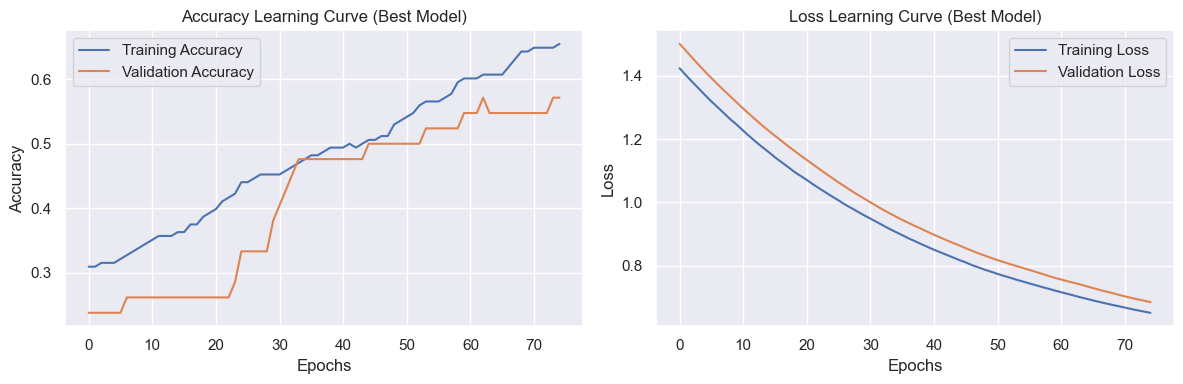

In [43]:
# Plot learning curves for the best model
plt.figure(figsize=(12, 4))

# Accuracy curve
plt.subplot(1, 2, 1)
plt.plot(best_model_history_SVM.history['accuracy'], label='Training Accuracy')
plt.plot(best_model_history_SVM.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Learning Curve (Best Model)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss curve
plt.subplot(1, 2, 2)
plt.plot(best_model_history_SVM.history['loss'], label='Training Loss')
plt.plot(best_model_history_SVM.history['val_loss'], label='Validation Loss')
plt.title('Loss Learning Curve (Best Model)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

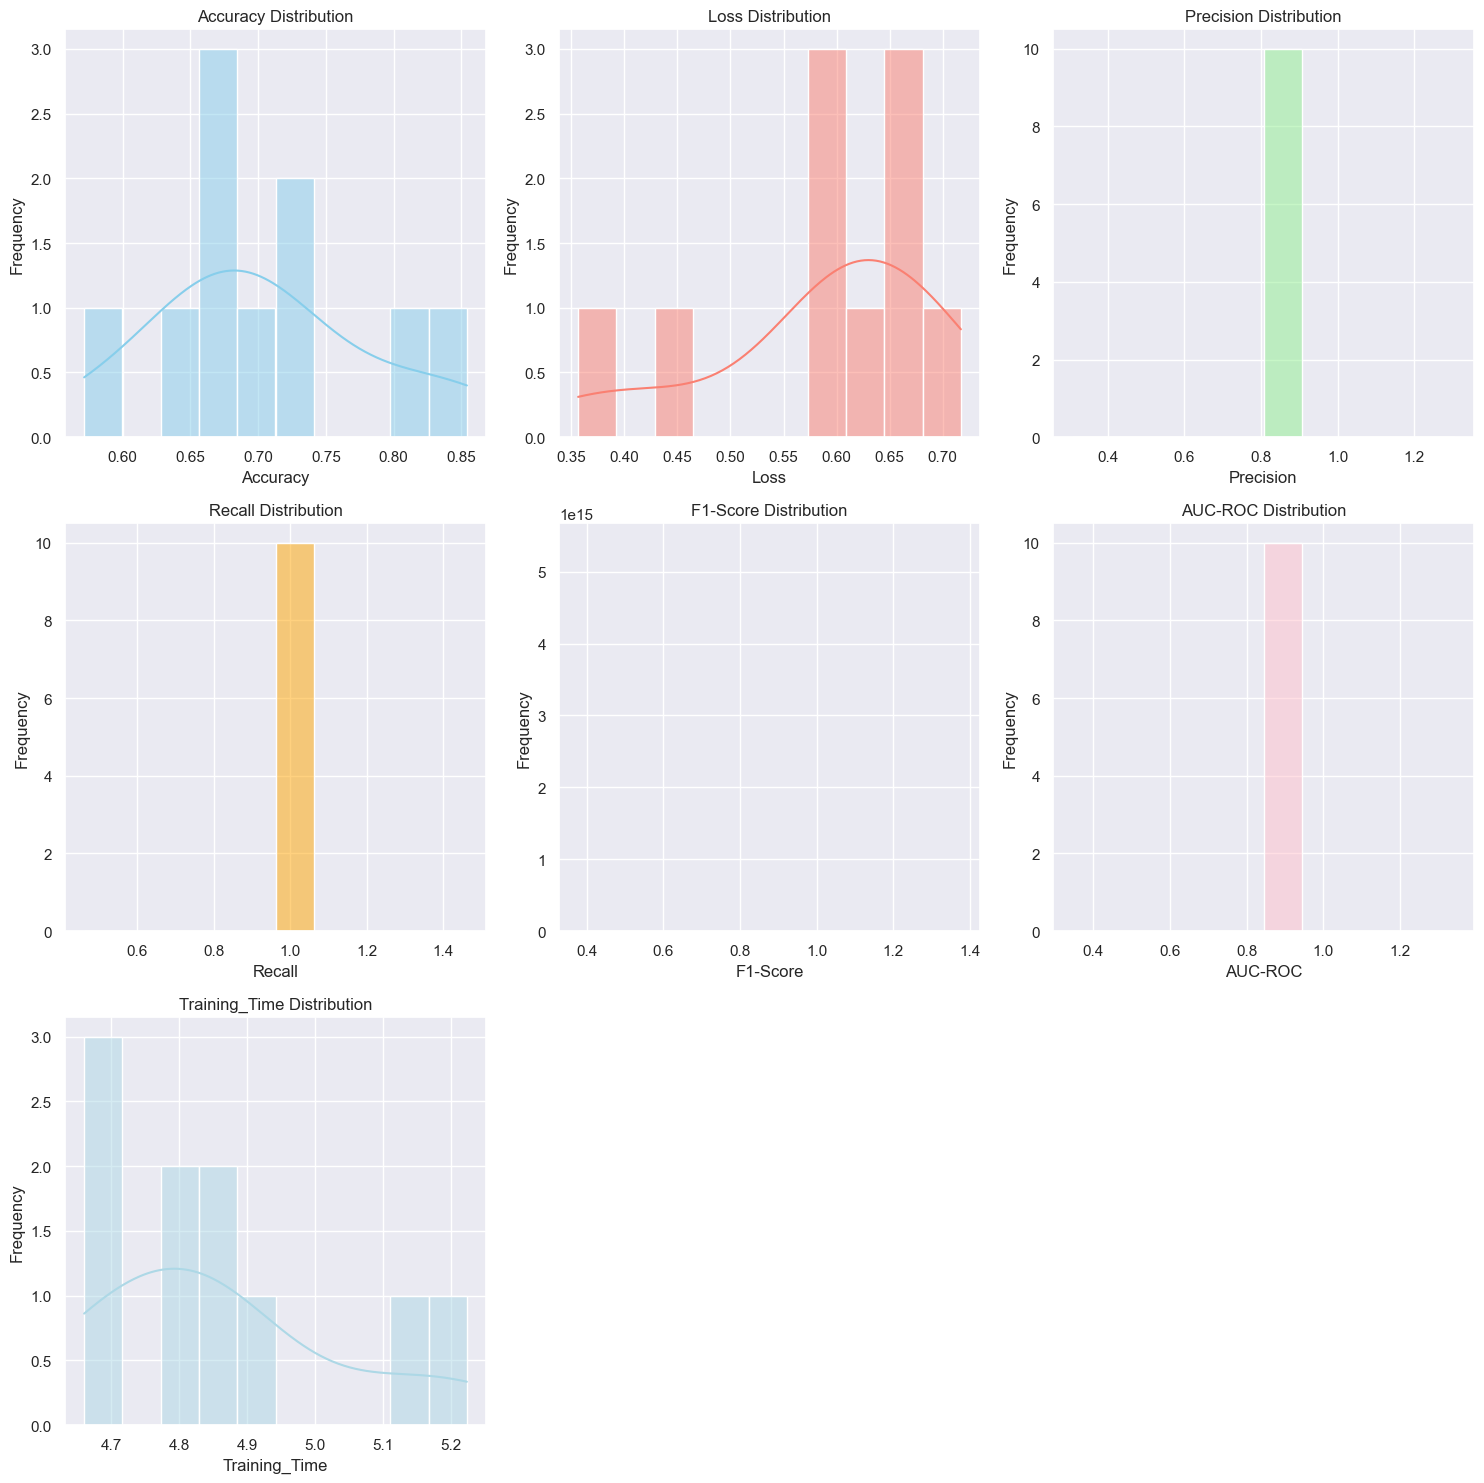

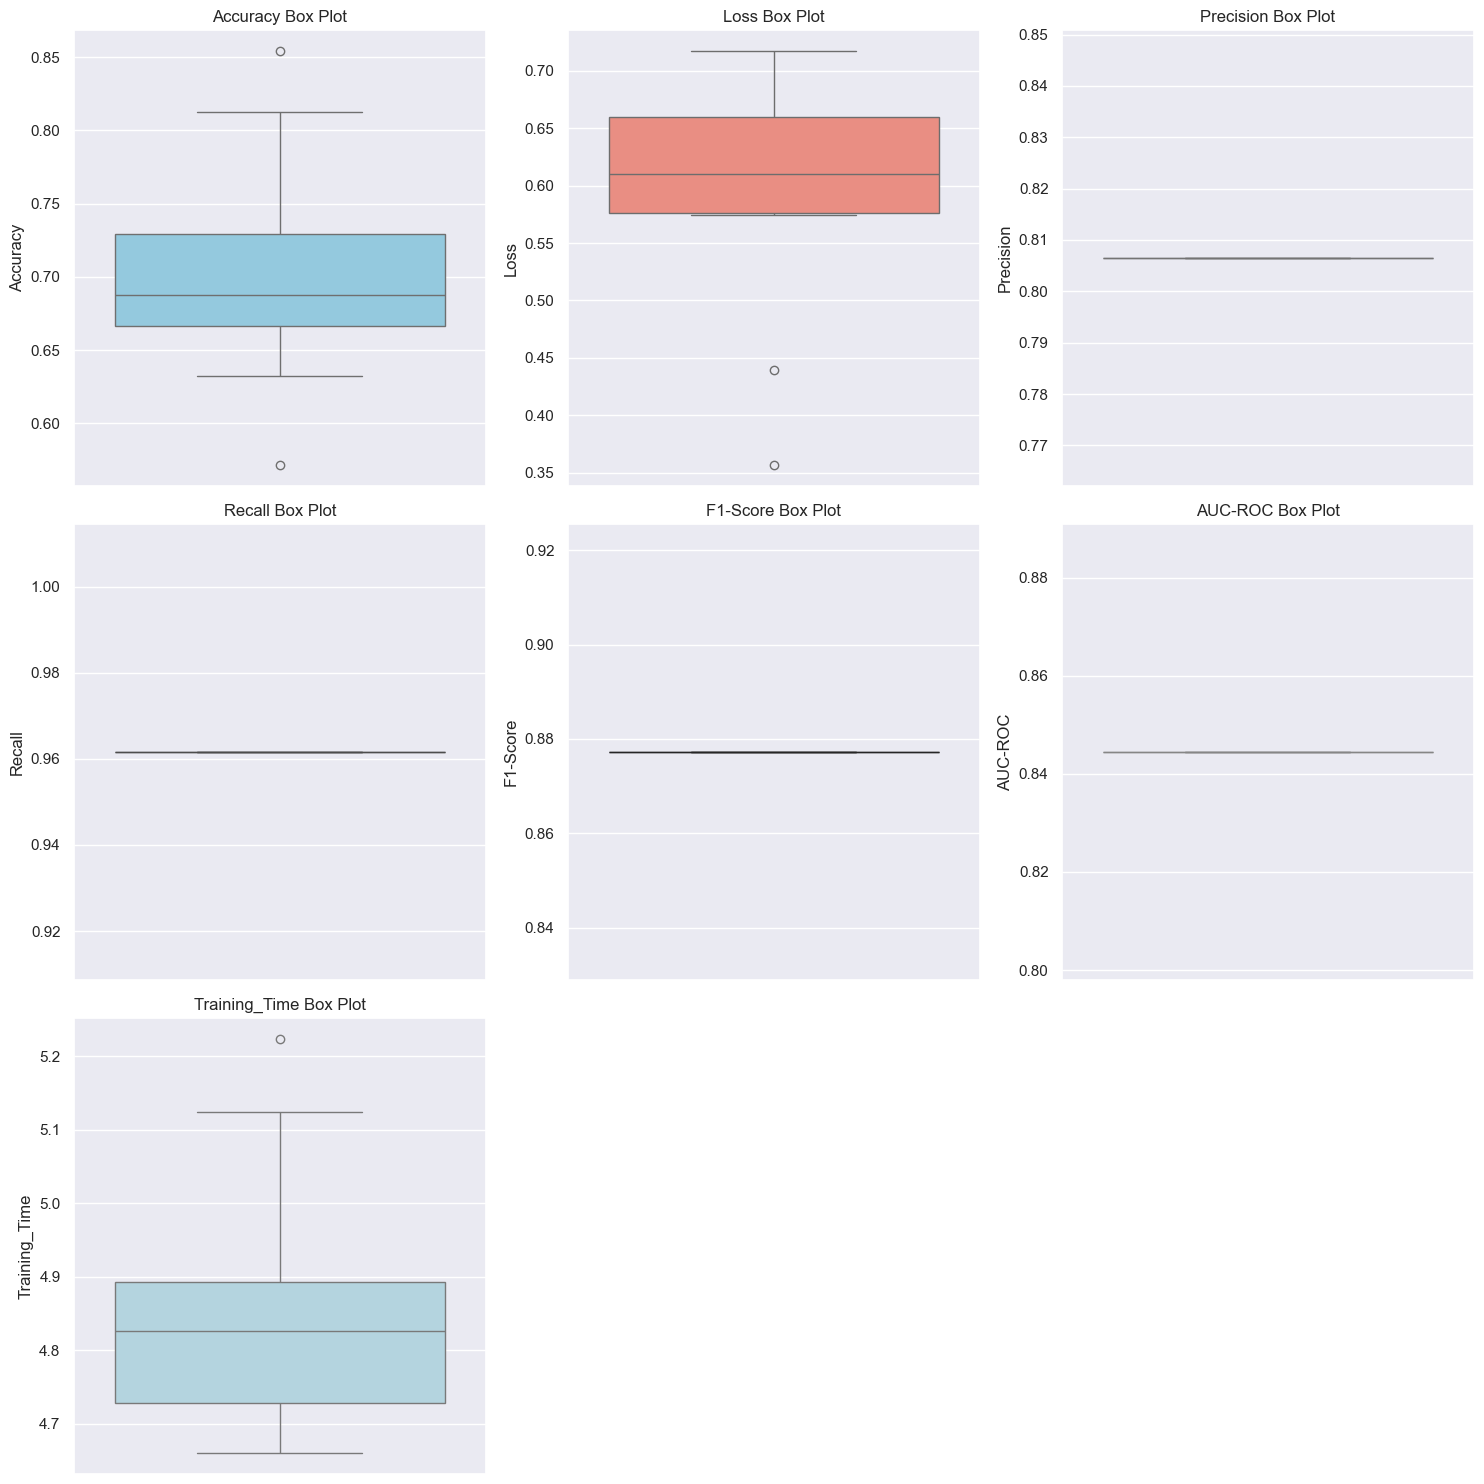

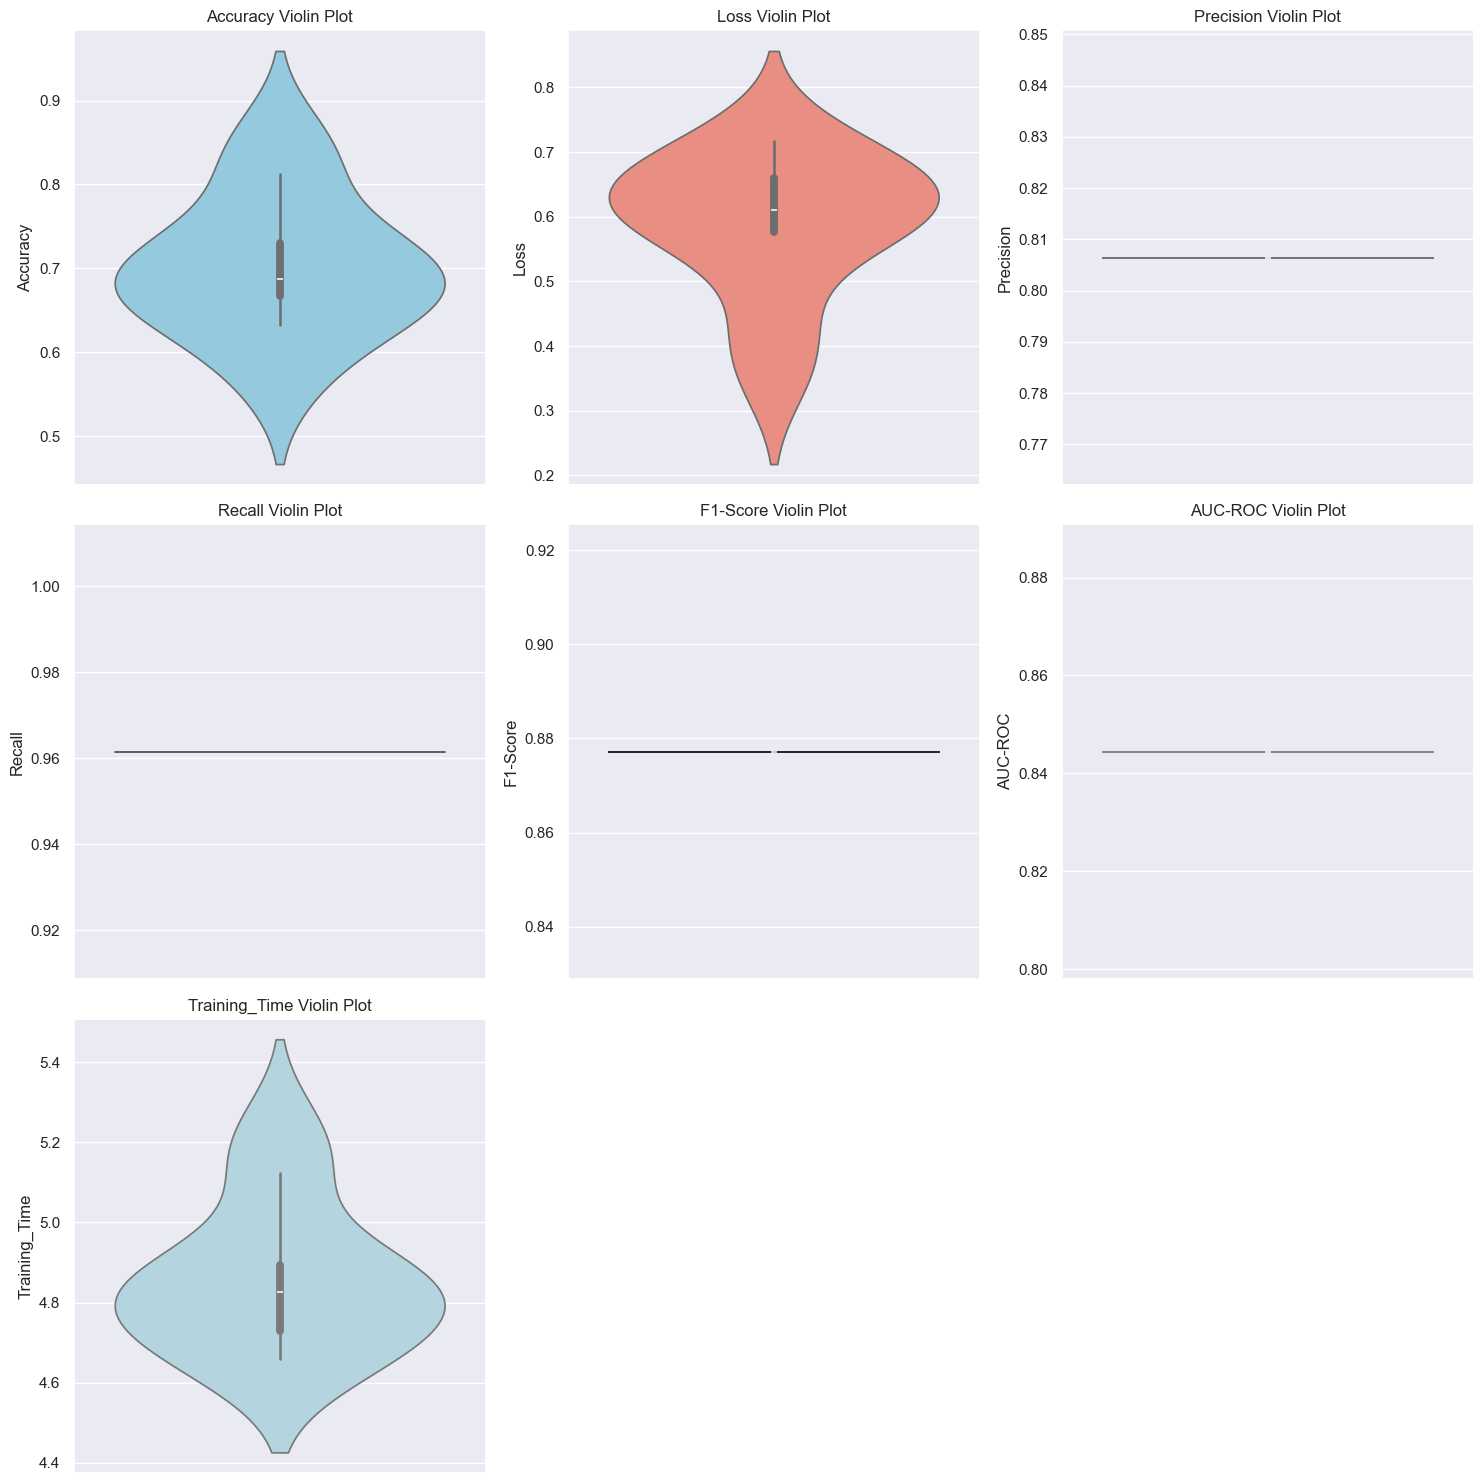

In [44]:
# Plot histograms for each metric with different colors
metrics = ['Accuracy', 'Loss', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC', 'Training_Time']
colors = ['skyblue', 'salmon', 'lightgreen', 'orange', 'purple', 'pink', 'lightblue']

plt.figure(figsize=(15, 15))
for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 3, i)
    sns.histplot(results_df_svm[metric], bins=10, kde=True, color=colors[i-1])
    plt.title(f'{metric} Distribution')
    plt.xlabel(metric)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Plot box plots for each metric with different colors
plt.figure(figsize=(15, 15))
for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(data=results_df_svm, y=metric, color=colors[i-1])
    plt.title(f'{metric} Box Plot')

plt.tight_layout()
plt.show()

# Plot violin plots for each metric with different colors
plt.figure(figsize=(15, 15))
for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 3, i)
    sns.violinplot(data=results_df_svm, y=metric, color=colors[i-1])
    plt.title(f'{metric} Violin Plot')

plt.tight_layout()
plt.show()

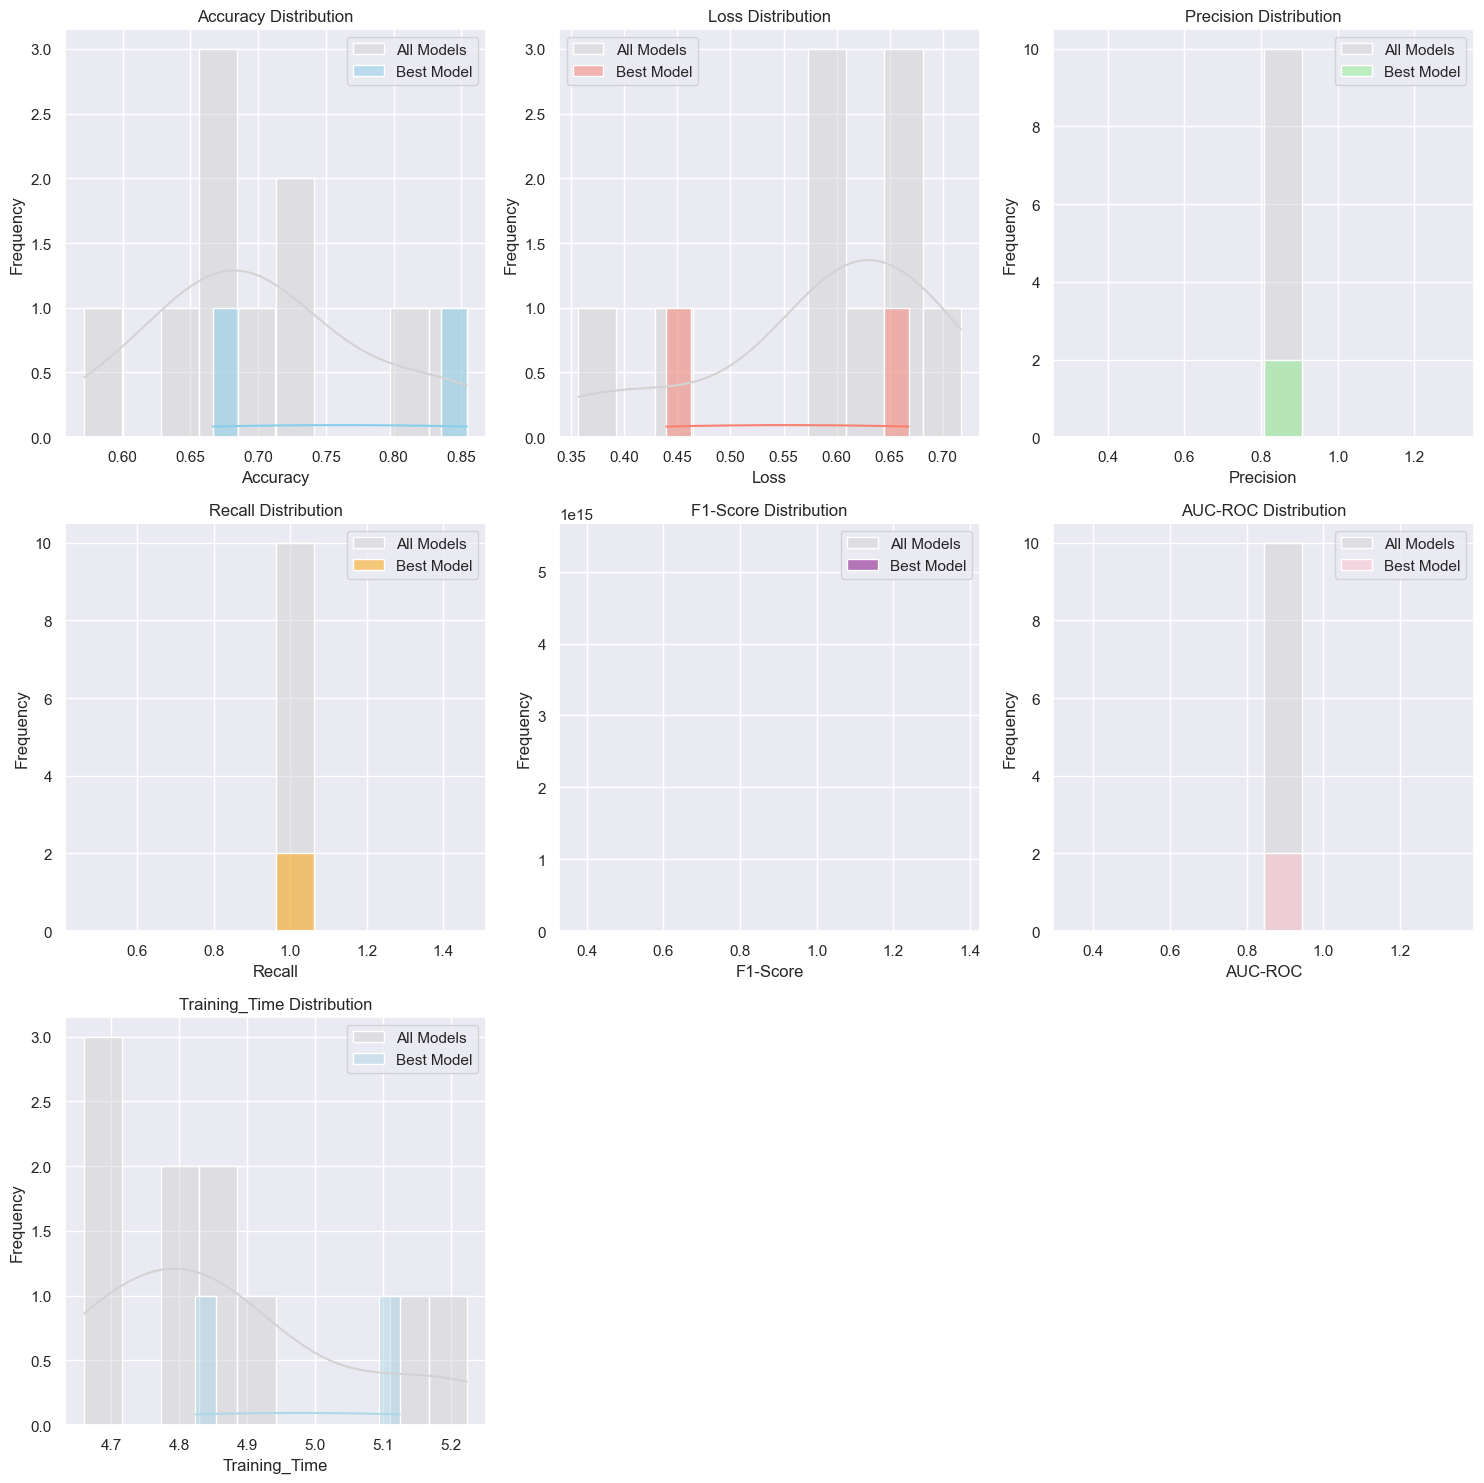

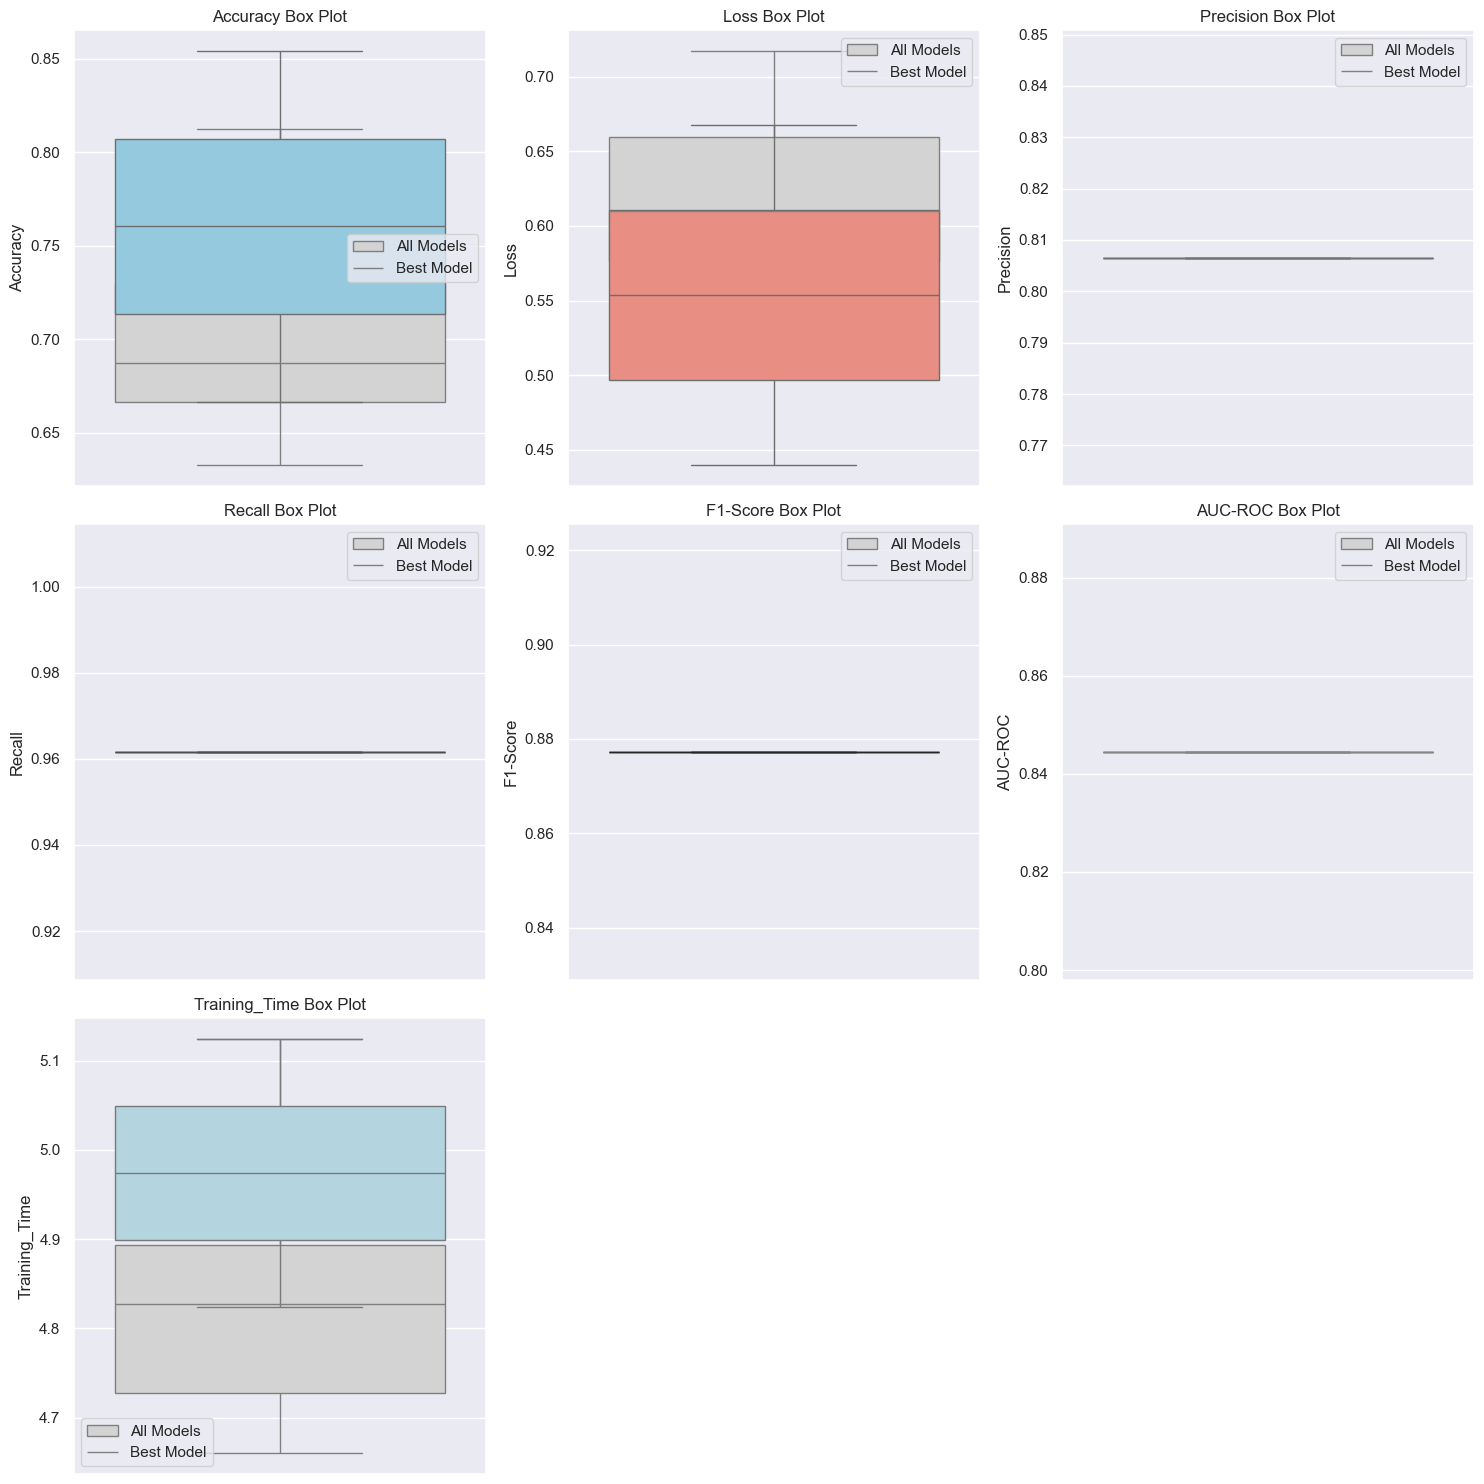

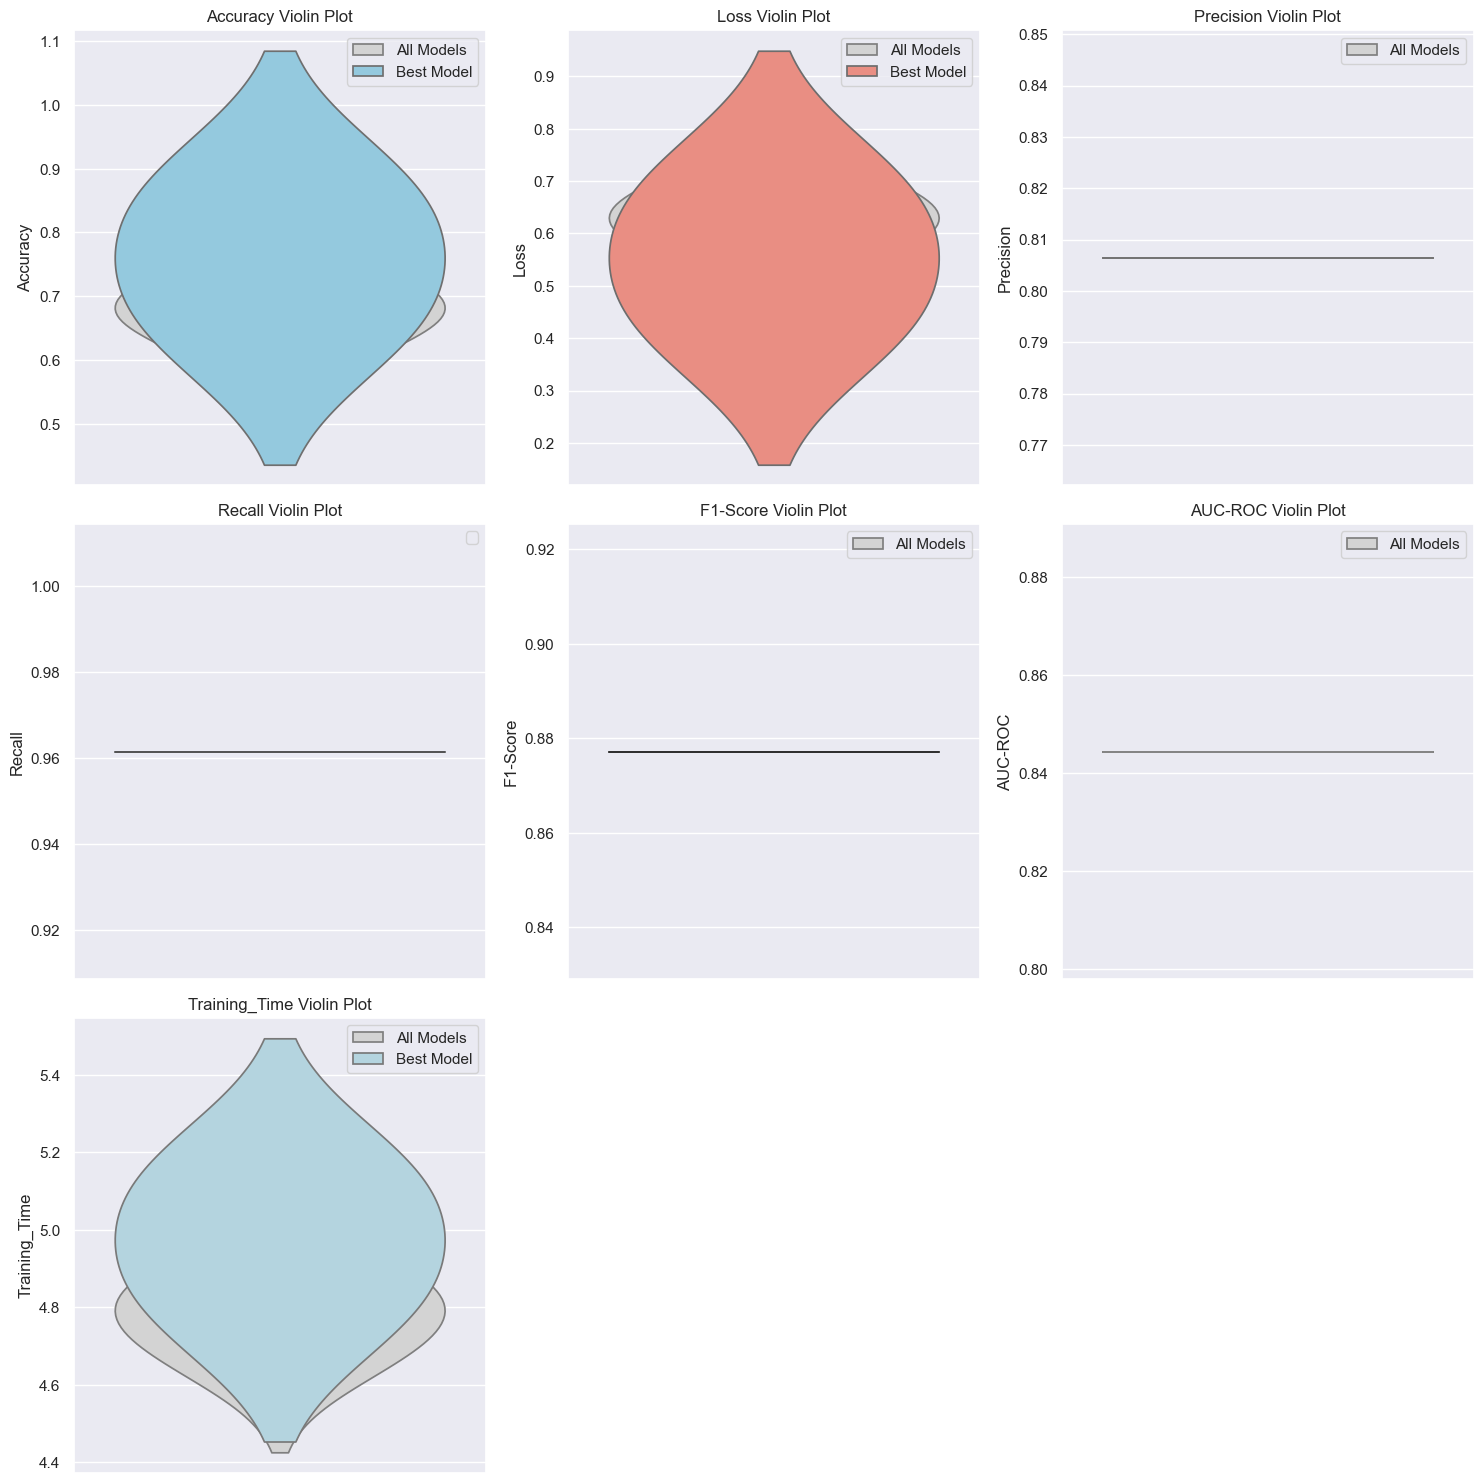

In [45]:
# Filter results_df_mlp for the best model
best_model_results_SVM = results_df_svm[results_df_svm['Fold'] == best_fold_index_MLP]

# Plot histograms for each metric with different colors for all models
plt.figure(figsize=(15, 15))
for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 3, i)
    sns.histplot(results_df_svm[metric], bins=10, kde=True, color='lightgrey', label='All Models')
    sns.histplot(best_model_results_SVM[metric], bins=10, kde=True, color=colors[i-1], label='Best Model')
    plt.title(f'{metric} Distribution')
    plt.xlabel(metric)
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()

# Plot box plots for each metric with different colors for all models
plt.figure(figsize=(15, 15))
for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(data=results_df_svm, y=metric, color='lightgrey', showfliers=False)
    sns.boxplot(data=best_model_results_SVM, y=metric, color=colors[i-1], showfliers=False)
    plt.title(f'{metric} Box Plot')
    plt.ylabel(metric)
    plt.legend(['All Models', 'Best Model'])

plt.tight_layout()
plt.show()

# Plot violin plots for each metric with different colors for all models
plt.figure(figsize=(15, 15))
for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 3, i)
    sns.violinplot(data=results_df_svm, y=metric, color='lightgrey', inner=None, label='All Models')
    sns.violinplot(data=best_model_results_SVM, y=metric, color=colors[i-1], inner=None, label='Best Model')
    plt.title(f'{metric} Violin Plot')
    plt.ylabel(metric)
    plt.legend()

plt.tight_layout()
plt.show()

In [46]:
# Summary statistics
print("\nSummary Statistics:")
display(results_df_svm.describe())


Summary Statistics:


Accuracy       Loss  Precision        Recall      F1-Score    AUC-ROC  \
count  10.000000  10.000000  10.000000  1.000000e+01  1.000000e+01  10.000000   
mean    0.702806   0.586962   0.806452  9.615385e-01  8.771930e-01   0.844406   
std     0.083148   0.110291   0.000000  1.170278e-16  1.170278e-16   0.000000   
min     0.571429   0.356430   0.806452  9.615385e-01  8.771930e-01   0.844406   
25%     0.666667   0.576577   0.806452  9.615385e-01  8.771930e-01   0.844406   
50%     0.687500   0.610047   0.806452  9.615385e-01  8.771930e-01   0.844406   
75%     0.729592   0.659791   0.806452  9.615385e-01  8.771930e-01   0.844406   
max     0.854167   0.717172   0.806452  9.615385e-01  8.771930e-01   0.844406   

       Training_Time  
count      10.000000  
mean        4.860144  
std         0.185348  
min         4.660048  
25%         4.728114  
50%         4.826908  
75%         4.893529  
max         5.223054

In [47]:
display(results_df_svm)

Fold Early_Stopping  Accuracy      Loss  Precision    Recall  F1-Score  \
0    1      (5, True)  0.571429  0.717172   0.806452  0.961538  0.877193   
1    1    (10, False)  0.714286  0.583505   0.806452  0.961538  0.877193   
2    2      (5, True)  0.632653  0.664191   0.806452  0.961538  0.877193   
3    2    (10, False)  0.734694  0.596899   0.806452  0.961538  0.877193   
4    3      (5, True)  0.854167  0.439541   0.806452  0.961538  0.877193   
5    3    (10, False)  0.666667  0.667826   0.806452  0.961538  0.877193   
6    4      (5, True)  0.666667  0.574268   0.806452  0.961538  0.877193   
7    4    (10, False)  0.708333  0.623195   0.806452  0.961538  0.877193   
8    5      (5, True)  0.812500  0.356430   0.806452  0.961538  0.877193   
9    5    (10, False)  0.666667  0.646590   0.806452  0.961538  0.877193   

    AUC-ROC  Training_Time  
0  0.844406       4.829948  
1  0.844406       4.660048  
2  0.844406       4.698622  
3  0.844406       4.675010  
4  0.844406       5.124278  
5  0.844406       4.823868  
6  0.844406       4.912049  
7  0.844406       4.816592  
8  0.844406       4.837970  
9  0.844406       5.223054

3.  Dense Neural Network Model

In [48]:
# Initialize necessary variables
best_accuracy_DNN = 0.0
best_model_DNN = None
best_confusion_matrix = None
best_precision = 0.0
best_recall = 0.0
best_f1_score = 0.0
best_auc_roc = 0.0
fold_histories_DNN = {}

# Initialize DataFrame to store results
results_df_dnn = pd.DataFrame(columns=['Fold', 'Early_Stopping', 'Accuracy', 'Loss', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC', 'Training_Time'])

In [49]:
# Perform grid search
for fold_index, (train_index, val_index) in enumerate(kfold.split(x_train, y_train), 1):
    print(f"\nFold {fold_index}:")

    x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Apply SMOTE for data augmentation
    smote = SMOTE(random_state=42)
    x_train_fold_smote, y_train_fold_smote = smote.fit_resample(x_train_fold, y_train_fold)

    accuracies_DNN = []
    losses_DNN = []
    precisions_DNN = []
    recalls_DNN = []
    f1_scores_DNN = []
    auc_rocs_DNN = []
    training_times_DNN = []

    for early_stopping_param in early_stopping_params:
        # Define your model architecture as a logistic Support Vector Machine
        model_dense = Sequential([
            Dense(256, activation='relu', input_shape=(x_train.shape[1],)),
            Dropout(0.5),
            Dense(128, activation='relu'),
            Dropout(0.4),
            Dense(64, activation='relu'),
            Dropout(0.4),
            Dense(32, activation='relu'),
            Dropout(0.3),
            Dense(16, activation='relu'),
            Dropout(0.3),
            Dense(8, activation='relu'),
            Dropout(0.2),
            Dense(4, activation='relu'),
            Dropout(0.1),
            Dense(1, activation='sigmoid')  # Output layer
        ])

        # Compile the model with binary cross-entropy loss
        model_dense.compile(optimizer='Adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

        # Define early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_param[0], restore_best_weights=early_stopping_param[1])

        # Train the model and measure training time
        start_time = time.time()
        history = model_dense.fit(x_train_fold_smote, y_train_fold_smote, epochs=75, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)
        training_time = time.time() - start_time
        training_times_DNN.append(training_time)

        # Evaluate the model on validation data
        eval_loss, accuracy_DNN = model_dense.evaluate(x_val_fold, y_val_fold)
        accuracies_DNN.append(accuracy_DNN)
        losses_DNN.append(eval_loss)

        # Get predictions for calculating additional metrics
        y_pred = (model_dense.predict(x_val_fold) > 0.5).astype("int32")

        # Calculate additional metrics
        precision = precision_score(y_val_fold, y_pred)
        recall = recall_score(y_val_fold, y_pred)
        f1 = f1_score(y_val_fold, y_pred)
        auc = roc_auc_score(y_val_fold, y_pred)

        precisions_DNN.append(precision)
        recalls_DNN.append(recall)
        f1_scores_DNN.append(f1)
        auc_rocs_DNN.append(auc)

        # Compute confusion matrix
        cm = confusion_matrix(y_val_fold, y_pred)
        confusion_matrices.append(cm)

        # Append results to the DataFrame
        results_df_dnn = pd.concat([results_df_dnn, pd.DataFrame({
            'Fold': [fold_index],
            'Early_Stopping': [early_stopping_param],
            'Accuracy': [accuracy_DNN],
            'Loss': [eval_loss],
            'Precision': [precision],
            'Recall': [recall],
            'F1-Score': [f1],
            'AUC-ROC': [auc],
            'Training_Time': [training_time]
        })], ignore_index=True)

        print(f"Early Stopping: {early_stopping_param}, Accuracy = {accuracy_DNN:.4f}, Loss = {eval_loss:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1-Score = {f1:.4f}, AUC-ROC = {auc:.4f}, Training Time = {training_time:.2f} seconds")

        # Update lists for histograms
        accuracy_list.extend(accuracies_DNN)
        loss_list.extend(losses_DNN)
        precision_list.extend(precisions_DNN)
        recall_list.extend(recalls_DNN)
        f1_list.extend(f1_scores_DNN)
        auc_list.extend(auc_rocs_DNN)
        training_time_list.extend(training_times_DNN)

        # Calculate mean accuracy and loss
        mean_accuracy_DNN = np.mean(accuracies_DNN)
        mean_loss_DNN = np.mean(losses_DNN)

        # Store training history
        fold_histories_DNN[fold_index] = history

        # Update best parameters if the mean accuracy is higher
        if mean_accuracy_DNN > best_accuracy_DNN:
            best_accuracy_DNN = mean_accuracy_DNN
            best_model_DNN = model_dense
            best_confusion_matrix = cm
            best_precision = precision
            best_recall = recall
            best_f1_score = f1
            best_auc_roc = auc

# Print best parameters and mean accuracy
print("Best Mean Accuracy:", best_accuracy_DNN)

# Save the best trained model to disk
if best_model_DNN is not None:
    best_model_DNN.save('saved_model/Dense_NN_Model.h5')

# Find the best model based on validation accuracy
best_fold_index_DNN = results_df_dnn.loc[results_df_dnn['Accuracy'].idxmax()]['Fold']
best_model_history_DNN = fold_histories[best_fold_index_DNN]


Fold 1:


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8255 - loss: 0.5847 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Early Stopping: (5, True), Accuracy = 0.8163, Loss = 0.5853, Precision = 0.7647, Recall = 0.9630, F1-Score = 0.8525, AUC-ROC = 0.7997, Training Time = 3.47 seconds


C:\Users\piyus\AppData\Local\Temp\ipykernel_21480\2618902873.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df_dnn = pd.concat([results_df_dnn, pd.DataFrame({
C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6845 - loss: 0.7386 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Early Stopping: (10, False), Accuracy = 0.7143, Loss = 0.6923, Precision = 0.7826, Recall = 0.6667, F1-Score = 0.7200, AUC-ROC = 0.7197, Training Time = 5.58 seconds

Fold 2:


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8046 - loss: 0.4352 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Early Stopping: (5, True), Accuracy = 0.8163, Loss = 0.4133, Precision = 0.9048, Recall = 0.7308, F1-Score = 0.8085, AUC-ROC = 0.8219, Training Time = 4.77 seconds


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7670 - loss: 0.4469 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Early Stopping: (10, False), Accuracy = 0.7755, Loss = 0.4286, Precision = 0.8261, Recall = 0.7308, F1-Score = 0.7755, AUC-ROC = 0.7784, Training Time = 4.61 seconds

Fold 3:


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7222 - loss: 0.6849 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Early Stopping: (5, True), Accuracy = 0.7083, Loss = 0.6853, Precision = 0.6667, Recall = 0.9231, F1-Score = 0.7742, AUC-ROC = 0.6888, Training Time = 3.51 seconds


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8611 - loss: 0.4023 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Early Stopping: (10, False), Accuracy = 0.8542, Loss = 0.4035, Precision = 0.8065, Recall = 0.9615, F1-Score = 0.8772, AUC-ROC = 0.8444, Training Time = 5.61 seconds

Fold 4:


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6389 - loss: 0.6903 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Early Stopping: (5, True), Accuracy = 0.6458, Loss = 0.6898, Precision = 0.6154, Recall = 0.9231, F1-Score = 0.7385, AUC-ROC = 0.6206, Training Time = 2.88 seconds


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6389 - loss: 0.6454 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Early Stopping: (10, False), Accuracy = 0.6458, Loss = 0.6400, Precision = 0.6098, Recall = 0.9615, F1-Score = 0.7463, AUC-ROC = 0.6171, Training Time = 3.07 seconds

Fold 5:


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6111 - loss: 0.6865 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Early Stopping: (5, True), Accuracy = 0.6042, Loss = 0.6860, Precision = 1.0000, Recall = 0.2692, F1-Score = 0.4242, AUC-ROC = 0.6346, Training Time = 2.57 seconds


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8472 - loss: 0.5694 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Early Stopping: (10, False), Accuracy = 0.8333, Loss = 0.5819, Precision = 0.8000, Recall = 0.9231, F1-Score = 0.8571, AUC-ROC = 0.8252, Training Time = 4.61 seconds
Best Mean Accuracy: 0.8163265585899353


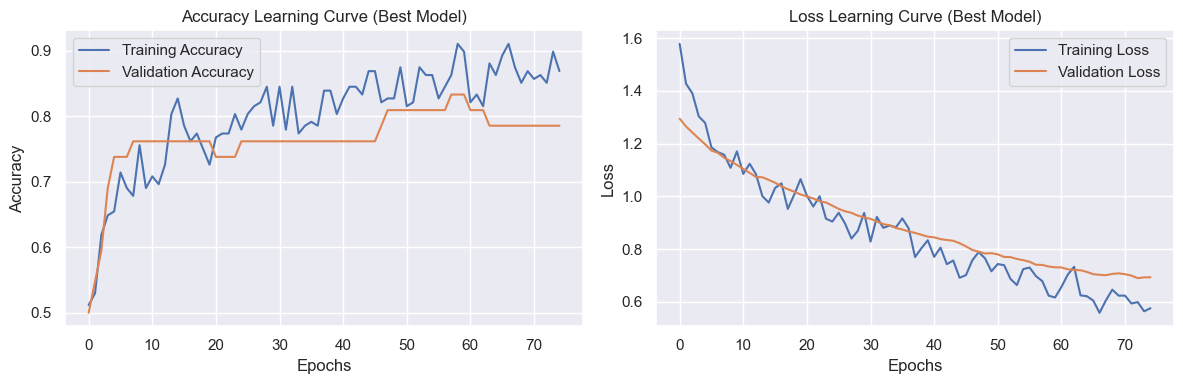

In [50]:
# Plot learning curves for the best model
plt.figure(figsize=(12, 4))

# Accuracy curve
plt.subplot(1, 2, 1)
plt.plot(best_model_history_DNN.history['accuracy'], label='Training Accuracy')
plt.plot(best_model_history_DNN.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Learning Curve (Best Model)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss curve
plt.subplot(1, 2, 2)
plt.plot(best_model_history_DNN.history['loss'], label='Training Loss')
plt.plot(best_model_history_DNN.history['val_loss'], label='Validation Loss')
plt.title('Loss Learning Curve (Best Model)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

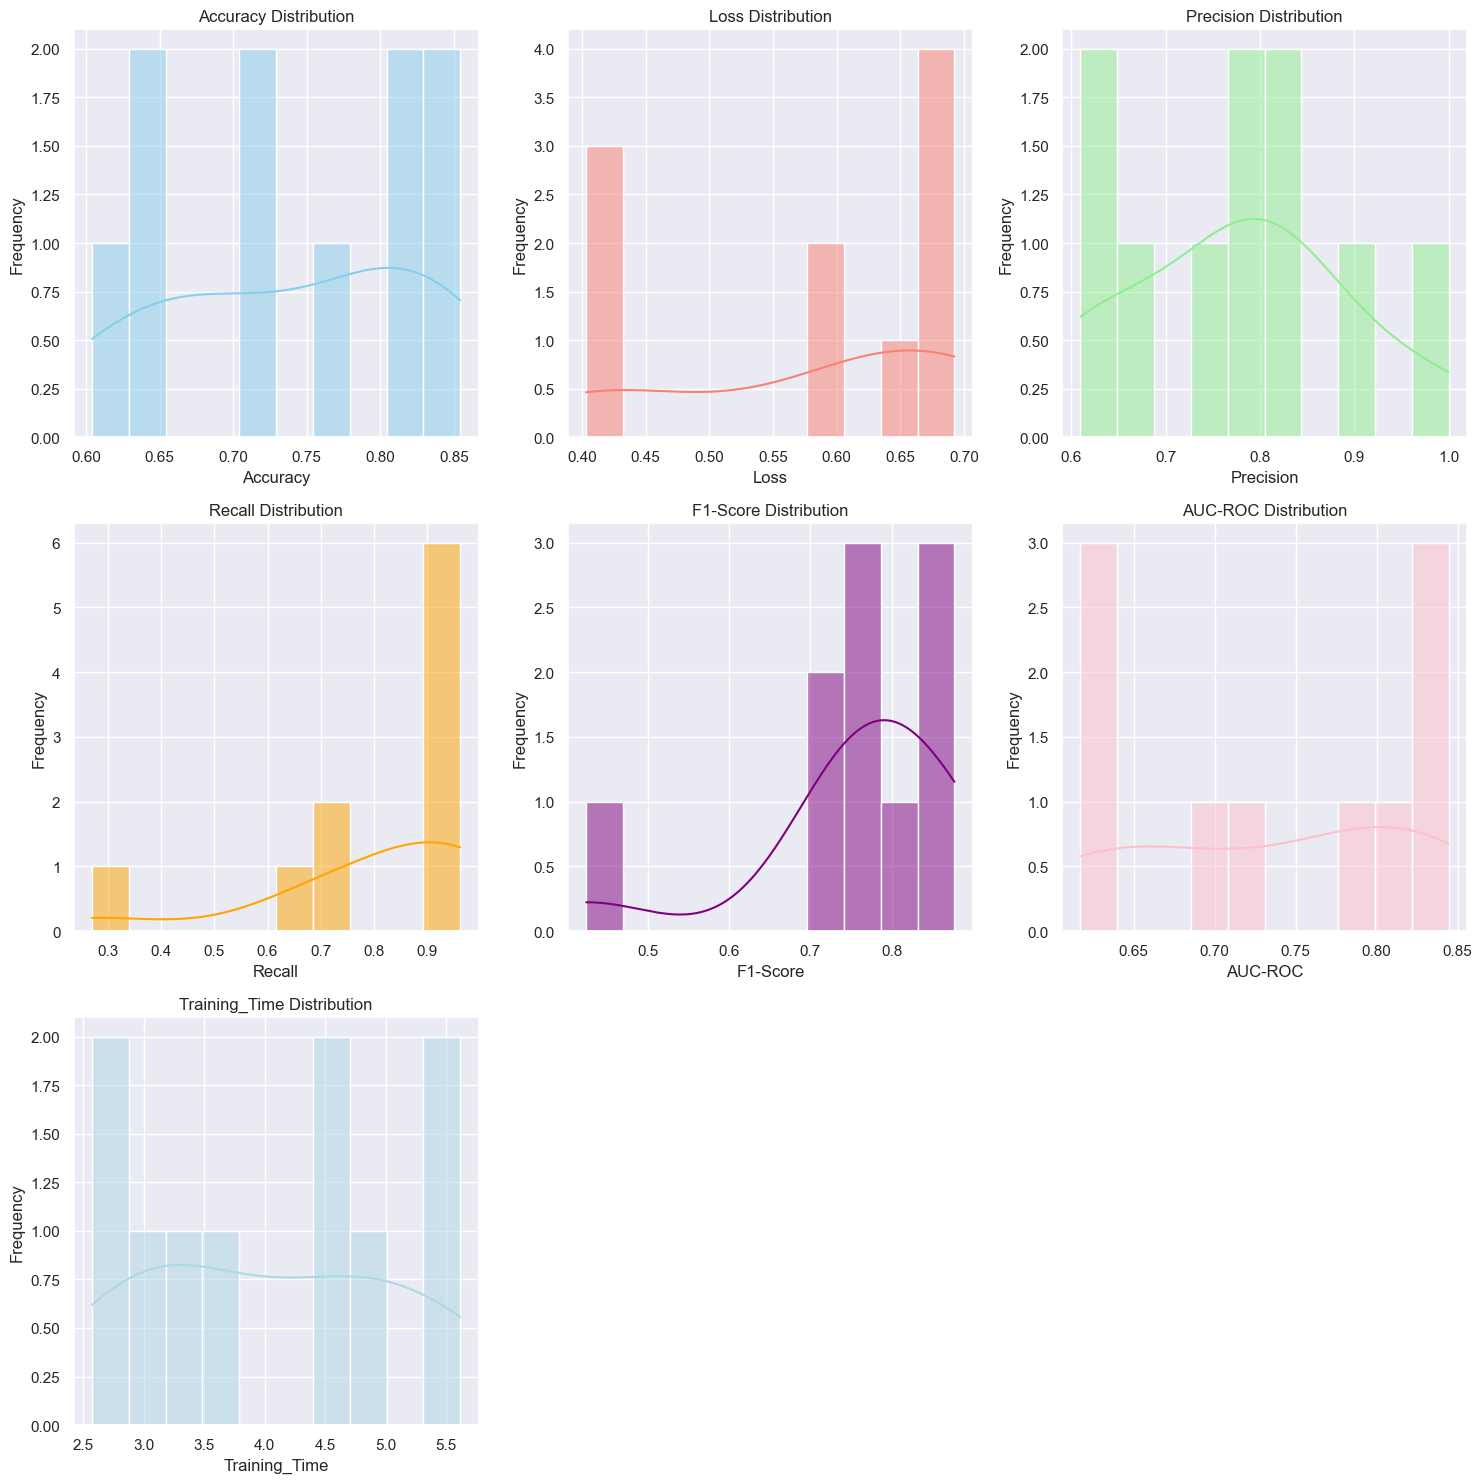

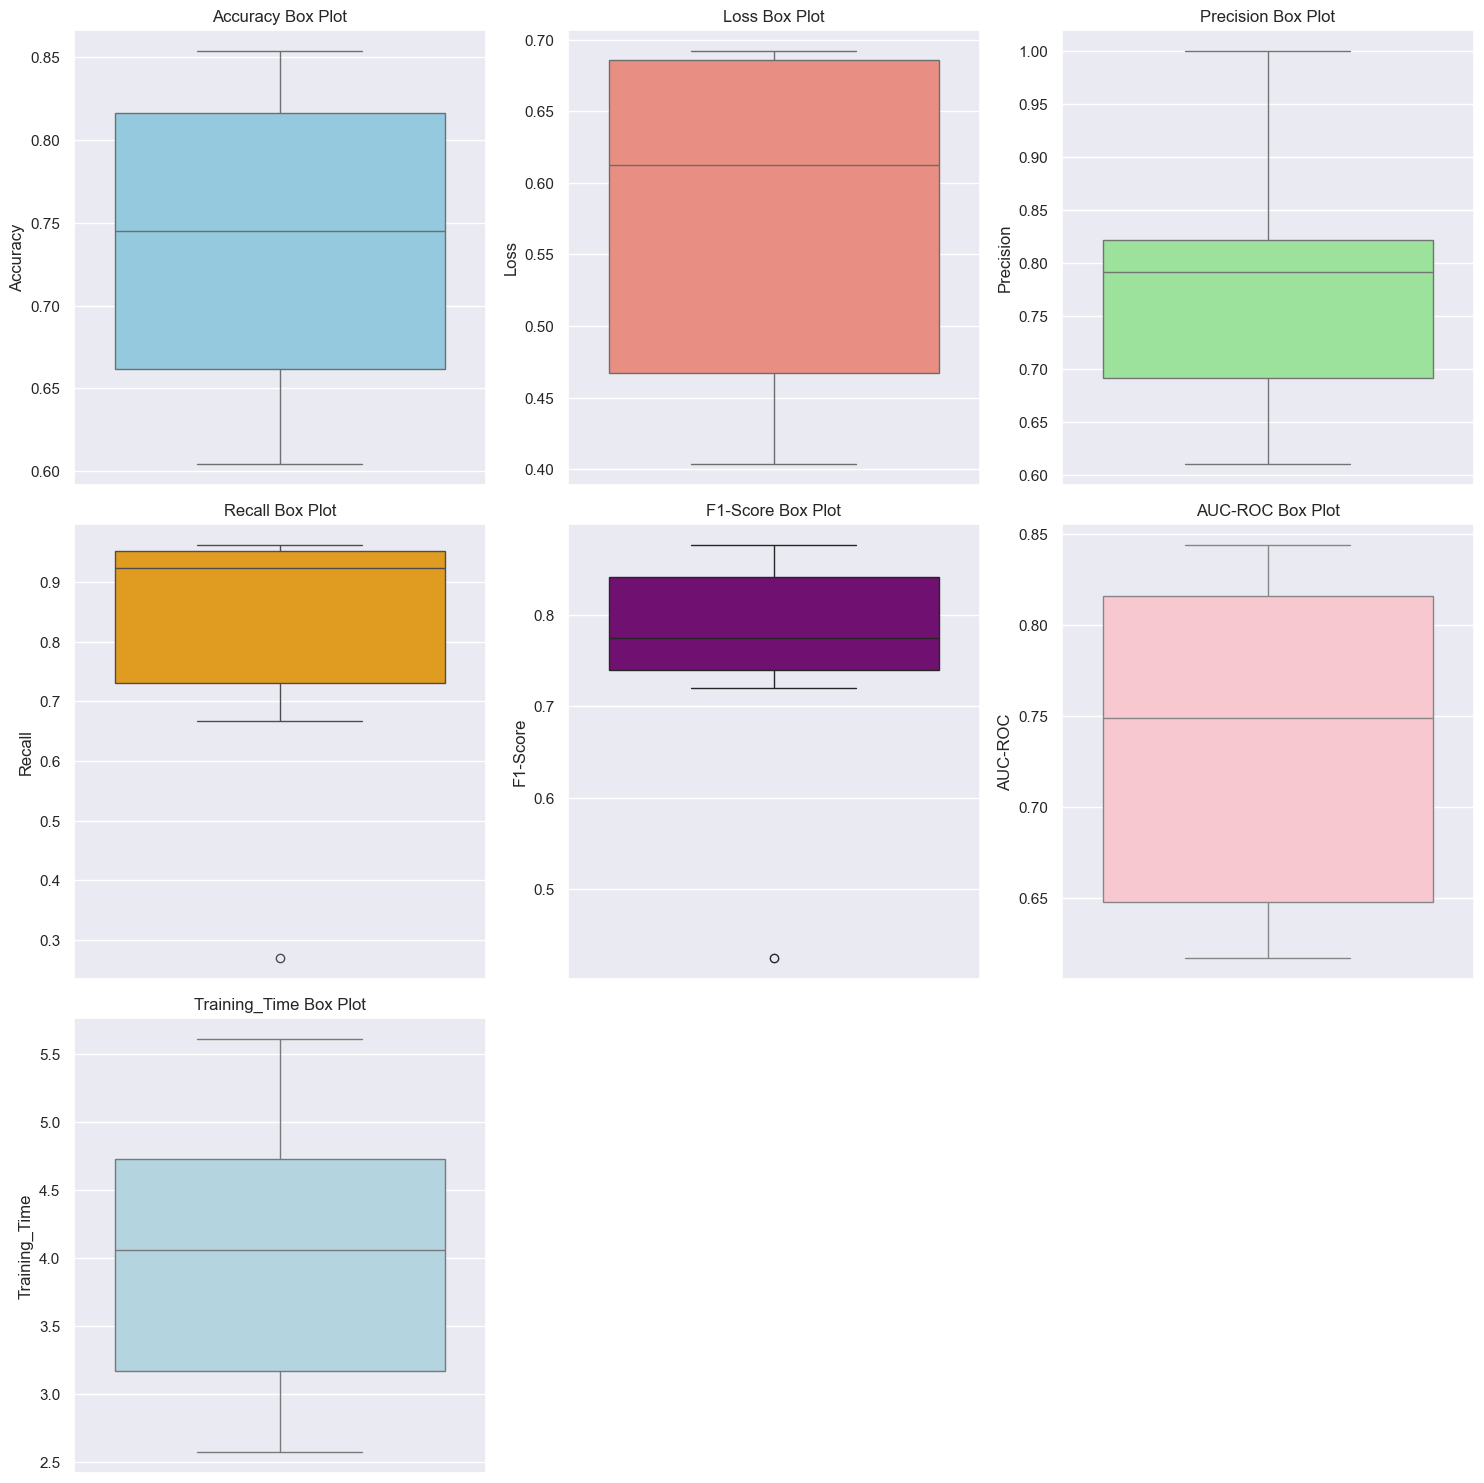

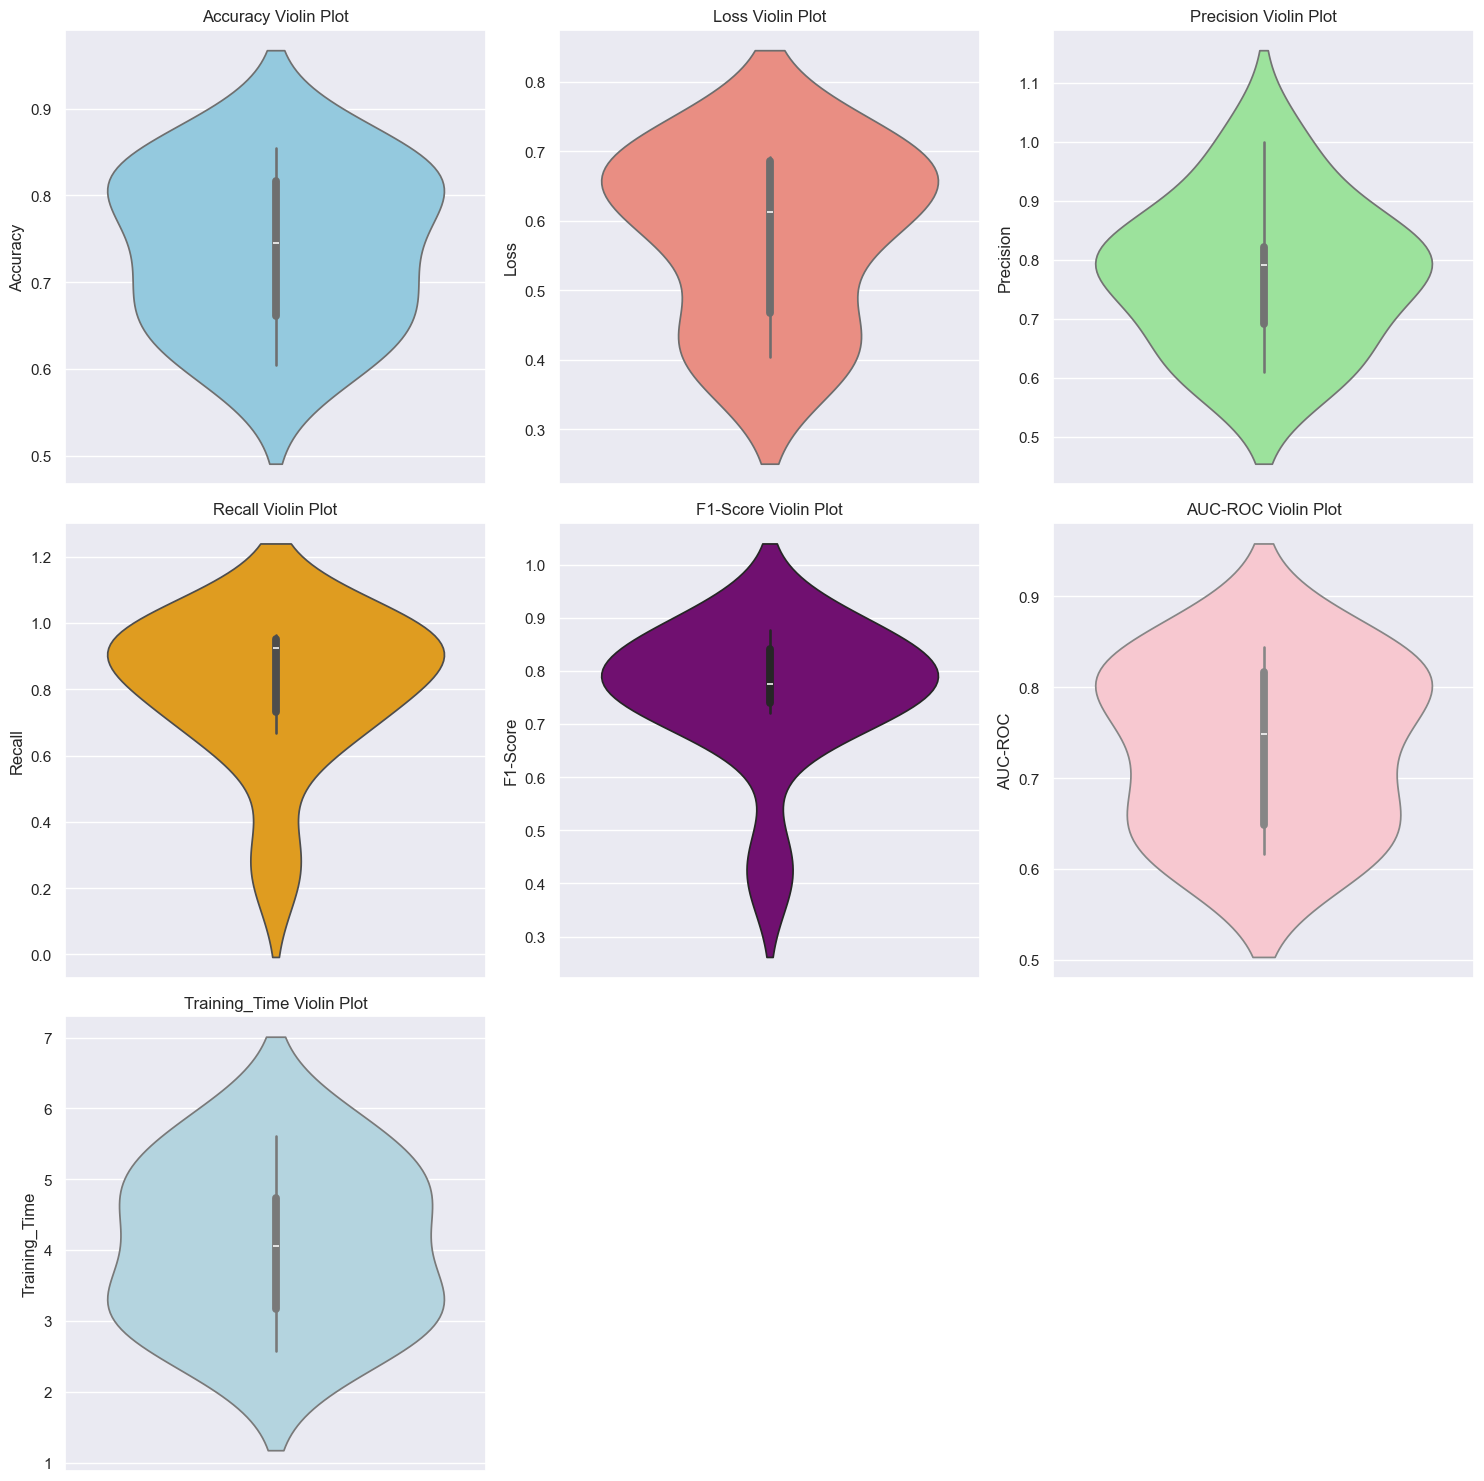

In [51]:
# Plot histograms for each metric with different colors
metrics = ['Accuracy', 'Loss', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC', 'Training_Time']
colors = ['skyblue', 'salmon', 'lightgreen', 'orange', 'purple', 'pink', 'lightblue']

plt.figure(figsize=(15, 15))
for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 3, i)
    sns.histplot(results_df_dnn[metric], bins=10, kde=True, color=colors[i-1])
    plt.title(f'{metric} Distribution')
    plt.xlabel(metric)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Plot box plots for each metric with different colors
plt.figure(figsize=(15, 15))
for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(data=results_df_dnn, y=metric, color=colors[i-1])
    plt.title(f'{metric} Box Plot')

plt.tight_layout()
plt.show()

# Plot violin plots for each metric with different colors
plt.figure(figsize=(15, 15))
for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 3, i)
    sns.violinplot(data=results_df_dnn, y=metric, color=colors[i-1])
    plt.title(f'{metric} Violin Plot')

plt.tight_layout()
plt.show()

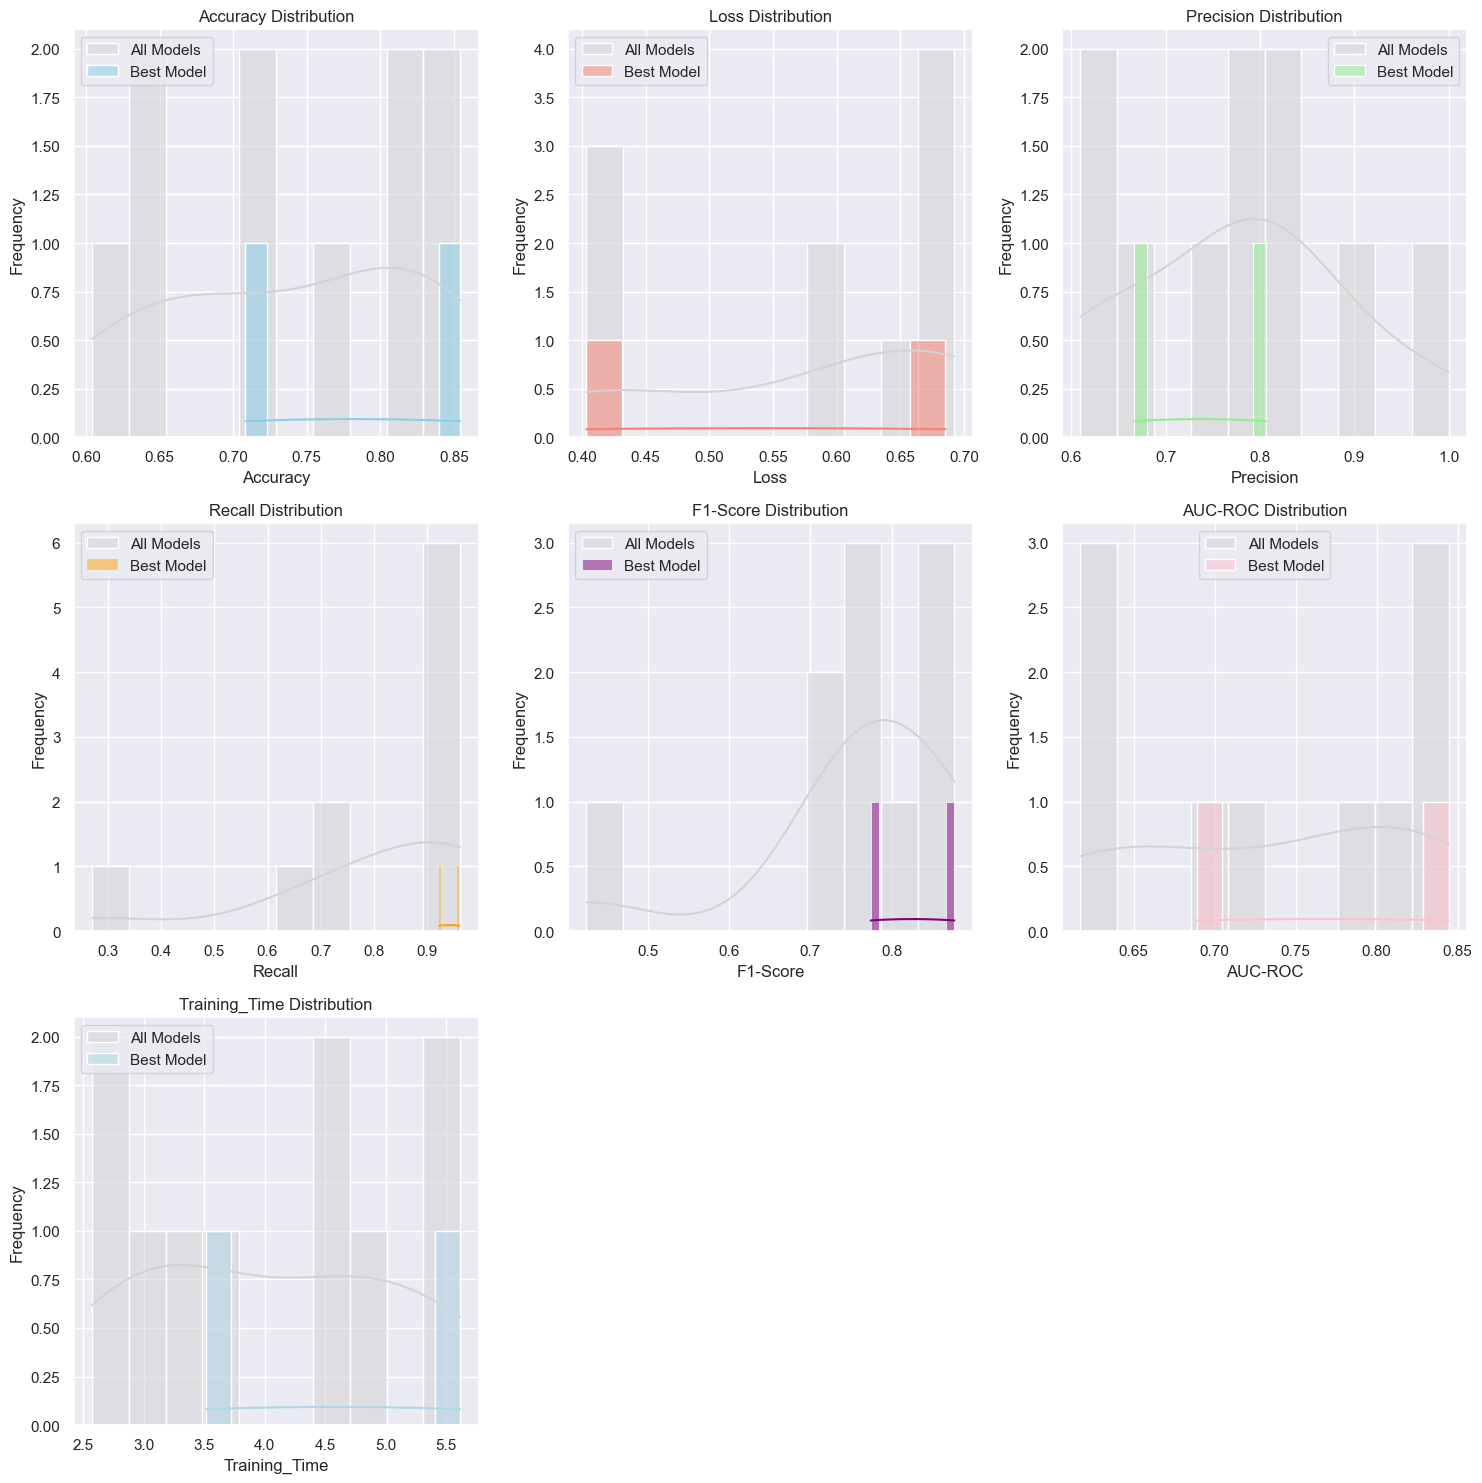

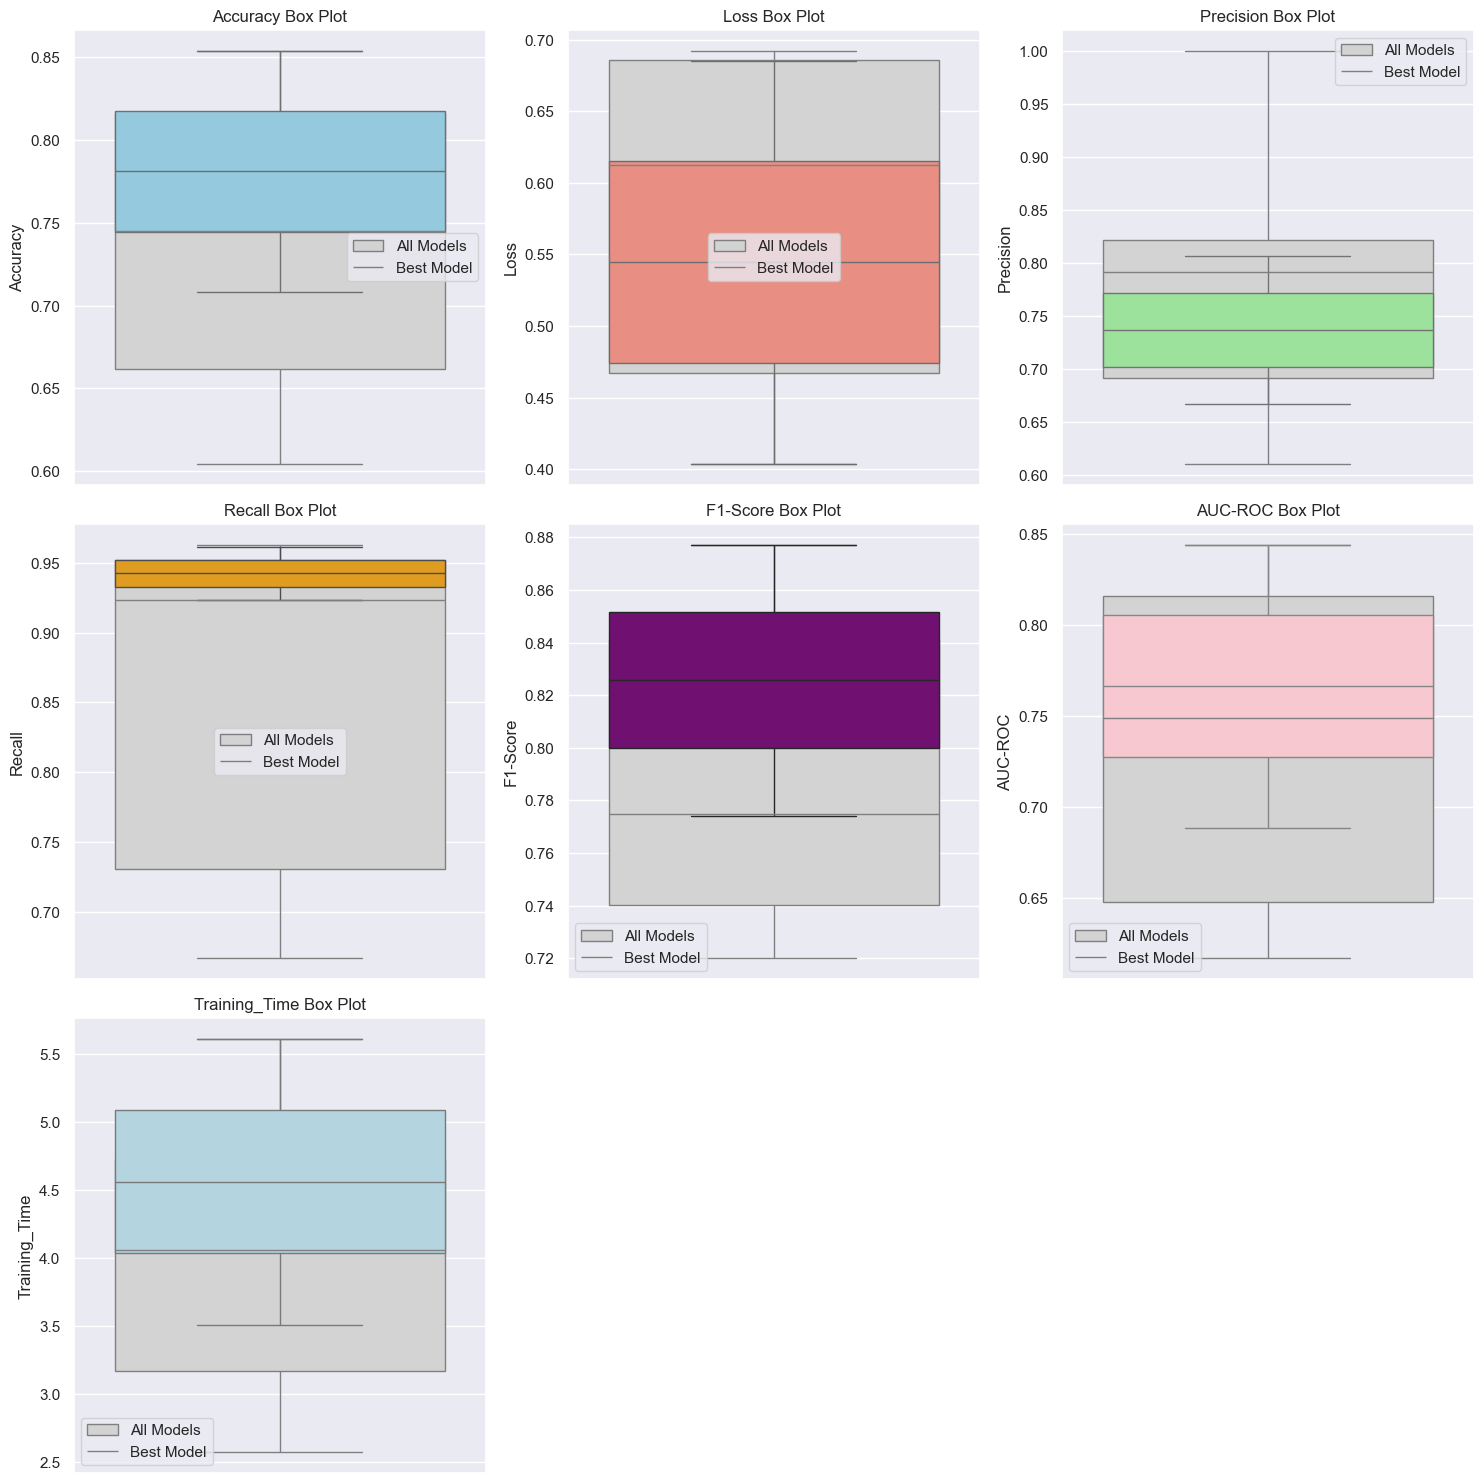

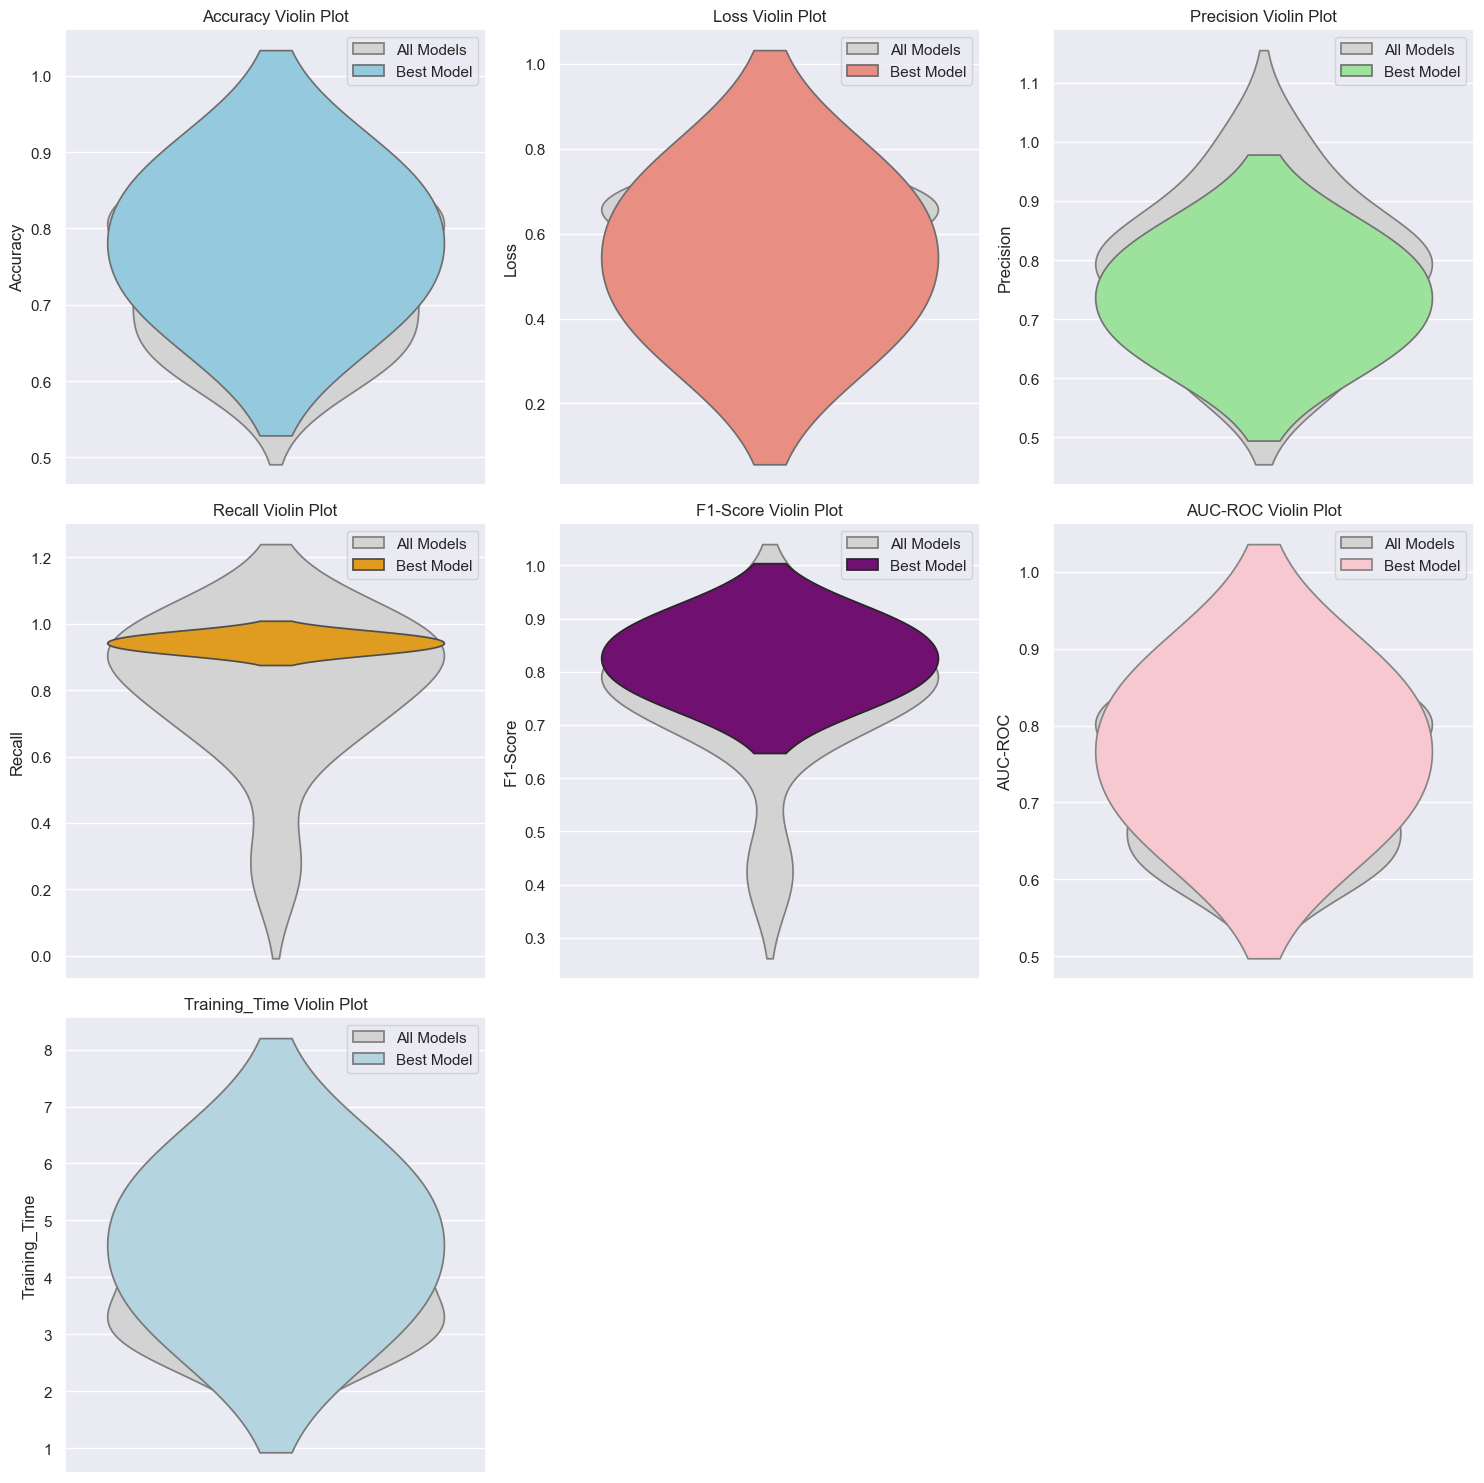

In [52]:
# Filter results_df_mlp for the best model
best_model_results_DNN = results_df_dnn[results_df_dnn['Fold'] == best_fold_index_MLP]

# Plot histograms for each metric with different colors for all models
plt.figure(figsize=(15, 15))
for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 3, i)
    sns.histplot(results_df_dnn[metric], bins=10, kde=True, color='lightgrey', label='All Models')
    sns.histplot(best_model_results_DNN[metric], bins=10, kde=True, color=colors[i-1], label='Best Model')
    plt.title(f'{metric} Distribution')
    plt.xlabel(metric)
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()

# Plot box plots for each metric with different colors for all models
plt.figure(figsize=(15, 15))
for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(data=results_df_dnn, y=metric, color='lightgrey', showfliers=False)
    sns.boxplot(data=best_model_results_DNN, y=metric, color=colors[i-1], showfliers=False)
    plt.title(f'{metric} Box Plot')
    plt.ylabel(metric)
    plt.legend(['All Models', 'Best Model'])

plt.tight_layout()
plt.show()

# Plot violin plots for each metric with different colors for all models
plt.figure(figsize=(15, 15))
for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 3, i)
    sns.violinplot(data=results_df_dnn, y=metric, color='lightgrey', inner=None, label='All Models')
    sns.violinplot(data=best_model_results_DNN, y=metric, color=colors[i-1], inner=None, label='Best Model')
    plt.title(f'{metric} Violin Plot')
    plt.ylabel(metric)
    plt.legend()

plt.tight_layout()
plt.show()

In [53]:
# Summary statistics
print("\nSummary Statistics:")
display(results_df_dnn.describe())


Summary Statistics:


Accuracy       Loss  Precision     Recall   F1-Score    AUC-ROC  \
count  10.000000  10.000000  10.000000  10.000000  10.000000  10.000000   
mean    0.741412   0.580602   0.777642   0.805271   0.757398   0.735046   
std     0.089745   0.121319   0.123063   0.219340   0.128855   0.090147   
min     0.604167   0.403509   0.609756   0.269231   0.424242   0.617133   
25%     0.661458   0.466928   0.691176   0.730769   0.740413   0.648164   
50%     0.744898   0.612630   0.791304   0.923077   0.774852   0.749063   
75%     0.816327   0.685806   0.821178   0.951923   0.841472   0.816346   
max     0.854167   0.692303   1.000000   0.962963   0.877193   0.844406   

       Training_Time  
count      10.000000  
mean        4.068632  
std         1.109058  
min         2.573288  
25%         3.171867  
50%         4.060263  
75%         4.730298  
max         5.614238

In [54]:
# Summary statistics
print("\nSummary Statistics:")
print(results_df_dnn.describe())


Summary Statistics:
        Accuracy       Loss  Precision     Recall   F1-Score    AUC-ROC  \
count  10.000000  10.000000  10.000000  10.000000  10.000000  10.000000   
mean    0.741412   0.580602   0.777642   0.805271   0.757398   0.735046   
std     0.089745   0.121319   0.123063   0.219340   0.128855   0.090147   
min     0.604167   0.403509   0.609756   0.269231   0.424242   0.617133   
25%     0.661458   0.466928   0.691176   0.730769   0.740413   0.648164   
50%     0.744898   0.612630   0.791304   0.923077   0.774852   0.749063   
75%     0.816327   0.685806   0.821178   0.951923   0.841472   0.816346   
max     0.854167   0.692303   1.000000   0.962963   0.877193   0.844406   

       Training_Time  
count      10.000000  
mean        4.068632  
std         1.109058  
min         2.573288  
25%         3.171867  
50%         4.060263  
75%         4.730298  
max         5.614238  


Calculating Required Fields

In [55]:
print("Shape of y_test:", y_test.shape)
y_test = y_test.reshape(-1, 1)
print("Shape of y_test:", y_test.shape)
num_classes = y_test.shape[1]
y_test_orig = y_test
y_test = y_test[:61].reshape(-1, 1)
print("Shape of y_test:", y_test.shape)

Shape of y_test: (61,)
Shape of y_test: (61, 1)
Shape of y_test: (61, 1)


In [56]:
# Function to compute softmax error (categorical cross-entropy loss)
def compute_softmax_error(model, x_test, y_test):
    predictions = model.predict(x_test)
    loss_fn = CategoricalCrossentropy()
    softmax_error = loss_fn(y_test, predictions).numpy()
    return softmax_error

# Placeholder function to simulate teacher model predictions
def get_teacher_predictions(x_data):
    # In practice, this would be obtained from a trained teacher model
    return np.random.rand(x_data.shape[0], num_classes)

# Function to compute distillation error (KLDivergence)
def compute_distillation_error(student_model, x_data, teacher_predictions):
    predictions = student_model.predict(x_data)
    distillation_loss = KLDivergence()
    distillation_error = distillation_loss(teacher_predictions, predictions).numpy()
    return distillation_error

# Function to compute ConfWeight Error
def compute_confweight_error(model, x_data, y_data):
    predictions = model.predict(x_data)
    confidences = np.max(predictions, axis=1)
    correct_predictions = np.argmax(predictions, axis=1) == np.argmax(y_data, axis=1)
    errors = 1 - correct_predictions
    confweight_error = np.mean(errors * (1 - confidences))
    return confweight_error

# Function to compute SRatio Error
def compute_sratio_error(model, x_data, y_data):
    predictions = model.predict(x_data)
    true_probabilities = y_data / np.sum(y_data, axis=1, keepdims=True)
    predicted_probabilities = predictions / np.sum(predictions, axis=1, keepdims=True)
    sratio_error = np.mean(np.abs(true_probabilities - predicted_probabilities))
    return sratio_error

1.  MLP Model

In [57]:
model_MLP = load_model(r'saved_model/MLP_Model.h5')

# Compute and print Softmax Error
softmax_error_MLP = compute_softmax_error(model_MLP, x_test, y_test)
print(f"Softmax Error: {softmax_error_MLP}")

# Compute and print Distillation Error
teacher_predictions_MLP = get_teacher_predictions(x_test)
distillation_error_MLP = compute_distillation_error(model_MLP, x_test, teacher_predictions_MLP)
print(f"Distillation Error: {distillation_error_MLP}")

# Compute and print ConfWeight Error
confweight_error_MLP = compute_confweight_error(model_MLP, x_test, y_test)
print(f"ConfWeight Error: {confweight_error_MLP}")

# Compute and print SRatio Error
sratio_error_MLP = compute_sratio_error(model_MLP, x_test, y_test)
print(f"SRatio Error: {sratio_error_MLP}")

# Track and print computation time for predictions
start_time_MLP = time.time()
predictions_MLP = model_MLP.predict(x_test)
computation_time_MLP = time.time() - start_time_MLP
print(f"Computation Time: {computation_time_MLP} seconds")

# Compute predictions and calculate confusion matrix
predictions = model_MLP.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\losses\losses.py:22: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(61, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


Softmax Error: 6.644452810178336e-08
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Distillation Error: 0.4100251793861389
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
ConfWeight Error: 0.0
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
SRatio Error: nan


C:\Users\piyus\AppData\Local\Temp\ipykernel_21480\2073719375.py:32: RuntimeWarning: invalid value encountered in divide
  true_probabilities = y_data / np.sum(y_data, axis=1, keepdims=True)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Computation Time: 0.05282735824584961 seconds
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Confusion Matrix:
[[61]]


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [58]:
print("Error Metrics for the MLP Model:")
print(f"- Softmax Error: {softmax_error_MLP:.3e}")
print(f"- Distillation Error: {distillation_error_MLP:.2f}")
print(f"- ConfWeight Error: {confweight_error_MLP}")
print(f"- SRatio Error: {sratio_error_MLP}")
print(f"- Computation Time: {computation_time_MLP:.4f} seconds")

print("\nConfusion Matrix:")
print(conf_matrix)

Error Metrics for the MLP Model:
- Softmax Error: 6.644e-08
- Distillation Error: 0.41
- ConfWeight Error: 0.0
- SRatio Error: nan
- Computation Time: 0.0528 seconds

Confusion Matrix:
[[61]]


2.  For SVM-Architecture Model

In [59]:
model_SVM = load_model(r'saved_model/SVM_Model.h5')

# Compute and print Softmax Error
softmax_error_SVM = compute_softmax_error(model_SVM, x_test, y_test)
print(f"Softmax Error: {softmax_error_SVM}")

# Compute and print Distillation Error
teacher_predictions_SVM = get_teacher_predictions(x_test)
distillation_error_SVM = compute_distillation_error(model_SVM, x_test, teacher_predictions_SVM)
print(f"Distillation Error: {distillation_error_SVM}")

# Compute and print ConfWeight Error
confweight_error_SVM = compute_confweight_error(model_SVM, x_test, y_test)
print(f"ConfWeight Error: {confweight_error_SVM}")

# Compute and print SRatio Error
sratio_error_SVM = compute_sratio_error(model_SVM, x_test, y_test)
print(f"SRatio Error: {sratio_error_SVM}")

# Track and print computation time for predictions
start_time_SVM = time.time()
predictions_SVM = model_SVM.predict(x_test)
computation_time_SVM = time.time() - start_time_SVM
print(f"Computation Time: {computation_time_SVM} seconds")

# Compute predictions and calculate confusion matrix
predictions = model_SVM.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Softmax Error: 6.644452810178336e-08
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\losses\losses.py:22: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(61, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Distillation Error: 0.1929238885641098
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
ConfWeight Error: 0.0
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
SRatio Error: nan


C:\Users\piyus\AppData\Local\Temp\ipykernel_21480\2073719375.py:32: RuntimeWarning: invalid value encountered in divide
  true_probabilities = y_data / np.sum(y_data, axis=1, keepdims=True)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Computation Time: 0.0612032413482666 seconds
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Confusion Matrix:
[[61]]


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [60]:
print("Error Metrics for the SVM Model:")
print(f"- Softmax Error: {softmax_error_SVM:.3e}")
print(f"- Distillation Error: {distillation_error_SVM:.2f}")
print(f"- ConfWeight Error: {confweight_error_SVM}")
print(f"- SRatio Error: {sratio_error_SVM}")
print(f"- Computation Time: {computation_time_SVM:.4f} seconds")

print("\nConfusion Matrix:")
print(conf_matrix)

Error Metrics for the SVM Model:
- Softmax Error: 6.644e-08
- Distillation Error: 0.19
- ConfWeight Error: 0.0
- SRatio Error: nan
- Computation Time: 0.0612 seconds

Confusion Matrix:
[[61]]


3. DNN Model

In [61]:
model_DNN = load_model(r'saved_model/Dense_NN_Model.h5')

# Compute and print Softmax Error
softmax_error_DNN = compute_softmax_error(model_DNN, x_test, y_test)
print(f"Softmax Error: {softmax_error_DNN}")

# Compute and print Distillation Error
teacher_predictions_DNN = get_teacher_predictions(x_test)
distillation_error_DNN = compute_distillation_error(model_DNN, x_test, teacher_predictions_DNN)
print(f"Distillation Error: {distillation_error_DNN}")

# Compute and print ConfWeight Error
confweight_error_DNN = compute_confweight_error(model_DNN, x_test, y_test)
print(f"ConfWeight Error: {confweight_error_DNN}")

# Compute and print SRatio Error
sratio_error_DNN = compute_sratio_error(model_DNN, x_test, y_test)
print(f"SRatio Error: {sratio_error_DNN}")

# Track and print computation time for predictions
start_time_DNN = time.time()
predictions_DNN = model_DNN.predict(x_test)
computation_time_DNN = time.time() - start_time_DNN
print(f"Computation Time: {computation_time_DNN} seconds")

# Compute predictions and calculate confusion matrix
predictions = model_DNN.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\losses\losses.py:22: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(61, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


Softmax Error: 6.644452810178336e-08
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Distillation Error: -0.03733466565608978
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
ConfWeight Error: 0.0
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
SRatio Error: nan


C:\Users\piyus\AppData\Local\Temp\ipykernel_21480\2073719375.py:32: RuntimeWarning: invalid value encountered in divide
  true_probabilities = y_data / np.sum(y_data, axis=1, keepdims=True)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Computation Time: 0.06069231033325195 seconds
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Confusion Matrix:
[[61]]


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [62]:
print("Error Metrics for the DNN Model:")
print(f"- Softmax Error: {softmax_error_DNN:.3e}")
print(f"- Distillation Error: {distillation_error_DNN:.2f}")
print(f"- ConfWeight Error: {confweight_error_DNN}")
print(f"- SRatio Error: {sratio_error_DNN}")
print(f"- Computation Time: {computation_time_DNN:.4f} seconds")

print("\nConfusion Matrix:")
print(conf_matrix)

Error Metrics for the DNN Model:
- Softmax Error: 6.644e-08
- Distillation Error: -0.04
- ConfWeight Error: 0.0
- SRatio Error: nan
- Computation Time: 0.0607 seconds

Confusion Matrix:
[[61]]


CONCLUSION

In [63]:
# DataFrame creation with custom number formatting
data = {
    "Model Name": ["MLP Mode;", "SVM Model", "DNN Model"],
    "Accuracy": ["{:.2f}".format(accuracy_MLP),
                 "{:.2f}".format(accuracy_SVM),
                 "{:.2f}".format(accuracy_DNN)],
    "SM Error": ["{:.3e}".format(softmax_error_MLP),
                 "{:.3e}".format(softmax_error_SVM),
                 "{:.3e}".format(softmax_error_DNN)],
    "Distillation Error (SM)": ["{:.2f}".format(distillation_error_MLP),
                                 "{:.2f}".format(distillation_error_SVM),
                                 "{:.2f}".format(distillation_error_DNN),],
    "ConfWeight Error (SM)": ["{:.2f}".format(confweight_error_MLP),
                               "{:.2f}".format(confweight_error_SVM),
                               "{:.2f}".format(confweight_error_DNN)],
    "SRatio Error (SM)":    ["{:.2f}".format(sratio_error_MLP),
                                 "{:.2f}".format(sratio_error_SVM),
                                 "{:.2f}".format(sratio_error_DNN),],
    "Computation Time": ["{:.4f}".format(computation_time_MLP),
                          "{:.4f}".format(computation_time_SVM),
                          "{:.4f}".format(computation_time_DNN),]
}

# DataFrame creation
df_acc = pd.DataFrame(data)
display(df_acc)

Model Name Accuracy   SM Error Distillation Error (SM)  \
0  MLP Mode;     0.85  6.644e-08                    0.41   
1  SVM Model     0.67  6.644e-08                    0.19   
2  DNN Model     0.83  6.644e-08                   -0.04   

  ConfWeight Error (SM) SRatio Error (SM) Computation Time  
0                  0.00               nan           0.0528  
1                  0.00               nan           0.0612  
2                  0.00               nan           0.0607